# Reto Optimización no lineal

In [1]:
import pandas as pd
import numpy as np
import random
from deap import base, creator, tools, algorithms
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')



In [2]:
# Parámetros
almacenamiento = 400 #Almacenamiento inventario en mt2
costo_plantacion = 20 #Costo de la plantación por unidad
dias_anticipación = 1 # Días de anticipación para realizar el pedido
min_dias_aclimatacion = 3 # Mínimo de días de aclimatación
max_dias_aclimatacion = 7 # Máximo de días de aclimatación
dias_simulacion = 30 # Días de simulación
hectareas_poligono = {
    1: 5.4,
    2:9,
    3: 8,
    4: 8,
    5: 7.56,
    6: 5,
    7: 12,
    8: 1.38,
    9: 12,
    10: 5,
    11: 4,
    12: 6,
    13: 2,
    14: 2.5,
    15: 13,
    16: 5.64,
    17: 6.11,
    18: 7.11,
    19: 4.92,
}
demanda_especies_por_hectarea = {
    1: 33,
    2: 20,
    3: 33,
    4: 33,
    5: 39,
    6: 30,
    7: 58,
    8: 51,
    9: 69,
}

## Proveedores:

In [3]:
# Cargar datos correctamente considerando la estructura específica del CSV
costos_proveedor = pd.read_csv('CostosEspeciesProveedores.csv', header=None)

# Extraer nombres de proveedores (primera fila, saltando primera celda que es NaN)
nombres_proveedores = costos_proveedor.iloc[0, 1:].tolist()

# Extraer nombres de especies (primera columna, saltando primera celda)
nombres_especies = costos_proveedor.iloc[1:, 0].tolist()

# Extraer matriz de costos (convertir a float)
matriz_costos = costos_proveedor.iloc[1:, 1:].values.astype(float)

# Definir constantes
costo_transporte = 4500
capacidad_máxima_transporte = 8000 # Capacidad máxima de transporte en conjunto de los proveedores
#demanda_especies = [100, 200, 150, 300, 250, 700, 600, 80, 30000]  # Demanda de cada especie
#num_especies = len(demanda_especies)
#num_proveedores = matriz_costos.shape[1]

# Verificar dimensiones
#if num_especies != len(nombres_especies):
   # print(f"¡Advertencia! El número de especies ({num_especies}) no coincide con los nombres disponibles ({len(nombres_especies)})")

In [4]:
def calcular_costo_total(solucion, matriz_costos, costo_transporte):
    """
    Calcula el costo total de una solución
    
    Args:
        solucion: Matriz donde cada fila es una especie y cada columna es un proveedor.
                 Los valores representan la cantidad de especies i compradas al proveedor j.
        matriz_costos: Matriz de costos unitarios de cada especie para cada proveedor
        costo_transporte: Costo de transporte por proveedor utilizado
    
    Returns:
        costo_total: Costo total de la solución
    """
    # Costo de compra de especies
    costo_compra = np.sum(solucion * matriz_costos)
    
    # Número de proveedores utilizados (si alguna especie > 0)
    proveedores_utilizados = np.sum(np.any(solucion > 0, axis=0))
    
    # Costo de transporte
    costo_trans = costo_transporte * proveedores_utilizados
    
    return costo_compra + costo_trans, costo_compra, costo_trans, proveedores_utilizados

def solucion_greedy(matriz_costos, demanda_especies, capacidad_maxima):
    """
    Genera una solución greedy básica ajustando la demanda de especies
    de acuerdo a la capacidad máxima y los costos
    
    Args:
        matriz_costos: Matriz de costos unitarios de cada especie para cada proveedor
        demanda_especies: Lista con la demanda de cada especie
    
    Returns:
        solucion: Matriz de asignación de especies a proveedores
    """
    num_especies = len(demanda_especies)
    num_proveedores = matriz_costos.shape[1]
    
    # Inicializar matriz de solución con ceros
    solucion = np.zeros((num_especies, num_proveedores))
    
    # Para cada especie, elegir el proveedor más barato
    for especie in range(num_especies):
        # Ordenar proveedores por costo para esta especie
        proveedores_ordenados = np.argsort(matriz_costos[especie])
        
        # Asignar toda la demanda al proveedor más barato
        solucion[especie, proveedores_ordenados[0]] = demanda_especies[especie]
# Paso 2: Ajustar las cantidades proporcionalmente si es necesario
    demanda_total = sum(demanda_especies)
    
    if demanda_total > capacidad_maxima:
        # Factor de escala para ajustar proporcionalmente
        factor = capacidad_maxima / demanda_total
        
        # Ajustar cada asignación
        for especie in range(num_especies):
            for proveedor in range(num_proveedores):
                if solucion[especie, proveedor] > 0:
                    # Redondear para obtener un número entero de plantas
                    solucion[especie, proveedor] = round(solucion[especie, proveedor] * factor)
    
    return solucion

def analizar_solucion(solucion, matriz_costos, costo_transporte, 
                    nombres_especies=None, nombres_proveedores=None):
    """
    Analiza y muestra información detallada sobre una solución
    
    Args:
        solucion: Matriz de asignación de especies a proveedores
        matriz_costos: Matriz de costos unitarios
        costo_transporte: Costo por proveedor usado
        nombres_especies: Lista de nombres de especies (opcional)
        nombres_proveedores: Lista de nombres de proveedores (opcional)
        
    Returns:
        costo_total, num_proveedores, costo_compra, costo_trans
    """
    costo_total, costo_compra, costo_trans, num_proveedores = calcular_costo_total(
        solucion, matriz_costos, costo_transporte)
    
    proveedores_usados = np.any(solucion > 0, axis=0)
    
    print("\n--- Análisis de Solución Greedy ---")
    print(f"Costo total: {costo_total:.2f}")
    print(f"Costo de compra: {costo_compra:.2f}")
    print(f"Costo de transporte: {costo_trans:.2f}")
    print(f"Número de proveedores utilizados: {num_proveedores}")
    
    # Mostrar qué proveedores se usan
    print("\nProveedores utilizados:")
    for i, usado in enumerate(proveedores_usados):
        if usado:
            if nombres_proveedores and i < len(nombres_proveedores):
                nombre = nombres_proveedores[i]
            else:
                nombre = f"Proveedor {i}"
            print(f"- {nombre}")
    
    # Detallar la distribución de la compra
    print("\n--- Distribución Detallada de Compras ---")
    num_especies = solucion.shape[0]
    num_proveedores = solucion.shape[1]
    
    for especie in range(num_especies):
        if nombres_especies and especie < len(nombres_especies):
            nombre_especie = nombres_especies[especie]
        else:
            nombre_especie = f"Especie {especie}"
        
        print(f"\n{nombre_especie}:")
        for proveedor in range(num_proveedores):
            if solucion[especie, proveedor] > 0:
                if nombres_proveedores and proveedor < len(nombres_proveedores):
                    nombre_proveedor = nombres_proveedores[proveedor]
                else:
                    nombre_proveedor = f"Proveedor {proveedor}"
                
                print(f"  - Comprar {int(solucion[especie, proveedor])} unidades a {nombre_proveedor} " +
                      f"(costo unitario: {matriz_costos[especie, proveedor]:.2f})")
    
    return costo_total, num_proveedores, costo_compra, costo_trans

def visualizar_distribucion(solucion, nombres_especies=None, nombres_proveedores=None):
    """
    Visualiza la distribución de compras por especie y proveedor
    
    Args:
        solucion: Matriz de asignación de especies a proveedores
        nombres_especies: Lista de nombres de especies (opcional)
        nombres_proveedores: Lista de nombres de proveedores (opcional)
    """
    num_especies = solucion.shape[0]
    num_proveedores = solucion.shape[1]
    
    plt.figure(figsize=(12, 8))
    
    # Crear una máscara para valores mayores a cero
    mask = solucion > 0
    
    # Crear etiquetas para el heatmap
    if nombres_especies and len(nombres_especies) == num_especies:
        rows = nombres_especies
    else:
        rows = [f"Especie {i}" for i in range(num_especies)]
        
    if nombres_proveedores and len(nombres_proveedores) == num_proveedores:
        cols = nombres_proveedores
    else:
        cols = [f"Proveedor {i}" for i in range(num_proveedores)]
    
    # Crear un dataframe para seaborn
    df = pd.DataFrame(solucion, index=rows, columns=cols)
    
    # Crear heatmap
    sns.heatmap(df, annot=True, fmt='.0f', cmap='YlGnBu', mask=(~mask))
    plt.title('Distribución de Compras por Especie y Proveedor')
    plt.tight_layout()
    plt.show()

def ejecutar_greedy(matriz_costos, demanda_especies, costo_transporte,
                                capacidad_maxima,
                                nombres_especies=None, nombres_proveedores=None, 
                                visualizar=True):
    """
    Función principal para ejecutar el algoritmo greedy con restricción de capacidad
    
    Args:
        matriz_costos: Matriz de costos unitarios de cada especie para cada proveedor
        demanda_especies: Lista con la demanda de cada especie
        costo_transporte: Costo de transporte por proveedor utilizado
        capacidad_maxima: Capacidad máxima de transporte
        nombres_especies: Lista de nombres de especies (opcional)
        nombres_proveedores: Lista de nombres de proveedores (opcional)
        visualizar: Booleano para indicar si se debe mostrar la visualización
        
    Returns:
        solucion: Matriz de asignación de especies a proveedores
        costo_total: Costo total de la solución
    """
    # Calcular demanda total para referencia
    demanda_total = sum(demanda_especies)
    
    print(f"Demanda total: {demanda_total}, Capacidad máxima: {capacidad_maxima}")
    
    if demanda_total > capacidad_maxima:
        print(f"⚠️ La demanda total ({demanda_total}) excede la capacidad máxima ({capacidad_maxima}).")
        print("Se aplicará un ajuste proporcional a las cantidades solicitadas.")
    
    # Generar solución greedy proporcional
    solucion = solucion_greedy(matriz_costos, demanda_especies, capacidad_maxima)
    
    # Verificar capacidad usada
    capacidad_usada = np.sum(solucion)
    print(f"Capacidad utilizada: {capacidad_usada} de {capacidad_maxima} ({capacidad_usada/capacidad_maxima*100:.1f}%)")
    
    # Analizar la solución
    costo_total, _, _, _ = analizar_solucion(
        solucion, matriz_costos, costo_transporte,
        nombres_especies, nombres_proveedores
    )
    
    # Visualizar la solución
    if visualizar:
        visualizar_distribucion(solucion, nombres_especies, nombres_proveedores)
    
    return solucion, costo_total

## Ruteo:


In [5]:
distancias_poligonos = pd.read_csv('distancias_reducidas_19_poligonos.csv')
velocidad_camioneta = 40 #km/h
tiempo_maximo = 6 # jornada laboral horas
tiempo_carga = 0.5 #horas
carga_máxima = 524
#Distancias entre poligonos en horas
dist_poligonos_hrs = distancias_poligonos/velocidad_camioneta
dist_poligonos_hrs = dist_poligonos_hrs.round(2)
#Las rutas se inician desde el polígono 6, considerando que se empieza desde el poligono 0
dist_poligonos_hrs.head(5)
dist_poligonos_hrs = dist_poligonos_hrs.to_numpy()
# Total number of polygons
NUM_POLYGONS = 19
START_POLYGON = 6

Se generaron 3 rutas greedy:
Ruta 1: [6, 5, 4, 7, 13, 14, 12, 11, 6], Tiempo: 5.66 horas
Ruta 2: [6, 18, 17, 16, 15, 8, 9, 10, 6], Tiempo: 5.27 horas
Ruta 3: [6, 3, 2, 1, 0, 6], Tiempo: 4.31 horas
Total de polígonos visitados: 18 de 18


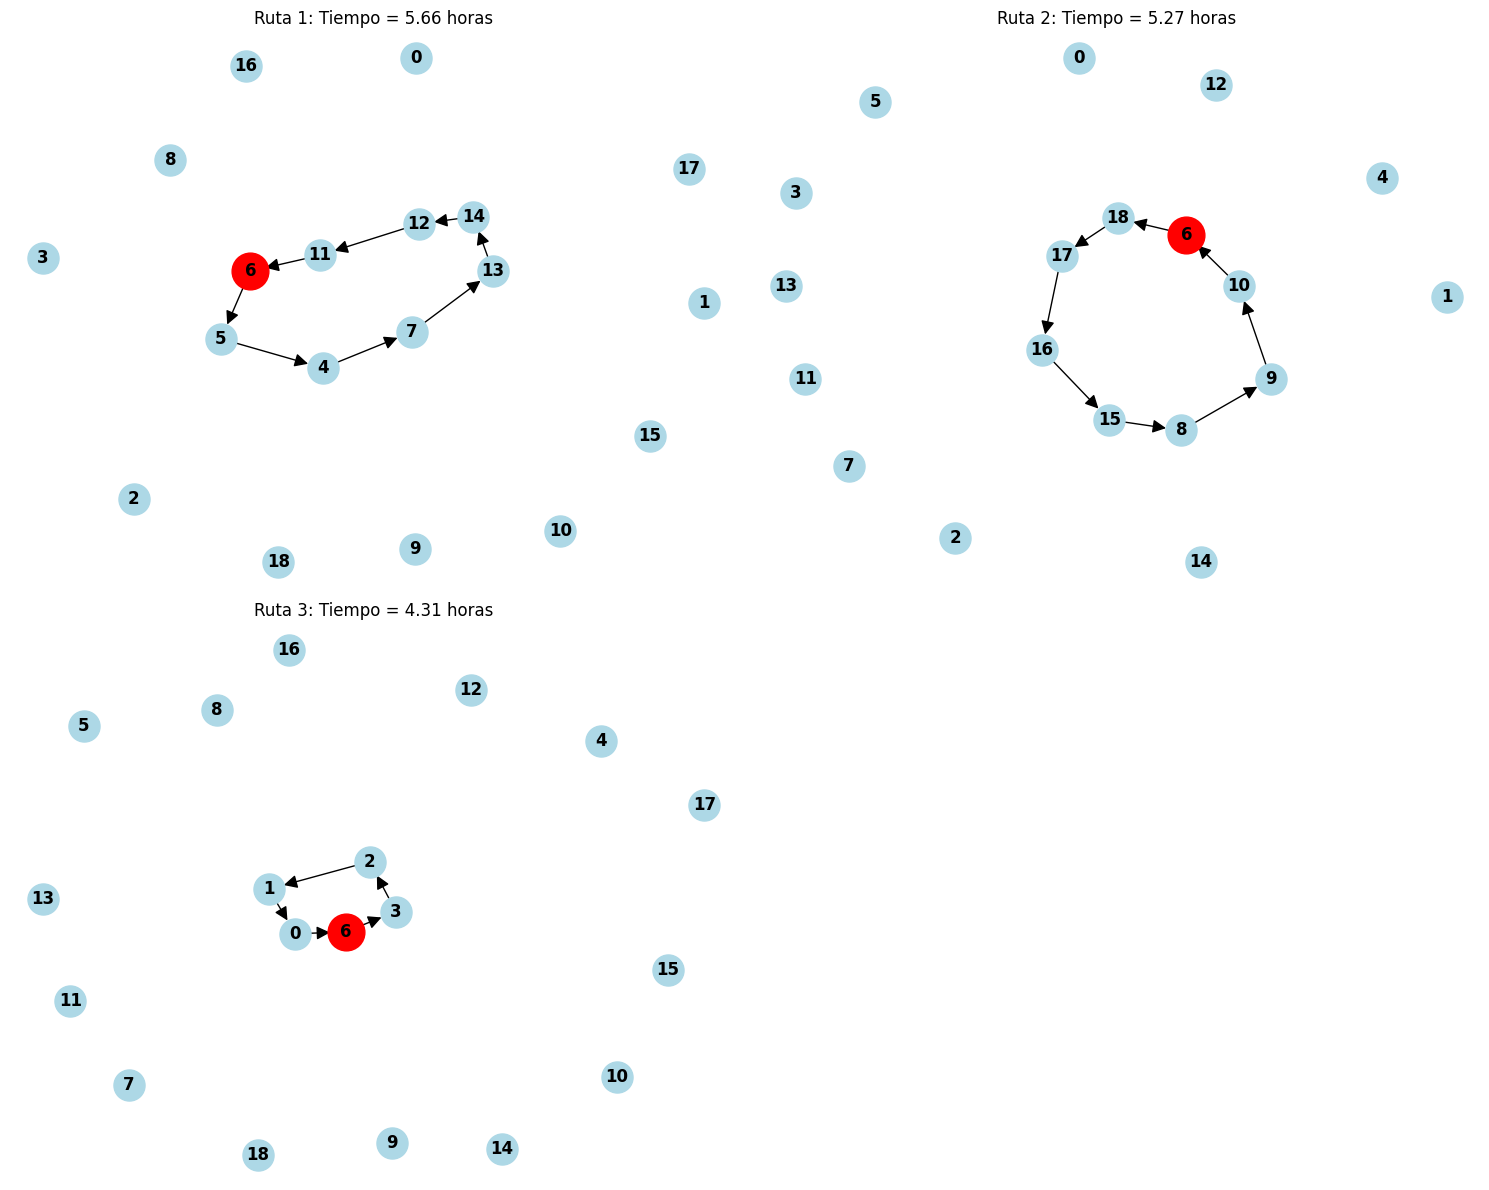

In [6]:
def calculate_route_time(route):
    if len(route) <= 1:
        return 0
    
    total_time = 0
    # Sumar los tiempos de viaje entre polígonos consecutivos
    for i in range(len(route) - 1):
        total_time += dist_poligonos_hrs[route[i], route[i+1]]
    
    # Añadir tiempos de carga/descarga (0.5 hrs por polígono visitado) más 0.5 extra
    # Se resta 2 porque no contamos como paradas el polígono inicial y final si son el mismo
    total_time += 0.5 * (len(route) - 2) + 0.5
    
    return total_time

def generar_ruta_greedy_con_disponibles(poligonos_disponibles):
    ruta = [START_POLYGON]  # Comenzar desde el polígono 6
    tiempo_total = 0.0
    poligonos_no_visitados = poligonos_disponibles.copy() 
    
    while poligonos_no_visitados and len(ruta) < 10:  # Limitar a un máximo de 10 polígonos
        # Encontrar el polígono más cercano al último visitado
        actual = ruta[-1]
        nearest = min(poligonos_no_visitados, key=lambda x: dist_poligonos_hrs[actual, x])
        tiempo_a_siguiente = dist_poligonos_hrs[actual, nearest]
        
        # calcular el tiempo total estimado si se añade este polígono
        # Nueva ruta con el polígono más cercano
        new_route = ruta + [nearest]
        new_time = 0
        
        # Sum travel times
        for i in range(len(new_route) - 1):
            new_time += dist_poligonos_hrs[new_route[i], new_route[i+1]]
            
        # Add loading times + extra 0.5
        new_time += 0.5 * (len(new_route) - 1) + 0.5
        
        # Add anticipated time to return to depot
        return_time = dist_poligonos_hrs[nearest, START_POLYGON]
        total_estimated_time = new_time + return_time
        
        # Check if adding this polygon keeps the route under time limit
        if total_estimated_time <= tiempo_maximo:
            ruta.append(nearest)
            poligonos_no_visitados.remove(nearest)
            tiempo_total = new_time  # Update current time without return trip
        else:
            break
    
    # Add return to starting polygon
    ruta.append(START_POLYGON)
    
    # Calculate final time using the calculate_route_time function to ensure consistency
    tiempo_final = calculate_route_time(ruta)
    
    return ruta, tiempo_final

def generar_multiples_rutas_greedy():
    todas_rutas = []
    poligonos_restantes = [i for i in range(NUM_POLYGONS) if i != START_POLYGON]
    
    while poligonos_restantes:
        # Generate a greedy route with remaining polygons
        ruta, tiempo = generar_ruta_greedy_con_disponibles(poligonos_restantes)
        todas_rutas.append((ruta, tiempo))
        
        # Remove visited polygons from the set of remaining polygons
        for p in ruta[1:-1]:  # Exclude start/end depot
            if p in poligonos_restantes:
                poligonos_restantes.remove(p)
        
        # If we couldn't add any polygons to the route, break to avoid infinite loop
        if len(ruta) <= 2:  # Just start and end nodes
            break
    
    return todas_rutas

# Generate and display all greedy routes
todas_rutas_greedy = generar_multiples_rutas_greedy()

print(f"Se generaron {len(todas_rutas_greedy)} rutas greedy:")
for i, (ruta, tiempo) in enumerate(todas_rutas_greedy):
    print(f"Ruta {i+1}: {ruta}, Tiempo: {tiempo:.2f} horas")

# Total de polígonos visitados
total_poligonos_visitados = sum(len(ruta) - 2 for ruta, _ in todas_rutas_greedy)
print(f"Total de polígonos visitados: {total_poligonos_visitados} de {NUM_POLYGONS-1}")
# Visualize all routes
plt.figure(figsize=(15, 12))
for i, (ruta, tiempo) in enumerate(todas_rutas_greedy):
    plt.subplot(2, 2, i+1 if i < 4 else 4)  # Up to 4 routes in a 2x2 grid
    G = nx.DiGraph()
    
    # Add nodes
    for j in range(NUM_POLYGONS):
        G.add_node(j)
    
    # Add edges in the route
    for j in range(len(ruta) - 1):
        G.add_edge(ruta[j], ruta[j+1], weight=dist_poligonos_hrs[ruta[j], ruta[j+1]])
    
    pos = nx.spring_layout(G, seed=42)  # Fixed seed for consistent layout
    
    nx.draw(G, pos, with_labels=True, node_color='lightblue', 
            node_size=500, arrowsize=20, font_weight='bold')
    
    # Highlight the start/end node
    nx.draw_networkx_nodes(G, pos, nodelist=[START_POLYGON], node_color='red', node_size=700)
    
    plt.title(f"Ruta {i+1}: Tiempo = {tiempo:.2f} horas")
    plt.axis('off')
    
    if i >= 3:  # Only show up to 4 routes in the figure
        break

plt.tight_layout()
plt.show()

##  Inventario

In [7]:
# New functions for demand calculation, inventory management, and distribution

def calculate_total_demand():
    """Calculate the total demand for each species across all polygons"""
    # Create dictionary to store demand per species per polygon
    polygon_species_demand = {}
    
    # Calculate demand for each polygon based on hectares and species requirements
    for polygon_id, hectares in hectareas_poligono.items():
        polygon_species_demand[polygon_id] = {}
        for species_id, demand_per_hectare in demanda_especies_por_hectarea.items():
            # Calculate demand for this species in this polygon
            polygon_species_demand[polygon_id][species_id] = round(hectares * demand_per_hectare)
    
    # Calculate total demand per species across all polygons
    total_species_demand = {species_id: 0 for species_id in demanda_especies_por_hectarea.keys()}
    for polygon_id, species_demands in polygon_species_demand.items():
        for species_id, demand in species_demands.items():
            total_species_demand[species_id] += demand
    
    return polygon_species_demand, total_species_demand

class InventoryManager:
    """Class to manage plant inventory, acclimation and orders"""
    def __init__(self):
        self.inventory = {}  # {species_id: [(quantity, days_in_inventory), ...]}
        self.pending_orders = {}  # {delivery_day: {species_id: quantity}}
        self.current_day = 0
        self.total_ordered = {species_id: 0 for species_id in demanda_especies_por_hectarea.keys()}
        self.history = []  # Daily inventory snapshots
        # Restricciones de almacenamiento
        self.almacenamiento = 400  # metros cuadrados
        self.espacio_por_planta = 0.04  # m2 por planta
        self.capacidad_maxima_plantas = int(self.almacenamiento / self.espacio_por_planta)
    
    def get_total_inventory(self):
        """Devuelve el total de plantas en inventario (todas las edades)"""
        return sum(sum(qty for qty, _ in items) for items in self.inventory.values())

    def place_order(self, orders, delivery_day):
        """Place orders with suppliers for delivery on specified day, respetando la capacidad máxima de almacenamiento"""
        # Calcular cuántas plantas caben en el inventario
        total_inventario = self.get_total_inventory()
        total_pedido = sum(orders.values())
        espacio_disponible = self.capacidad_maxima_plantas - total_inventario
        if espacio_disponible <= 0:
            print(f"\n⚠️ No hay espacio disponible en el inventario para nuevos pedidos. Pedido no realizado.")
            return  # No se puede pedir más
        if total_pedido > espacio_disponible:
            # Ajustar el pedido para no exceder la capacidad
            factor = espacio_disponible / total_pedido
            print(f"\n⚠️ El pedido excede la capacidad de almacenamiento. Se ajustará proporcionalmente.")
            for species_id in orders:
                orders[species_id] = int(orders[species_id] * factor)
        # Continuar con el método original
        if delivery_day not in self.pending_orders:
            self.pending_orders[delivery_day] = {}
        for species_id, quantity in orders.items():
            if species_id in self.pending_orders[delivery_day]:
                self.pending_orders[delivery_day][species_id] += quantity
            else:
                self.pending_orders[delivery_day][species_id] = quantity
            # Track total ordered per species
            if species_id in self.total_ordered:
                self.total_ordered[species_id] += quantity

    def receive_deliveries(self, day):
        """Receive any deliveries scheduled for today, respetando la capacidad máxima de almacenamiento"""
        if day in self.pending_orders:
            total_inventario = self.get_total_inventory()
            entregas = self.pending_orders[day]
            total_entrega = sum(entregas.values())
            espacio_disponible = self.capacidad_maxima_plantas - total_inventario
            if espacio_disponible <= 0:
                print(f"\n⚠️ No hay espacio en inventario para recibir entregas el día {day+1}. Entrega rechazada.")
                del self.pending_orders[day]
                return
            if total_entrega > espacio_disponible:
                # Ajustar la entrega
                factor = espacio_disponible / total_entrega
                print(f"\n⚠️ La entrega del día {day+1} excede la capacidad. Se ajusta proporcionalmente.")
                for species_id in entregas:
                    entregas[species_id] = int(entregas[species_id] * factor)
            for species_id, quantity in entregas.items():
                if species_id not in self.inventory:
                    self.inventory[species_id] = []
                # Add to inventory with 0 days acclimation
                self.inventory[species_id].append((quantity, 0))
            # Clear processed orders
            del self.pending_orders[day]
    
    def update_inventory(self):
        """Age inventory by one day and take daily snapshot"""
        # Take snapshot before updating
        snapshot = self._get_inventory_snapshot()
        self.history.append(snapshot)
        
        # Update age of all plants
        for species_id in self.inventory:
            self.inventory[species_id] = [(qty, days + 1) for qty, days in self.inventory[species_id]]
    
    def _get_inventory_snapshot(self):
        """Create a snapshot of current inventory state"""
        snapshot = {
            'total': {},
            'available': {},
            'by_age': {}
        }
        
        for species_id, items in self.inventory.items():
            # Total quantity by species
            total_qty = sum(qty for qty, _ in items)
            snapshot['total'][species_id] = total_qty
            
            # Available quantity (3-7 days)
            avail_qty = sum(qty for qty, days in items if min_dias_aclimatacion <= days <= max_dias_aclimatacion)
            snapshot['available'][species_id] = avail_qty
            
            # Group by days
            by_age = {}
            for qty, days in items:
                if days not in by_age:
                    by_age[days] = 0
                by_age[days] += qty
            snapshot['by_age'][species_id] = by_age
            
        return snapshot
    
    def get_available_inventory(self):
        """Get inventory items available for transport (3-7 days old)"""
        available = {}
        for species_id, items in self.inventory.items():
            available_qty = sum(qty for qty, days in items if min_dias_aclimatacion <= days <= max_dias_aclimatacion)
            if available_qty > 0:
                available[species_id] = available_qty
        return available
    
    def get_inventory_summary(self):
        """Get a summary of current inventory"""
        summary = {}
        for species_id, items in self.inventory.items():
            total = sum(qty for qty, _ in items)
            available = sum(qty for qty, days in items if min_dias_aclimatacion <= days <= max_dias_aclimatacion)
            too_young = sum(qty for qty, days in items if days < min_dias_aclimatacion)
            too_old = sum(qty for qty, days in items if days > max_dias_aclimatacion)
            
            summary[species_id] = {
                'total': total,
                'available': available,
                'too_young': too_young,
                'too_old': too_old
            }
        return summary
    
    def remove_from_inventory(self, species_distribution):
        """
        Remove distributed items from inventory, prioritizing oldest items
        
        Args:
            species_distribution: Dictionary with species_id as keys and quantity to remove as values
        """
        for species_id, qty_needed in species_distribution.items():
            if species_id not in self.inventory or qty_needed <= 0:
                continue
                
            # Sort by age (oldest first)
            self.inventory[species_id].sort(key=lambda x: x[1], reverse=True)
            
            qty_remaining = qty_needed
            new_inventory = []
            
            for qty, days in self.inventory[species_id]:
                if min_dias_aclimatacion <= days <= max_dias_aclimatacion and qty_remaining > 0:
                    # This batch is available for distribution
                    if qty <= qty_remaining:
                        # Use entire batch
                        qty_remaining -= qty
                    else:
                        # Use part of batch
                        new_inventory.append((qty - qty_remaining, days))
                        qty_remaining = 0
                else:
                    # Either not available or no more needed
                    new_inventory.append((qty, days))
            
            self.inventory[species_id] = new_inventory

def place_orders_with_suppliers(inventory, remaining_demand, matriz_costos, costo_transporte, capacidad_maxima, day, delivery_day, nombres_especies, nombres_proveedores):
    """
    Place orders with suppliers based on remaining demand
    
    Args:
        inventory: InventoryManager instance
        remaining_demand: Dictionary with remaining demand by species
        matriz_costos: Cost matrix for species and providers
        costo_transporte: Transport cost per provider
        capacidad_maxima: Maximum transport capacity
        day: Current day
        delivery_day: Day when delivery is expected
        
    Returns:
        orders: Dictionary with order details
    """
    # Convert remaining demand dictionary to list format for greedy algorithm
    demanda_lista = [0] * len(nombres_especies)
    
    # Fill in demand for species that exist in remaining_demand
    for species_id, demand in remaining_demand.items():
        if species_id <= len(demanda_lista):
            demanda_lista[species_id-1] = demand
    
    print(f"\nCalculating orders for delivery on Day {delivery_day + 1}")
    print(f"Current demand: {demanda_lista}")
    
    # Use greedy algorithm to assign suppliers
    solucion, costo = ejecutar_greedy(
        matriz_costos=matriz_costos,
        demanda_especies=demanda_lista,
        costo_transporte=costo_transporte,
        capacidad_maxima=capacidad_maxima,
        nombres_especies=nombres_especies,
        nombres_proveedores=nombres_proveedores,
        visualizar=False
    )
    
    # Convert solution matrix to orders dictionary
    orders = {}
    for especie in range(len(demanda_lista)):
        for proveedor in range(matriz_costos.shape[1]):
            cantidad = int(solucion[especie, proveedor])
            if cantidad > 0:
                species_id = especie + 1  # Convert from 0-based to 1-based index
                if species_id not in orders:
                    orders[species_id] = {}
                orders[species_id][proveedor] = cantidad
    
    # Place orders in inventory system
    orders_for_inventory = {species_id: sum(proveedor_qty.values()) 
                          for species_id, proveedor_qty in orders.items()}
    inventory.place_order(orders_for_inventory, delivery_day)
    
    return orders

def distribute_plants_to_routes(inventory_manager, polygon_species_demand, routes, carga_maxima):
    """
    Distribute available plants to routes
    
    Args:
        inventory_manager: InventoryManager instance
        polygon_species_demand: Dictionary with demand by polygon and species
        routes: List of tuples (route, time) where route is a list of polygon IDs
        carga_maxima: Maximum load capacity for each route
        
    Returns:
        distribution_plan: Dictionary with distribution details by route
    """
    available_inventory = inventory_manager.get_available_inventory()
    
    # Track what species and quantity will go to each polygon
    distribution_plan = {route_idx: {} for route_idx in range(len(routes))}
    
    # Track total load per route
    route_loads = {route_idx: 0 for route_idx in range(len(routes))}
    
    for route_idx, (route, _) in enumerate(routes):
        polygon_distribution = {}
        
        # Calculate total demand for this route
        route_demand = {}
        for polygon in route[1:-1]:  # Skip start/end depot
            if polygon not in polygon_species_demand:
                continue
                
            for species_id, demand in polygon_species_demand[polygon].items():
                if demand <= 0:
                    continue
                
                if species_id in route_demand:
                    route_demand[species_id] += demand
                else:
                    route_demand[species_id] = demand
        
        # If there's demand and inventory available, allocate proportionally to each polygon
        total_route_demand = sum(route_demand.values())
        
        if total_route_demand > 0:
            # Limit based on cargo capacity
            scale_factor = min(1.0, carga_maxima / total_route_demand)
            
            # Determine how much we can distribute from available inventory
            route_allocation = {}
            
            for species_id, demand in route_demand.items():
                scaled_demand = demand * scale_factor
                
                if species_id in available_inventory:
                    # How much we can actually supply
                    allocation = min(scaled_demand, available_inventory[species_id])
                    
                    if allocation > 0:
                        route_allocation[species_id] = allocation
                        available_inventory[species_id] -= allocation
                        route_loads[route_idx] += allocation
            
            # Now distribute the allocated amounts to each polygon proportionally
            for polygon in route[1:-1]:
                if polygon not in polygon_species_demand:
                    continue
                
                polygon_distribution[polygon] = {}
                
                for species_id, demand in polygon_species_demand[polygon].items():
                    if species_id not in route_allocation or demand <= 0:
                        continue
                    
                    # Calculate proportion for this polygon
                    polygon_proportion = demand / route_demand[species_id] if route_demand[species_id] > 0 else 0
                    
                    # Allocate based on proportion
                    allocated = round(route_allocation[species_id] * polygon_proportion)
                    
                    if allocated > 0:
                        polygon_distribution[polygon][species_id] = allocated
        
        distribution_plan[route_idx] = polygon_distribution
    
    # Create flat distribution for inventory removal
    flat_distribution = {}
    for route_dist in distribution_plan.values():
        for polygon_dist in route_dist.values():
            for species_id, qty in polygon_dist.items():
                if species_id in flat_distribution:
                    flat_distribution[species_id] += qty
                else:
                    flat_distribution[species_id] = qty
    
    # Remove distributed plants from inventory
    inventory_manager.remove_from_inventory(flat_distribution)
    
    return distribution_plan, route_loads

def update_demand_after_distribution(polygon_species_demand, distribution_plan):
    """Update remaining demand after distribution"""
    updated_demand = {polygon: {species: qty for species, qty in species_demand.items()} 
                    for polygon, species_demand in polygon_species_demand.items()}
    
    for route_distribution in distribution_plan.values():
        for polygon, species_distribution in route_distribution.items():
            for species_id, qty_delivered in species_distribution.items():
                if polygon in updated_demand and species_id in updated_demand[polygon]:
                    updated_demand[polygon][species_id] = max(0, updated_demand[polygon][species_id] - qty_delivered)
    
    return updated_demand

def calculate_demand_coverage(initial_demand, current_demand):
    """Calculate coverage percentage of demand"""
    coverage = {}
    
    for species_id in initial_demand:
        initial = initial_demand[species_id]
        
        # Sum current demand across all polygons
        current = sum(polygon_demand.get(species_id, 0) 
                      for polygon_demand in current_demand.values())
        
        if initial > 0:
            coverage[species_id] = (initial - current) / initial
        else:
            coverage[species_id] = 1.0  # 100% coverage if no initial demand
    
    return coverage

In [8]:
def generar_reporte_diario(day, orders, routes, distribution_plan, route_loads, 
                          inventory, polygon_species_demand, coverage, nombres_especies):
    """Generate a daily report with all key information"""
    print(f"\n{'='*20} INFORME DEL DÍA {day+1} {'='*20}")
    
    # 1. Orders placed today
    if orders:
        print("\n--- PEDIDOS REALIZADOS HOY ---")
        for species_id, providers in orders.items():
            species_name = f"Especie {species_id}" if species_id > len(nombres_especies) else nombres_especies[species_id-1]
            print(f"{species_name}:")
            for provider, qty in providers.items():
                print(f"  - Proveedor {provider}: {qty} unidades")
    else:
        print("\nNo se realizaron pedidos hoy.")
    
    # 2. Inventory status
    print("\n--- ESTADO DEL INVENTARIO ---")
    inventory_summary = inventory.get_inventory_summary()
    if inventory_summary:
        for species_id, info in inventory_summary.items():
            species_name = f"Especie {species_id}" if species_id > len(nombres_especies) else nombres_especies[species_id-1]
            print(f"{species_name}: Total={info['total']}, Disponible={info['available']}, "
                  f"Joven={info['too_young']}, Viejo={info['too_old']}")
    else:
        print("Inventario vacío.")
    
    # 3. Routes and distributions
    if routes:
        print(f"\n--- RUTAS GENERADAS HOY: {len(routes)} ---")
        for i, (route, time) in enumerate(routes):
            print(f"\nRuta {i+1}: {route}, Tiempo: {time:.2f} hrs, Carga: {route_loads.get(i, 0)} plantas")
            
            # Distribution for this route
            if i in distribution_plan and distribution_plan[i]:
                print("  Distribución:")
                for polygon, species_dist in distribution_plan[i].items():
                    print(f"  Polígono {polygon}:")
                    for species_id, qty in species_dist.items():
                        species_name = f"Especie {species_id}" if species_id > len(nombres_especies) else nombres_especies[species_id-1]
                        print(f"    - {species_name}: {qty} plantas")
            else:
                print("  Sin distribución para esta ruta")
    else:
        print("\nNo se generaron rutas hoy.")
    
    # 4. Demand coverage
    print("\n--- COBERTURA DE DEMANDA ---")
    avg_coverage = sum(coverage.values()) / len(coverage) if coverage else 0
    print(f"Cobertura promedio: {avg_coverage:.2%}")
    
    for species_id, cov in coverage.items():
        species_name = f"Especie {species_id}" if species_id > len(nombres_especies) else nombres_especies[species_id-1]
        print(f"  - {species_name}: {cov:.2%}")

def visualizar_distribucion_rutas(routes, distribution_plan, day, nombres_especies):
    """Visualize route distributions"""
    if not routes:
        return
    
    num_routes = min(4, len(routes))
    plt.figure(figsize=(16, 12))
    
    for i in range(num_routes):
        plt.subplot(2, 2, i+1)
        route, time = routes[i]
        
        # Create graph
        G = nx.DiGraph()
        
        # Add nodes
        for j in range(NUM_POLYGONS):
            G.add_node(j)
        
        # Add edges in the route
        for j in range(len(route) - 1):
            G.add_edge(route[j], route[j+1], weight=dist_poligonos_hrs[route[j], route[j+1]])
        
        pos = nx.spring_layout(G, seed=42)
        
        # Draw basic graph
        nx.draw(G, pos, with_labels=True, node_color='lightblue', 
                node_size=500, arrowsize=20, font_weight='bold')
        
        # Highlight the depot
        nx.draw_networkx_nodes(G, pos, nodelist=[START_POLYGON], node_color='red', node_size=700)
        
        # Add distribution info to title
        if i in distribution_plan:
            total_plants = sum(sum(species_dict.values()) 
                              for polygon_dict in distribution_plan[i].values() 
                              for species_dict in [polygon_dict])
            plt.title(f"Día {day+1}, Ruta {i+1}: Tiempo = {time:.2f} hrs, {total_plants} plantas")
        else:
            plt.title(f"Día {day+1}, Ruta {i+1}: Tiempo = {time:.2f} hrs")
            
        plt.axis('off')
    
    plt.suptitle(f"Distribución de Rutas - Día {day+1}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

def visualizar_cobertura_demanda(demand_coverage_history, nombres_especies):
    """Visualize demand coverage over time"""
    days = list(range(1, len(demand_coverage_history) + 1))
    
    plt.figure(figsize=(14, 8))
    
    # Plot individual species coverage
    for species_id in demand_coverage_history[0].keys():
        species_name = f"Especie {species_id}" if species_id > len(nombres_especies) else nombres_especies[species_id-1]
        coverage_values = [coverage[species_id] * 100 for coverage in demand_coverage_history]
        plt.plot(days, coverage_values, marker='o', label=species_name)
    
    # Plot average coverage
    avg_coverage = [sum(daily_cov.values()) / len(daily_cov) * 100 
                   for daily_cov in demand_coverage_history]
    plt.plot(days, avg_coverage, 'k--', linewidth=2, label='Promedio')
    
    plt.title('Evolución de la Cobertura de Demanda')
    plt.xlabel('Día')
    plt.ylabel('Cobertura (%)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.ylim(0, 105)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def visualizar_inventario(inventory_history, nombres_especies):
    """Visualize inventory levels over time"""
    if not inventory_history:
        return
    
    days = list(range(1, len(inventory_history) + 1))
    species_ids = set()
    
    # Get all species IDs
    for daily_inventory in inventory_history:
        species_ids.update(daily_inventory['total'].keys())
    
    # Create plots
    plt.figure(figsize=(15, 10))
    
    # 1. Total inventory plot
    plt.subplot(2, 1, 1)
    for species_id in species_ids:
        species_name = f"Especie {species_id}" if species_id > len(nombres_especies) else nombres_especies[species_id-1]
        inventory_levels = [daily['total'].get(species_id, 0) for daily in inventory_history]
        plt.plot(days, inventory_levels, marker='o', label=species_name)
    
    plt.title('Inventario Total por Especie')
    plt.xlabel('Día')
    plt.ylabel('Cantidad de Plantas')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # 2. Available inventory plot
    plt.subplot(2, 1, 2)
    for species_id in species_ids:
        species_name = f"Especie {species_id}" if species_id > len(nombres_especies) else nombres_especies[species_id-1]
        available_levels = [daily['available'].get(species_id, 0) for daily in inventory_history]
        plt.plot(days, available_levels, marker='s', label=species_name)
    
    plt.title('Inventario Disponible para Distribución (3-7 días)')
    plt.xlabel('Día')
    plt.ylabel('Cantidad de Plantas')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

def run_simulation(days_to_simular=dias_simulacion):
    """Run the full simulation for the specified number of days"""
    # Calculate initial demands
    polygon_species_demand, total_species_demand = calculate_total_demand()
    
    # Convert total demand to list format for reporting
    initial_demand_list = [total_species_demand.get(i, 0) for i in range(1, len(nombres_especies) + 1)]
    
    print(f"\n--- DEMANDA INICIAL ---")
    for i, demand in enumerate(initial_demand_list):
        print(f"{nombres_especies[i]}: {demand}")
    
    # Create inventory manager
    inventory = InventoryManager()
    
    # Daily tracking of orders, routes, and demand fulfillment
    daily_orders = {}
    daily_routes = {}
    daily_distributions = {}
    daily_demand_coverage = []
    
    # Deep copy of initial demand for tracking
    current_demand = {polygon: {species: qty for species, qty in species_demand.items()} 
                    for polygon, species_demand in polygon_species_demand.items()}
    
    for day in range(days_to_simular):
        print(f"\n{'='*50}")
        print(f"SIMULACIÓN DÍA {day+1}")
        print(f"{'='*50}")
        # 1. Receive any pending deliveries
        inventory.receive_deliveries(day)
        
        # 2. Generate routes for today
        daily_routes[day] = generar_multiples_rutas_greedy()
        
        # 3. Distribute available plants to routes
        distribution_plan, route_loads = distribute_plants_to_routes(
            inventory, current_demand, daily_routes[day], carga_máxima
        )
        daily_distributions[day] = distribution_plan
        
        # 4. Update remaining demand
        current_demand = update_demand_after_distribution(
            current_demand, distribution_plan
        )
        
        # 5. Calculate demand coverage
        coverage = calculate_demand_coverage(total_species_demand, current_demand)
        daily_demand_coverage.append(coverage)
        
        # 6. Order plants for future delivery (simple ordering strategy)
        current_orders = None
        if day < days_to_simular - dias_anticipación:
            # Order for delivery in dias_anticipación days
            delivery_day = day + dias_anticipación

            # Calculate remaining demand across all polygons
            remaining_demand = {}
            for polygon, species_demands in current_demand.items():
                for species_id, demand in species_demands.items():
                    if demand > 0:
                        if species_id in remaining_demand:
                            remaining_demand[species_id] += demand
                        else:
                            remaining_demand[species_id] = demand
            
            # Place orders with suppliers
            if remaining_demand:
                current_orders = place_orders_with_suppliers(
                    inventory, remaining_demand, matriz_costos, costo_transporte, 
                    capacidad_máxima_transporte, day, delivery_day, 
                    nombres_especies, nombres_proveedores
                )
                daily_orders[day] = (delivery_day, current_orders)
        
        # 7. Generate daily report
        generar_reporte_diario(
            day, current_orders, daily_routes[day], distribution_plan, route_loads,
            inventory, current_demand, coverage, nombres_especies
        )
        
        # 8. Update inventory ages
        inventory.update_inventory()

        # 9. Visualize route distributions
        visualizar_distribucion_rutas(
            daily_routes[day], distribution_plan, day, nombres_especies
        )
    
    # End of simulation visualizations
    print("\n--- RESUMEN FINAL DE SIMULACIÓN ---")
    print(f"Días simulados: {days_to_simular}")
    
    # Visualize demand coverage over time
    visualizar_cobertura_demanda(daily_demand_coverage, nombres_especies)
    
    # Visualize inventory history
    visualizar_inventario(inventory.history, nombres_especies)
    
    # Return simulation data
    return {
        "daily_orders": daily_orders,
        "daily_routes": daily_routes,
        "daily_distributions": daily_distributions,
        "daily_demand_coverage": daily_demand_coverage,
        "final_demand": current_demand,
        "inventory_history": inventory.history
    }


        


--- PARÁMETROS DE SIMULACIÓN ---
Días de simulación: 30
Capacidad máxima de transporte: 8000
Días de anticipación para pedidos: 1
Días mínimos de aclimatación: 3
Días máximos de aclimatación: 7
Capacidad de carga por ruta: 524
Tiempo máximo por ruta: 6 horas

--- DEMANDA INICIAL ---
especie 1: 4112
especie 2: 2492
especie 3: 4112
especie 4: 4112
especie 5: 4861
especie 6: 3738
especie 7: 7226
especie 8: 6357
especie 9: 8599

SIMULACIÓN DÍA 1

Calculating orders for delivery on Day 2
Current demand: [4112, 2492, 4112, 4112, 4861, 3738, 7226, 6357, 8599]
Demanda total: 45609, Capacidad máxima: 8000
⚠️ La demanda total (45609) excede la capacidad máxima (8000).
Se aplicará un ajuste proporcional a las cantidades solicitadas.
Capacidad utilizada: 7999.0 de 8000 (100.0%)

--- Análisis de Solución Greedy ---
Costo total: 193177.50
Costo de compra: 175177.50
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna 

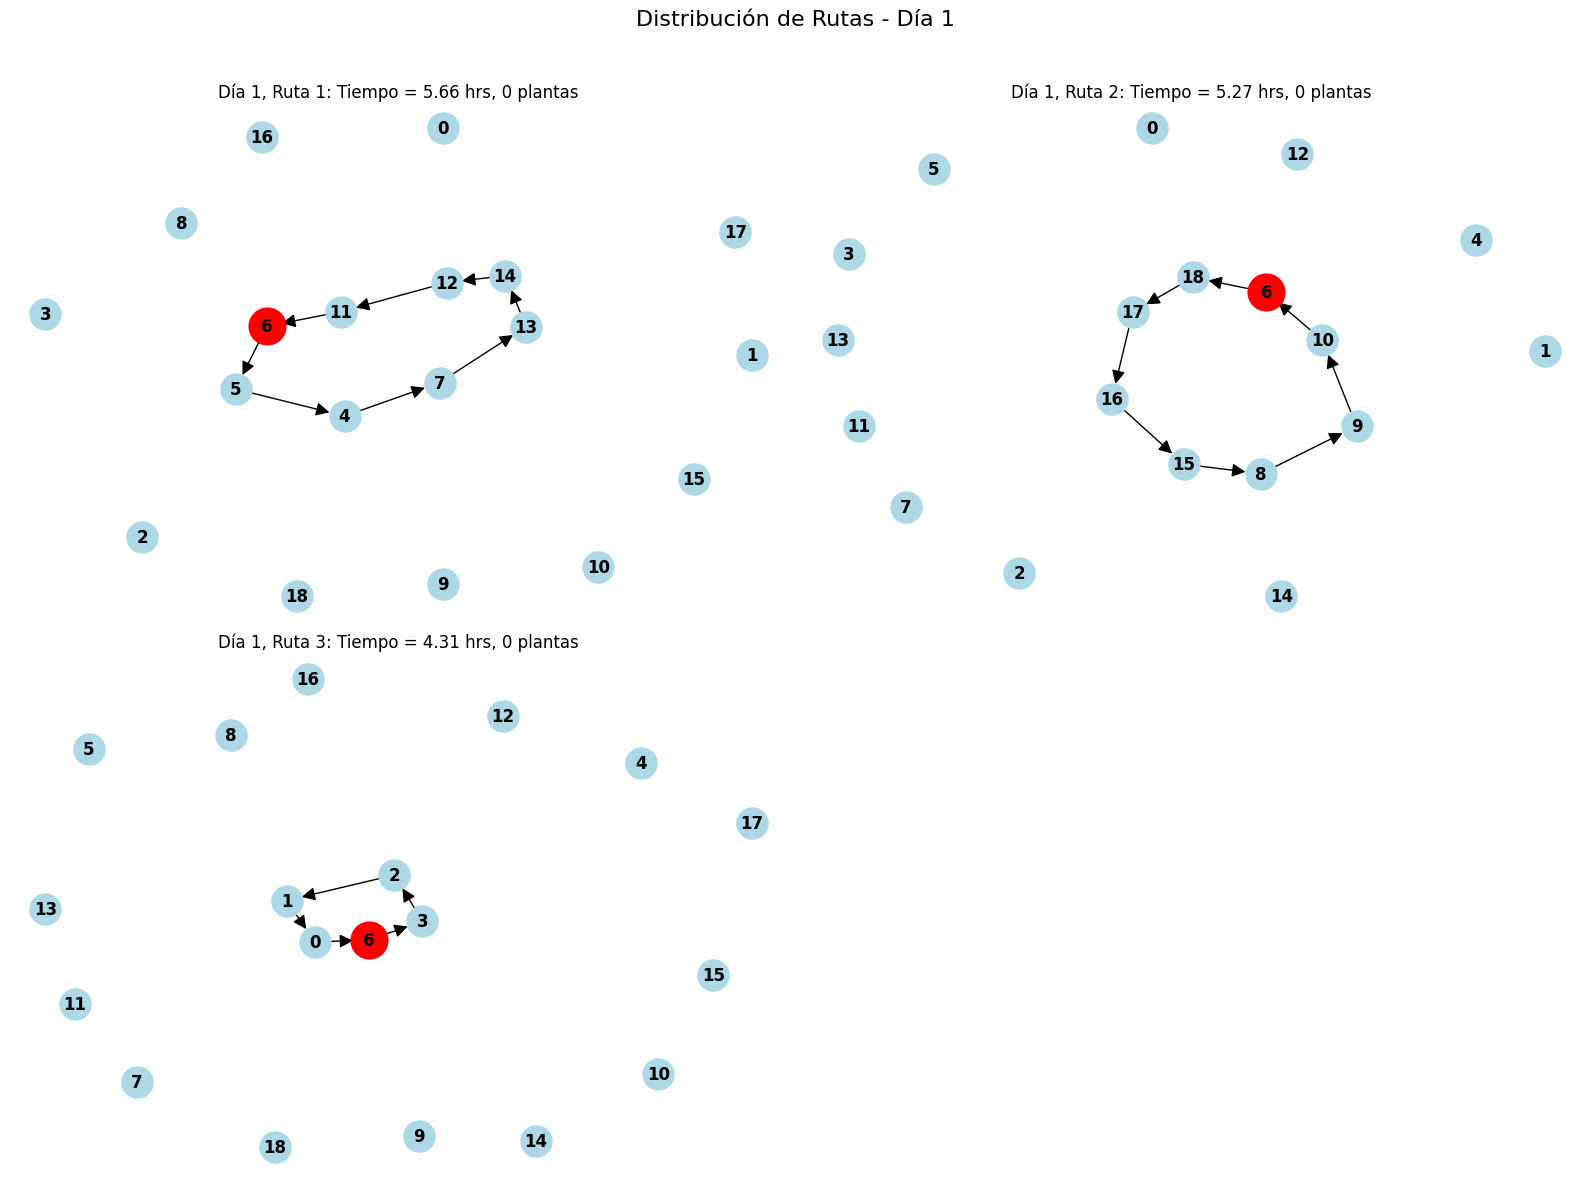


SIMULACIÓN DÍA 2

Calculating orders for delivery on Day 3
Current demand: [4112, 2492, 4112, 4112, 4861, 3738, 7226, 6357, 8599]
Demanda total: 45609, Capacidad máxima: 8000
⚠️ La demanda total (45609) excede la capacidad máxima (8000).
Se aplicará un ajuste proporcional a las cantidades solicitadas.
Capacidad utilizada: 7999.0 de 8000 (100.0%)

--- Análisis de Solución Greedy ---
Costo total: 193177.50
Costo de compra: 175177.50
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Distribución Detallada de Compras ---

especie 1:
  - Comprar 721 unidades a Laguna Seca (costo unitario: 26.00)

especie 2:
  - Comprar 437 unidades a Moctezuma (costo unitario: 26.00)

especie 3:
  - Comprar 721 unidades a Proveedor 4 (costo unitario: 25.00)

especie 4:
  - Comprar 721 unidades a Moctezuma (costo unitario: 17.00)

especie 5:
  - Comprar 853 unidades a Proveedor 4 (costo unitario: 18.00)

especie 6

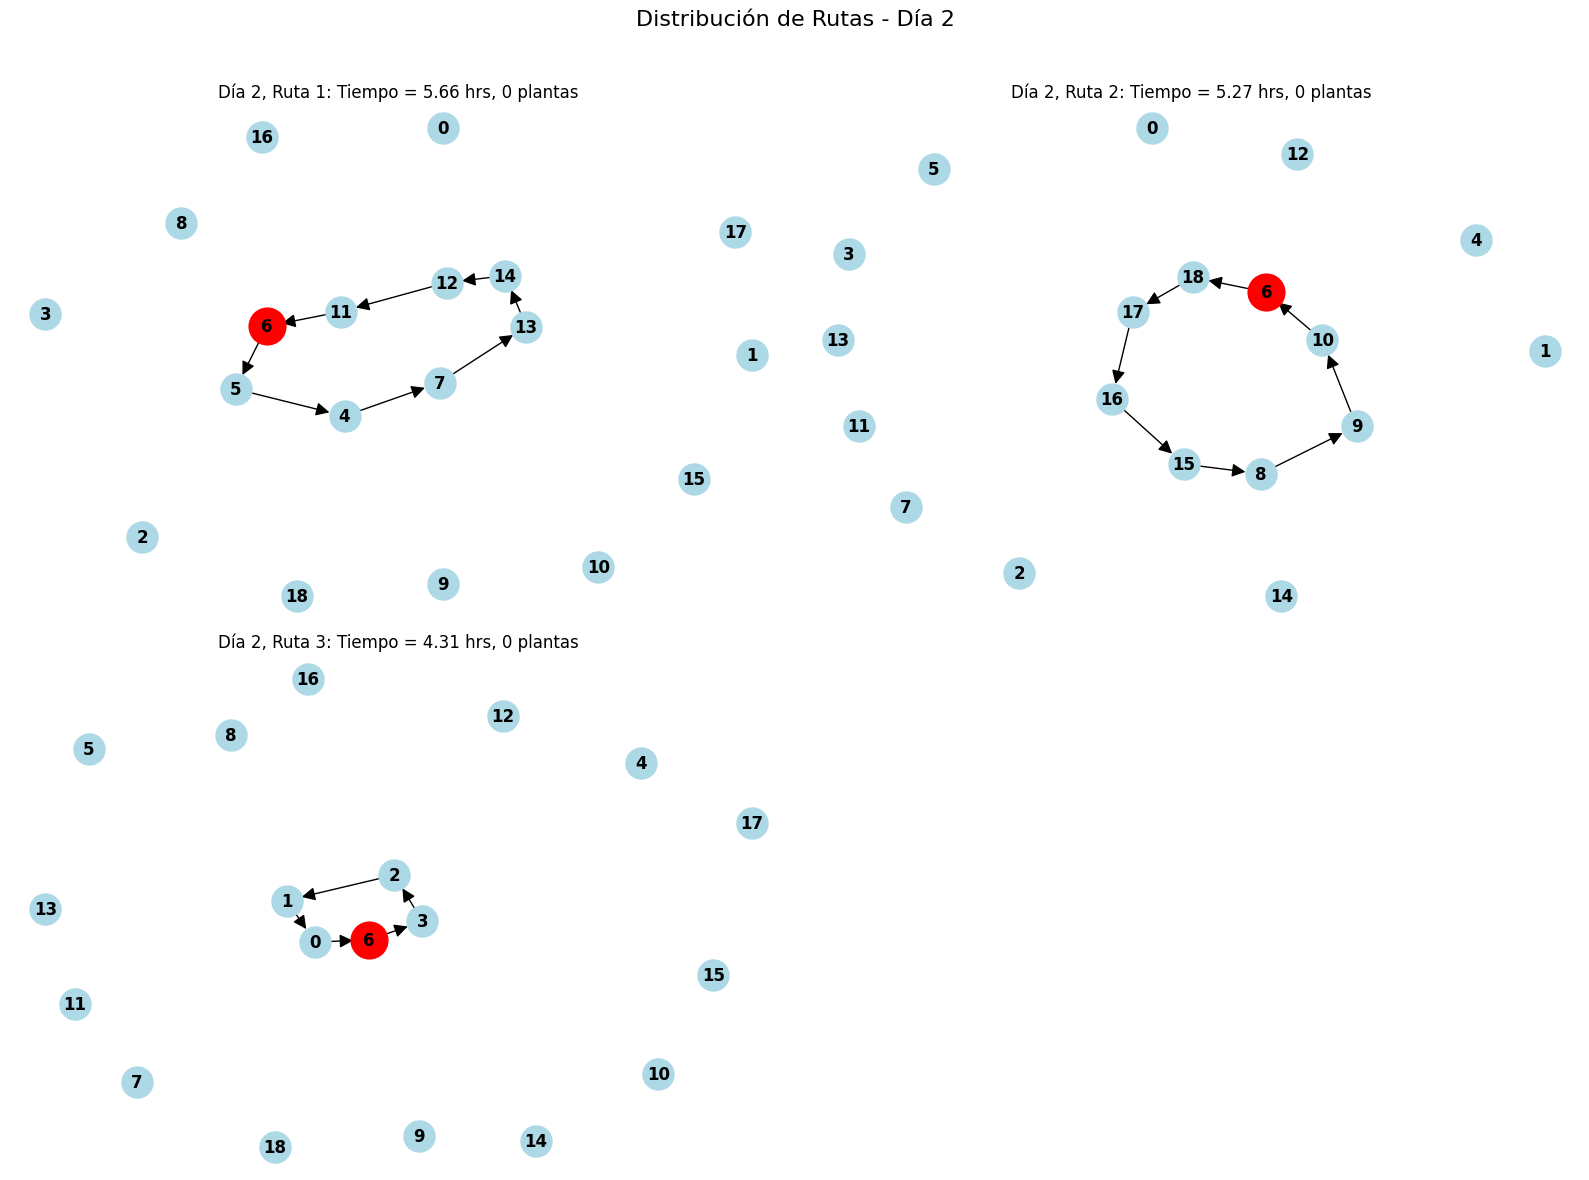


SIMULACIÓN DÍA 3

Calculating orders for delivery on Day 4
Current demand: [4112, 2492, 4112, 4112, 4861, 3738, 7226, 6357, 8599]
Demanda total: 45609, Capacidad máxima: 8000
⚠️ La demanda total (45609) excede la capacidad máxima (8000).
Se aplicará un ajuste proporcional a las cantidades solicitadas.
Capacidad utilizada: 7999.0 de 8000 (100.0%)

--- Análisis de Solución Greedy ---
Costo total: 193177.50
Costo de compra: 175177.50
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Distribución Detallada de Compras ---

especie 1:
  - Comprar 721 unidades a Laguna Seca (costo unitario: 26.00)

especie 2:
  - Comprar 437 unidades a Moctezuma (costo unitario: 26.00)

especie 3:
  - Comprar 721 unidades a Proveedor 4 (costo unitario: 25.00)

especie 4:
  - Comprar 721 unidades a Moctezuma (costo unitario: 17.00)

especie 5:
  - Comprar 853 unidades a Proveedor 4 (costo unitario: 18.00)

especie 6

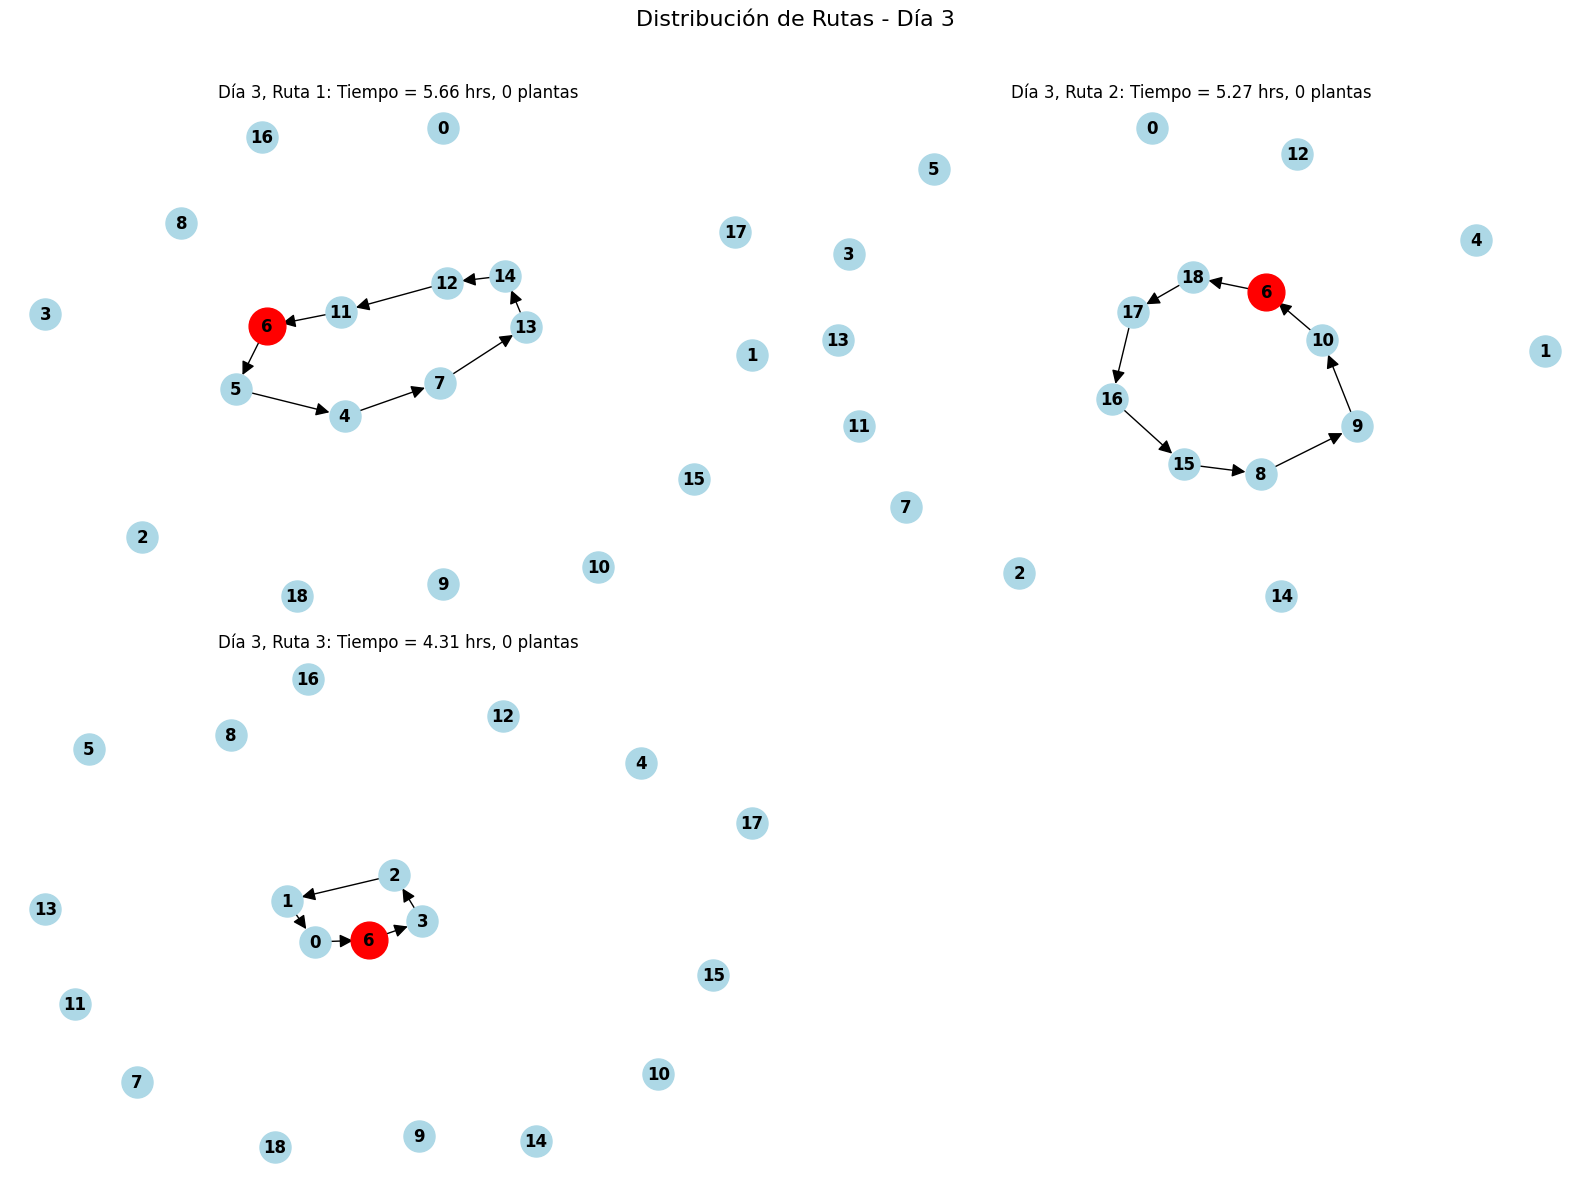


SIMULACIÓN DÍA 4

Calculating orders for delivery on Day 5
Current demand: [4112, 2492, 4112, 4112, 4861, 3738, 7226, 6357, 8599]
Demanda total: 45609, Capacidad máxima: 8000
⚠️ La demanda total (45609) excede la capacidad máxima (8000).
Se aplicará un ajuste proporcional a las cantidades solicitadas.
Capacidad utilizada: 7999.0 de 8000 (100.0%)

--- Análisis de Solución Greedy ---
Costo total: 193177.50
Costo de compra: 175177.50
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Distribución Detallada de Compras ---

especie 1:
  - Comprar 721 unidades a Laguna Seca (costo unitario: 26.00)

especie 2:
  - Comprar 437 unidades a Moctezuma (costo unitario: 26.00)

especie 3:
  - Comprar 721 unidades a Proveedor 4 (costo unitario: 25.00)

especie 4:
  - Comprar 721 unidades a Moctezuma (costo unitario: 17.00)

especie 5:
  - Comprar 853 unidades a Proveedor 4 (costo unitario: 18.00)

especie 6

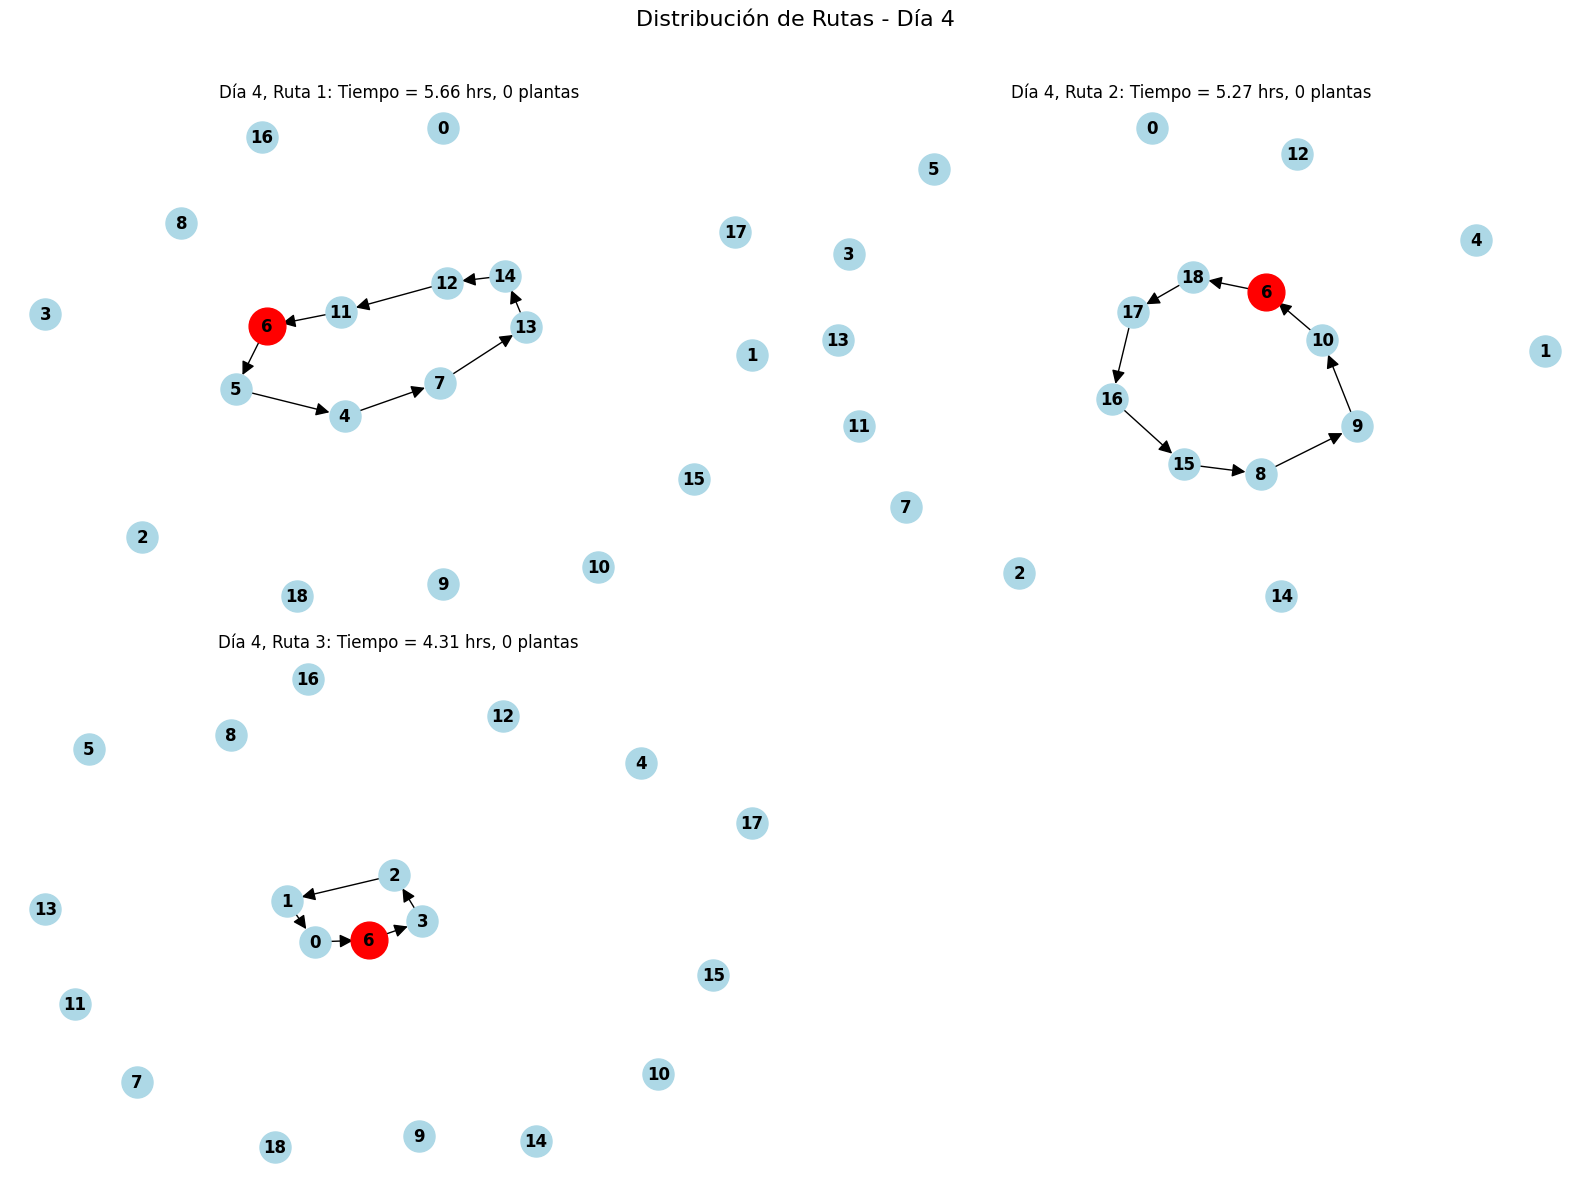


SIMULACIÓN DÍA 5

Calculating orders for delivery on Day 6
Current demand: [3972, 2407, 3972, 3972, 4694, 3611, 6977, 6140, 8301]
Demanda total: 44046, Capacidad máxima: 8000
⚠️ La demanda total (44046) excede la capacidad máxima (8000).
Se aplicará un ajuste proporcional a las cantidades solicitadas.
Capacidad utilizada: 7999.0 de 8000 (100.0%)

--- Análisis de Solución Greedy ---
Costo total: 193177.50
Costo de compra: 175177.50
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Distribución Detallada de Compras ---

especie 1:
  - Comprar 721 unidades a Laguna Seca (costo unitario: 26.00)

especie 2:
  - Comprar 437 unidades a Moctezuma (costo unitario: 26.00)

especie 3:
  - Comprar 721 unidades a Proveedor 4 (costo unitario: 25.00)

especie 4:
  - Comprar 721 unidades a Moctezuma (costo unitario: 17.00)

especie 5:
  - Comprar 853 unidades a Proveedor 4 (costo unitario: 18.00)

especie 6

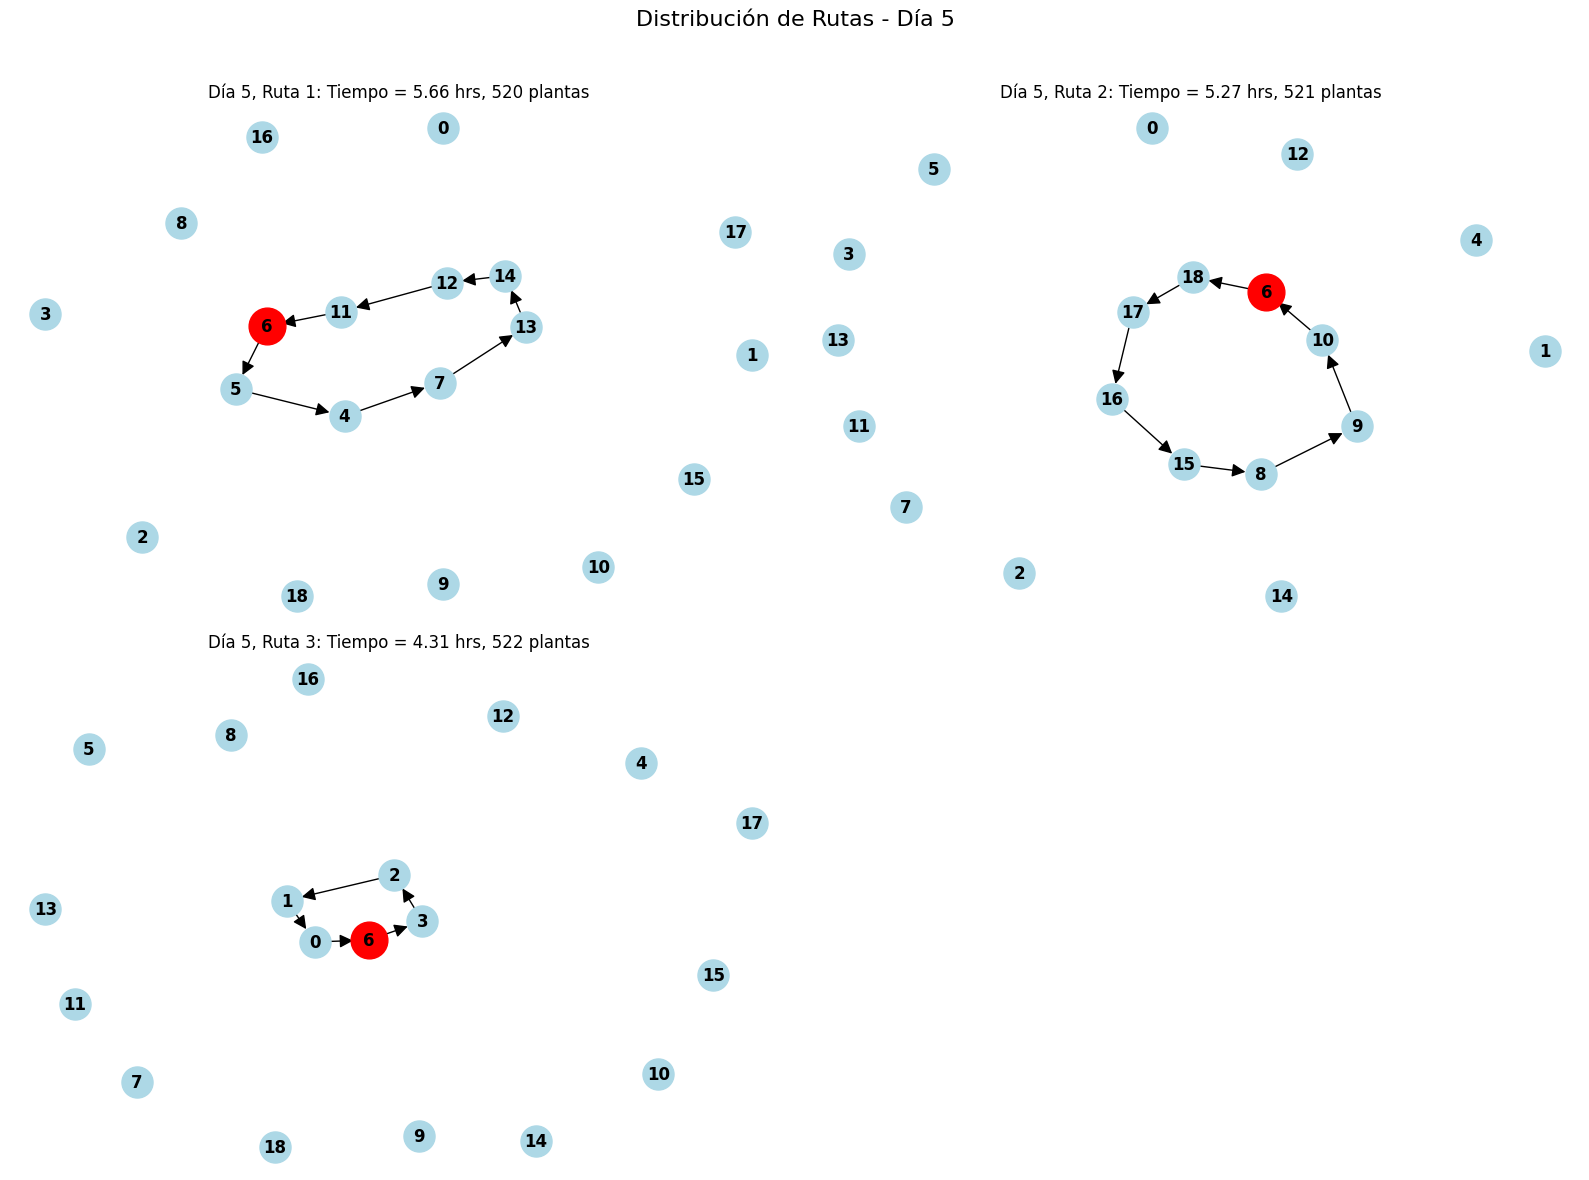


SIMULACIÓN DÍA 6

Calculating orders for delivery on Day 7
Current demand: [3831, 2323, 3831, 3831, 4526, 3484, 6728, 5923, 8003]
Demanda total: 42480, Capacidad máxima: 8000
⚠️ La demanda total (42480) excede la capacidad máxima (8000).
Se aplicará un ajuste proporcional a las cantidades solicitadas.
Capacidad utilizada: 7997.0 de 8000 (100.0%)

--- Análisis de Solución Greedy ---
Costo total: 193133.50
Costo de compra: 175133.50
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Distribución Detallada de Compras ---

especie 1:
  - Comprar 721 unidades a Laguna Seca (costo unitario: 26.00)

especie 2:
  - Comprar 437 unidades a Moctezuma (costo unitario: 26.00)

especie 3:
  - Comprar 721 unidades a Proveedor 4 (costo unitario: 25.00)

especie 4:
  - Comprar 721 unidades a Moctezuma (costo unitario: 17.00)

especie 5:
  - Comprar 852 unidades a Proveedor 4 (costo unitario: 18.00)

especie 6

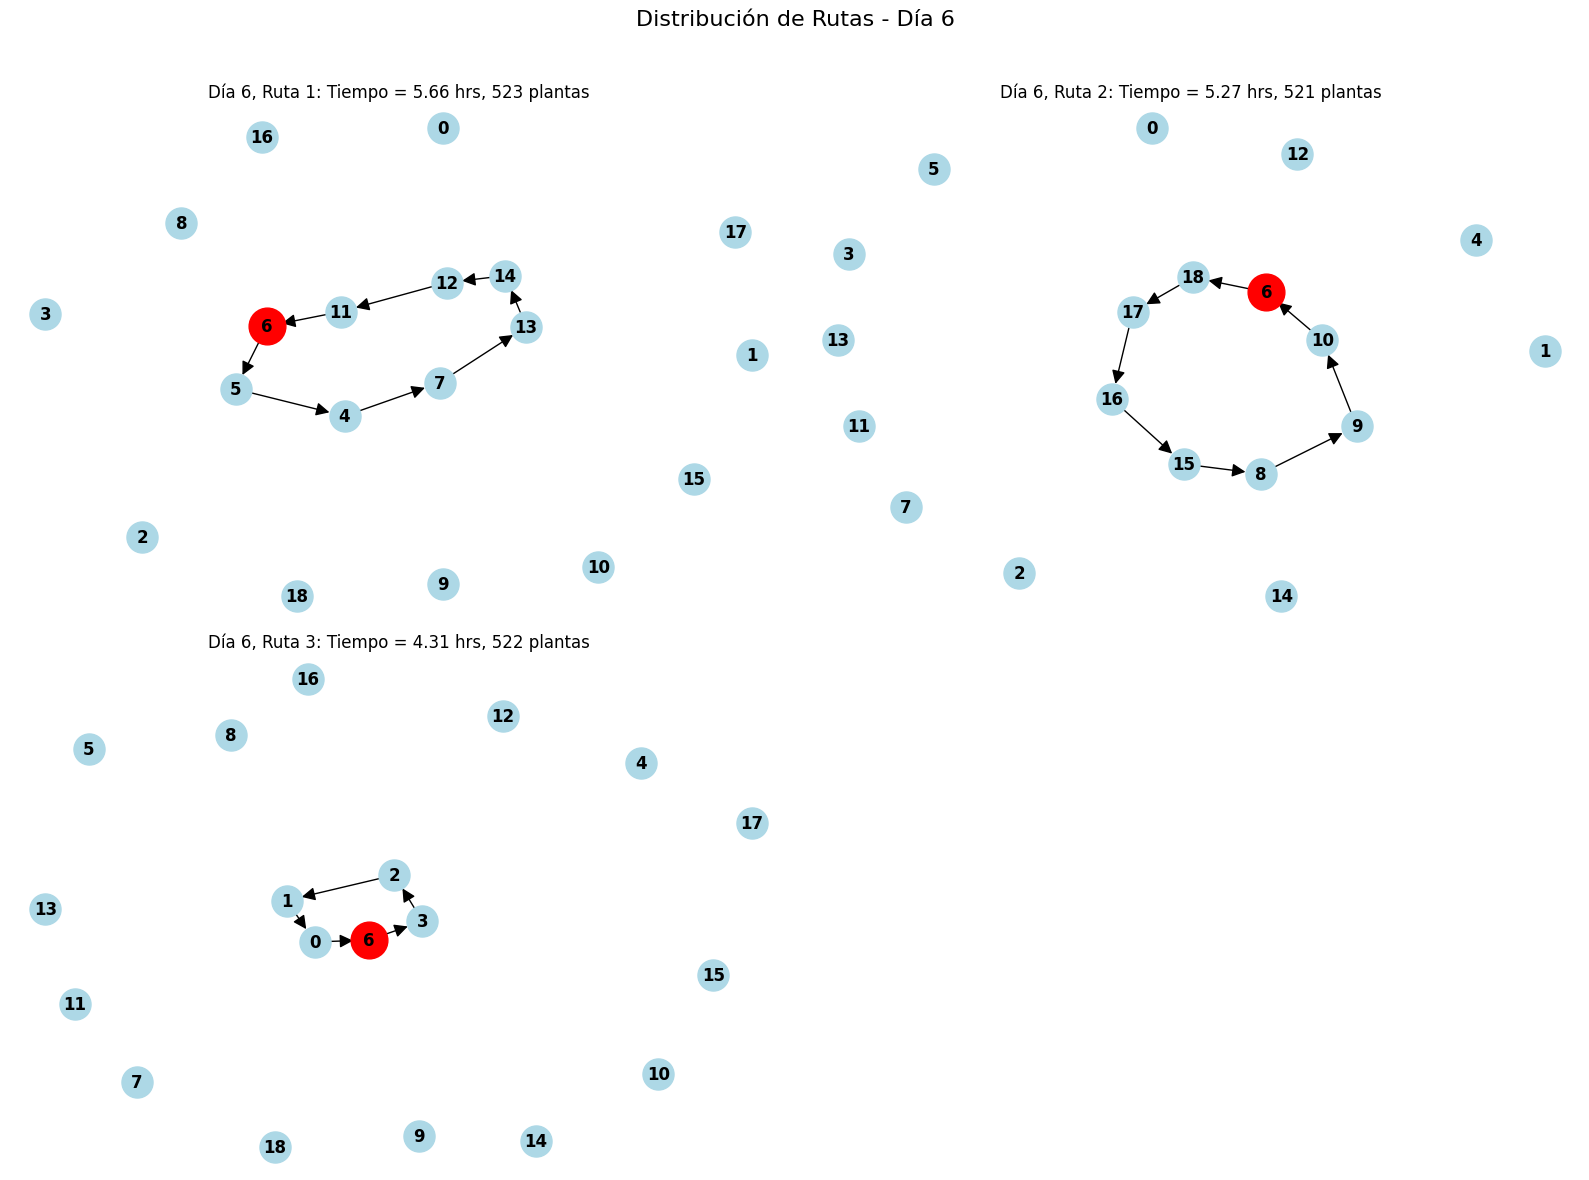


SIMULACIÓN DÍA 7

Calculating orders for delivery on Day 8
Current demand: [3689, 2238, 3689, 3689, 4359, 3357, 6478, 5705, 7705]
Demanda total: 40909, Capacidad máxima: 8000
⚠️ La demanda total (40909) excede la capacidad máxima (8000).
Se aplicará un ajuste proporcional a las cantidades solicitadas.
Capacidad utilizada: 7999.0 de 8000 (100.0%)

--- Análisis de Solución Greedy ---
Costo total: 193186.00
Costo de compra: 175186.00
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Distribución Detallada de Compras ---

especie 1:
  - Comprar 721 unidades a Laguna Seca (costo unitario: 26.00)

especie 2:
  - Comprar 438 unidades a Moctezuma (costo unitario: 26.00)

especie 3:
  - Comprar 721 unidades a Proveedor 4 (costo unitario: 25.00)

especie 4:
  - Comprar 721 unidades a Moctezuma (costo unitario: 17.00)

especie 5:
  - Comprar 852 unidades a Proveedor 4 (costo unitario: 18.00)

especie 6

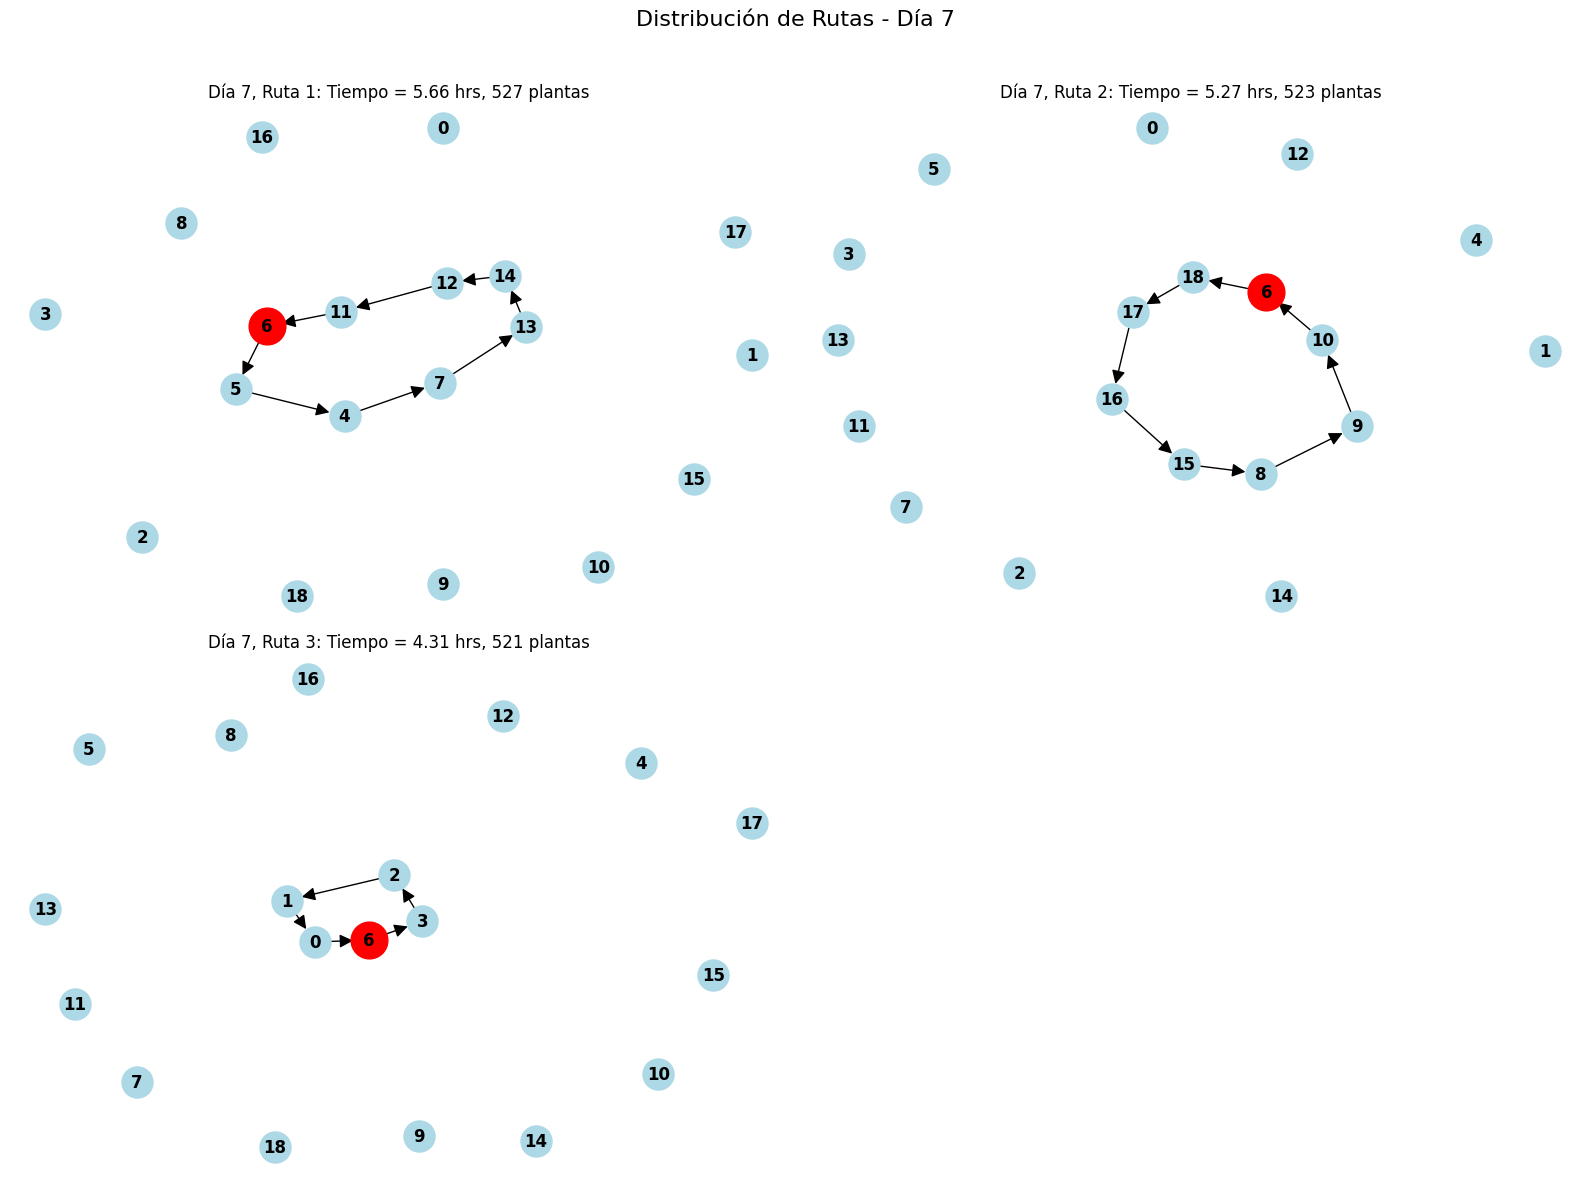


SIMULACIÓN DÍA 8

Calculating orders for delivery on Day 9
Current demand: [3548, 2153, 3548, 3548, 4191, 3230, 6229, 5489, 7407]
Demanda total: 39343, Capacidad máxima: 8000
⚠️ La demanda total (39343) excede la capacidad máxima (8000).
Se aplicará un ajuste proporcional a las cantidades solicitadas.
Capacidad utilizada: 7999.0 de 8000 (100.0%)

--- Análisis de Solución Greedy ---
Costo total: 193172.00
Costo de compra: 175172.00
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Distribución Detallada de Compras ---

especie 1:
  - Comprar 721 unidades a Laguna Seca (costo unitario: 26.00)

especie 2:
  - Comprar 438 unidades a Moctezuma (costo unitario: 26.00)

especie 3:
  - Comprar 721 unidades a Proveedor 4 (costo unitario: 25.00)

especie 4:
  - Comprar 721 unidades a Moctezuma (costo unitario: 17.00)

especie 5:
  - Comprar 852 unidades a Proveedor 4 (costo unitario: 18.00)

especie 6

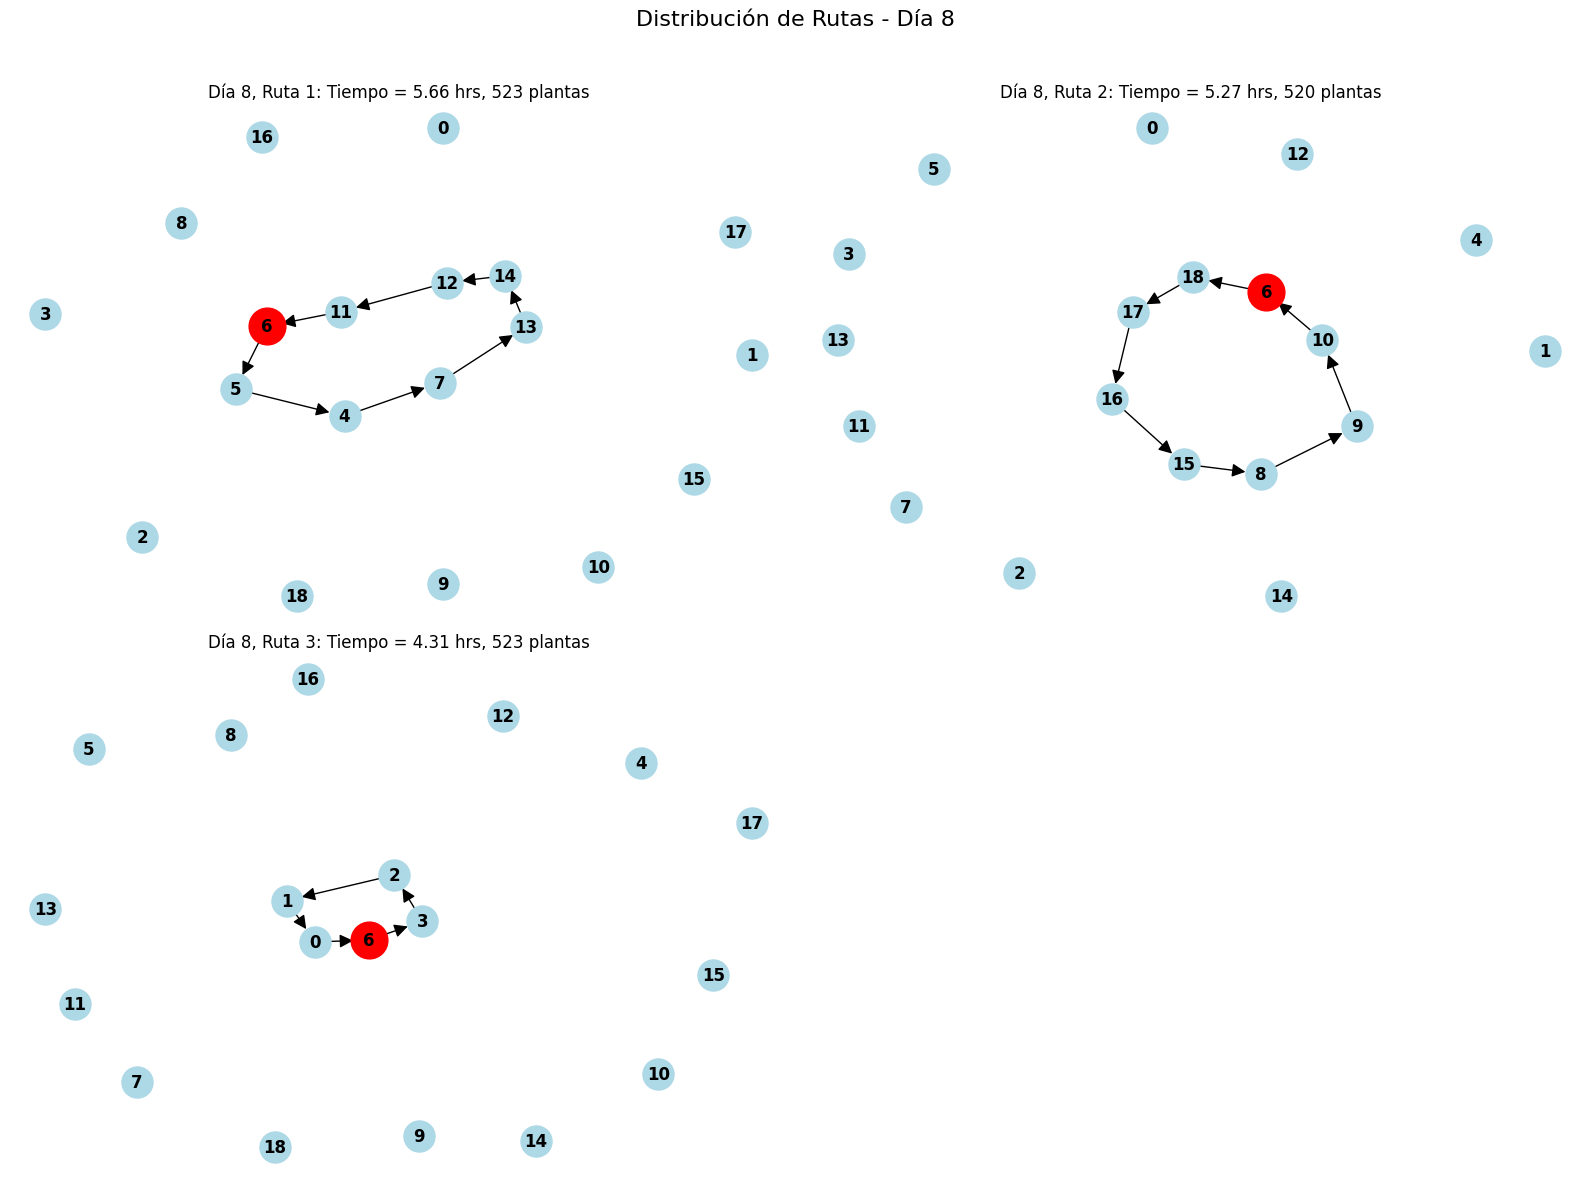


SIMULACIÓN DÍA 9

Calculating orders for delivery on Day 10
Current demand: [3406, 2067, 3406, 3406, 4025, 3104, 5980, 5272, 7110]
Demanda total: 37776, Capacidad máxima: 8000
⚠️ La demanda total (37776) excede la capacidad máxima (8000).
Se aplicará un ajuste proporcional a las cantidades solicitadas.
Capacidad utilizada: 7998.0 de 8000 (100.0%)

--- Análisis de Solución Greedy ---
Costo total: 193154.00
Costo de compra: 175154.00
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Distribución Detallada de Compras ---

especie 1:
  - Comprar 721 unidades a Laguna Seca (costo unitario: 26.00)

especie 2:
  - Comprar 438 unidades a Moctezuma (costo unitario: 26.00)

especie 3:
  - Comprar 721 unidades a Proveedor 4 (costo unitario: 25.00)

especie 4:
  - Comprar 721 unidades a Moctezuma (costo unitario: 17.00)

especie 5:
  - Comprar 852 unidades a Proveedor 4 (costo unitario: 18.00)

especie 

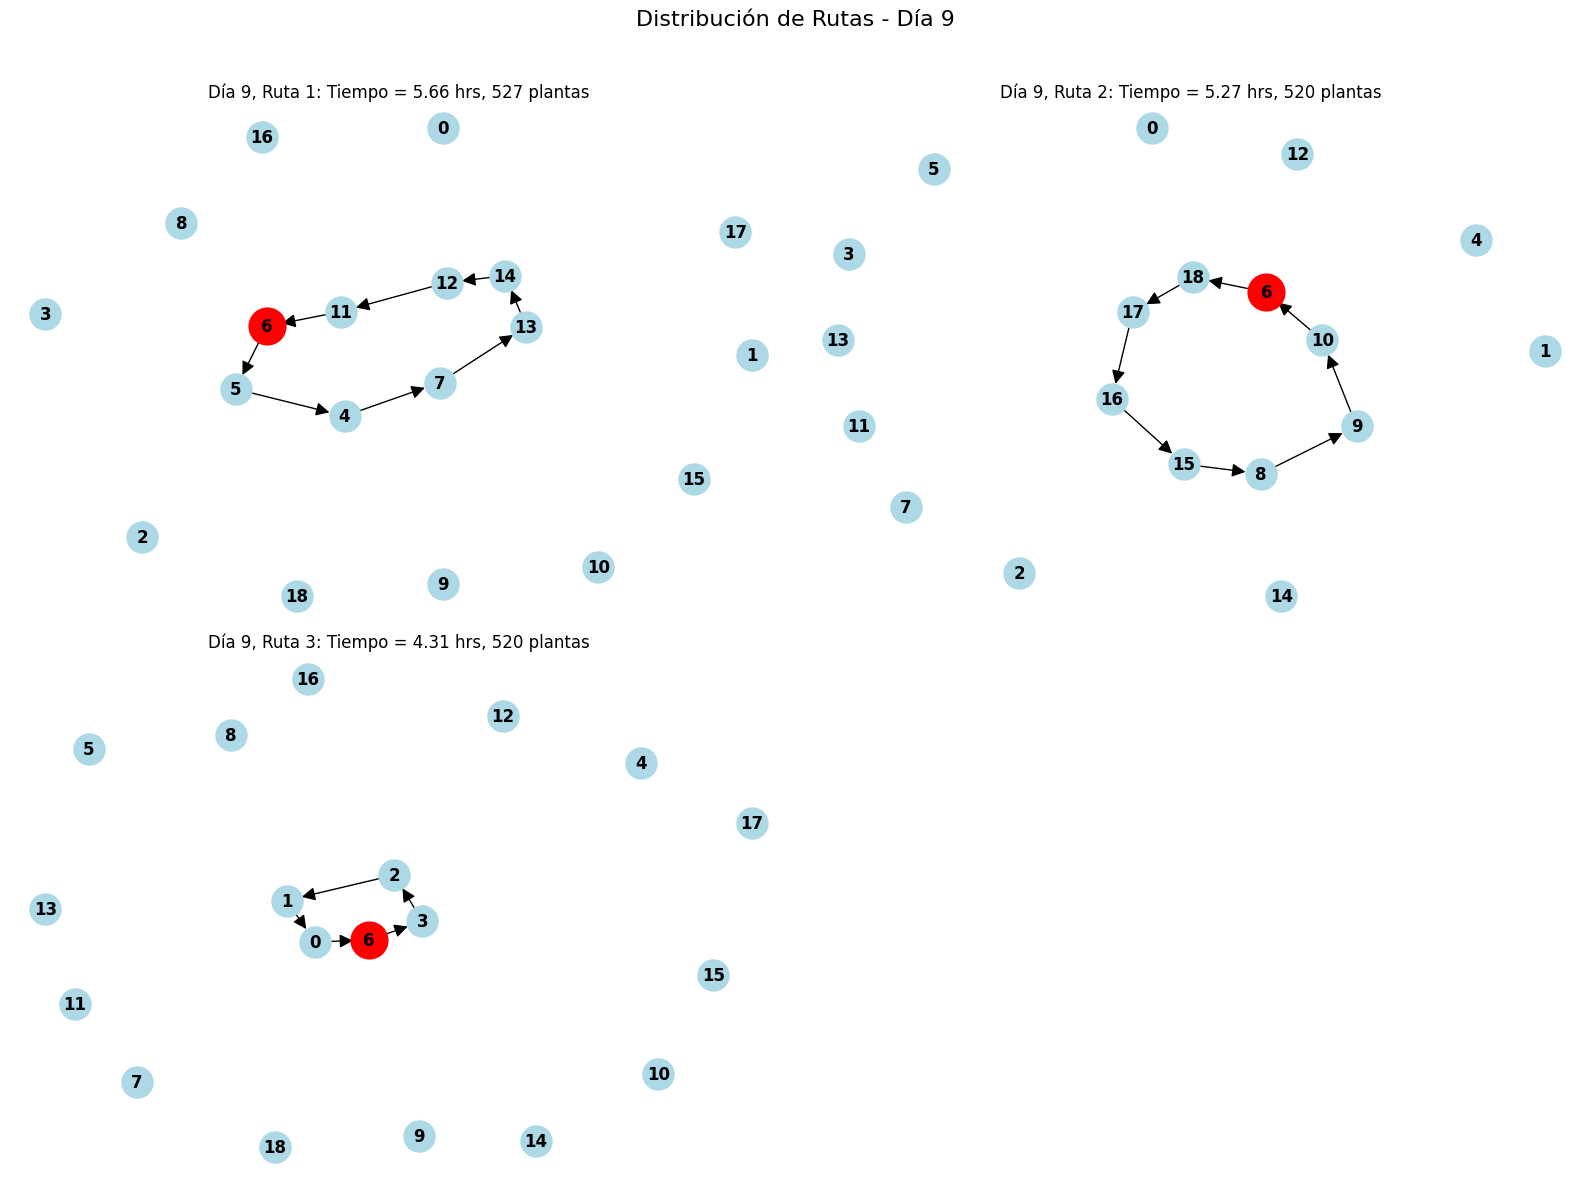


SIMULACIÓN DÍA 10

Calculating orders for delivery on Day 11
Current demand: [3264, 1982, 3264, 3264, 3858, 2977, 5731, 5054, 6814]
Demanda total: 36208, Capacidad máxima: 8000
⚠️ La demanda total (36208) excede la capacidad máxima (8000).
Se aplicará un ajuste proporcional a las cantidades solicitadas.
Capacidad utilizada: 8000.0 de 8000 (100.0%)

--- Análisis de Solución Greedy ---
Costo total: 193192.50
Costo de compra: 175192.50
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Distribución Detallada de Compras ---

especie 1:
  - Comprar 721 unidades a Laguna Seca (costo unitario: 26.00)

especie 2:
  - Comprar 438 unidades a Moctezuma (costo unitario: 26.00)

especie 3:
  - Comprar 721 unidades a Proveedor 4 (costo unitario: 25.00)

especie 4:
  - Comprar 721 unidades a Moctezuma (costo unitario: 17.00)

especie 5:
  - Comprar 852 unidades a Proveedor 4 (costo unitario: 18.00)

especie

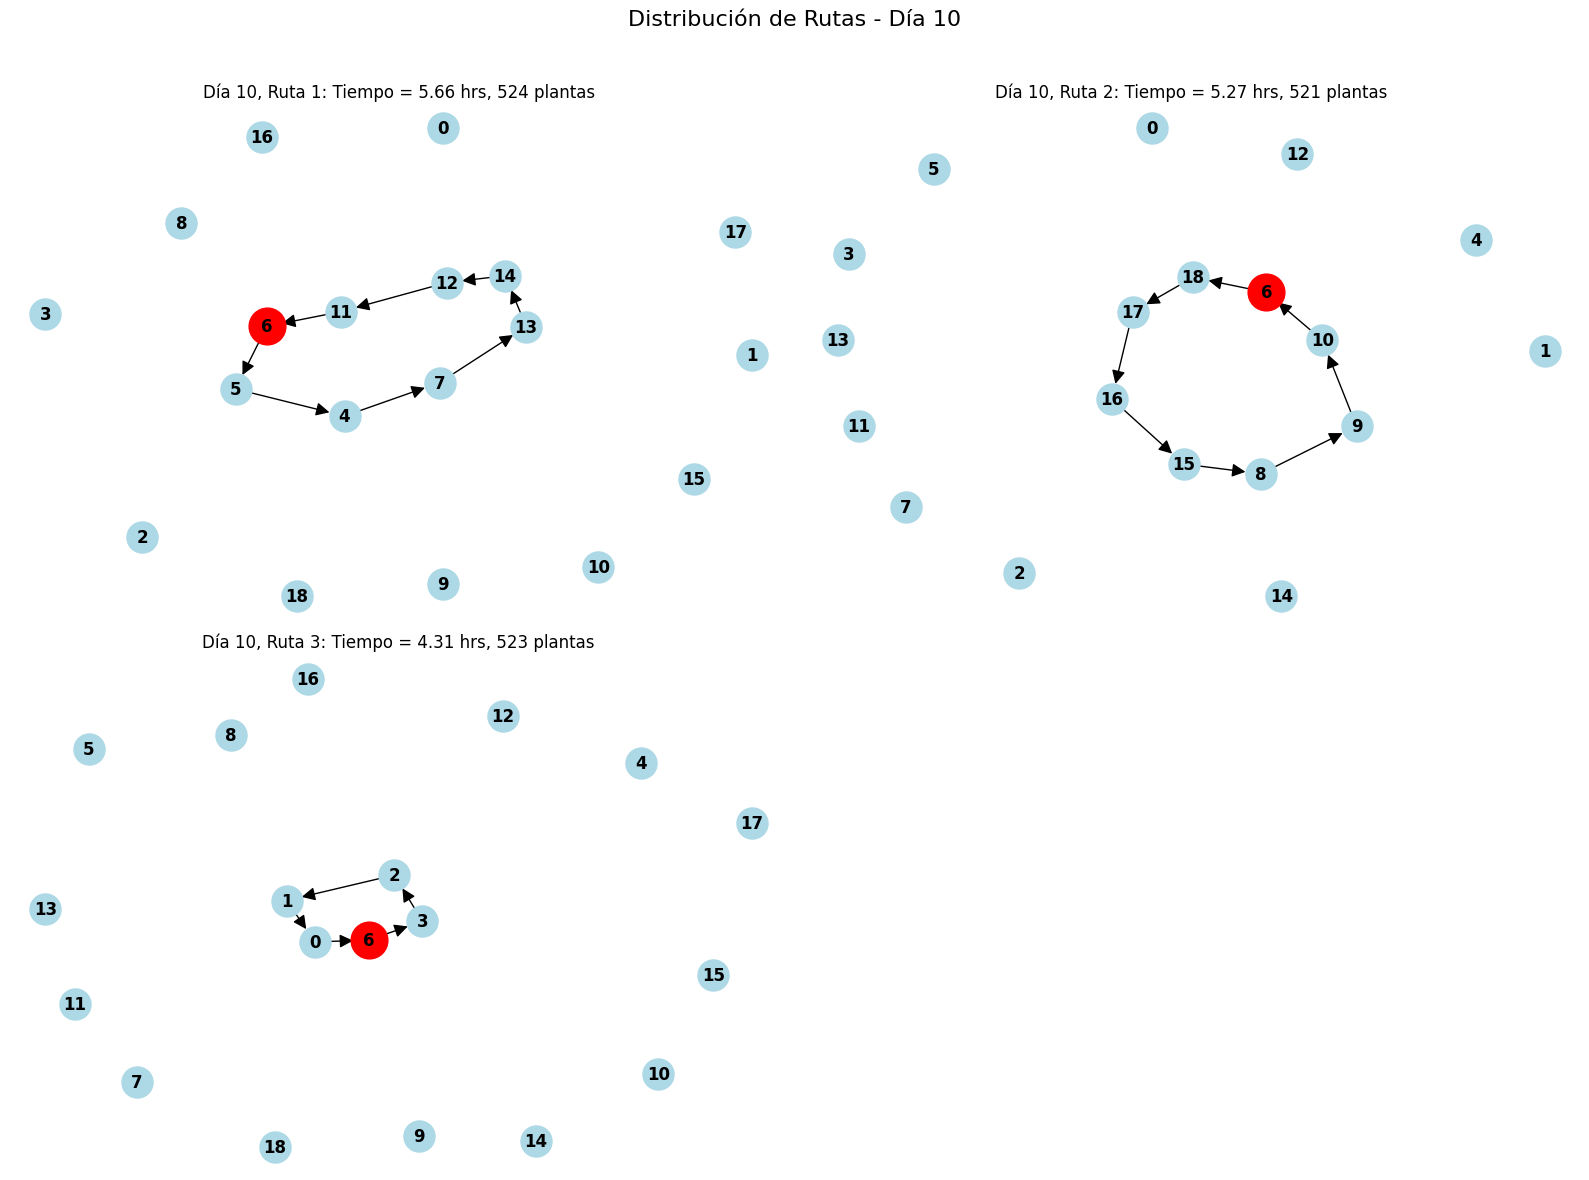


SIMULACIÓN DÍA 11

Calculating orders for delivery on Day 12
Current demand: [3122, 1896, 3122, 3122, 3690, 2849, 5482, 4836, 6517]
Demanda total: 34636, Capacidad máxima: 8000
⚠️ La demanda total (34636) excede la capacidad máxima (8000).
Se aplicará un ajuste proporcional a las cantidades solicitadas.
Capacidad utilizada: 7999.0 de 8000 (100.0%)

--- Análisis de Solución Greedy ---
Costo total: 193166.50
Costo de compra: 175166.50
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Distribución Detallada de Compras ---

especie 1:
  - Comprar 721 unidades a Laguna Seca (costo unitario: 26.00)

especie 2:
  - Comprar 438 unidades a Moctezuma (costo unitario: 26.00)

especie 3:
  - Comprar 721 unidades a Proveedor 4 (costo unitario: 25.00)

especie 4:
  - Comprar 721 unidades a Moctezuma (costo unitario: 17.00)

especie 5:
  - Comprar 852 unidades a Proveedor 4 (costo unitario: 18.00)

especie

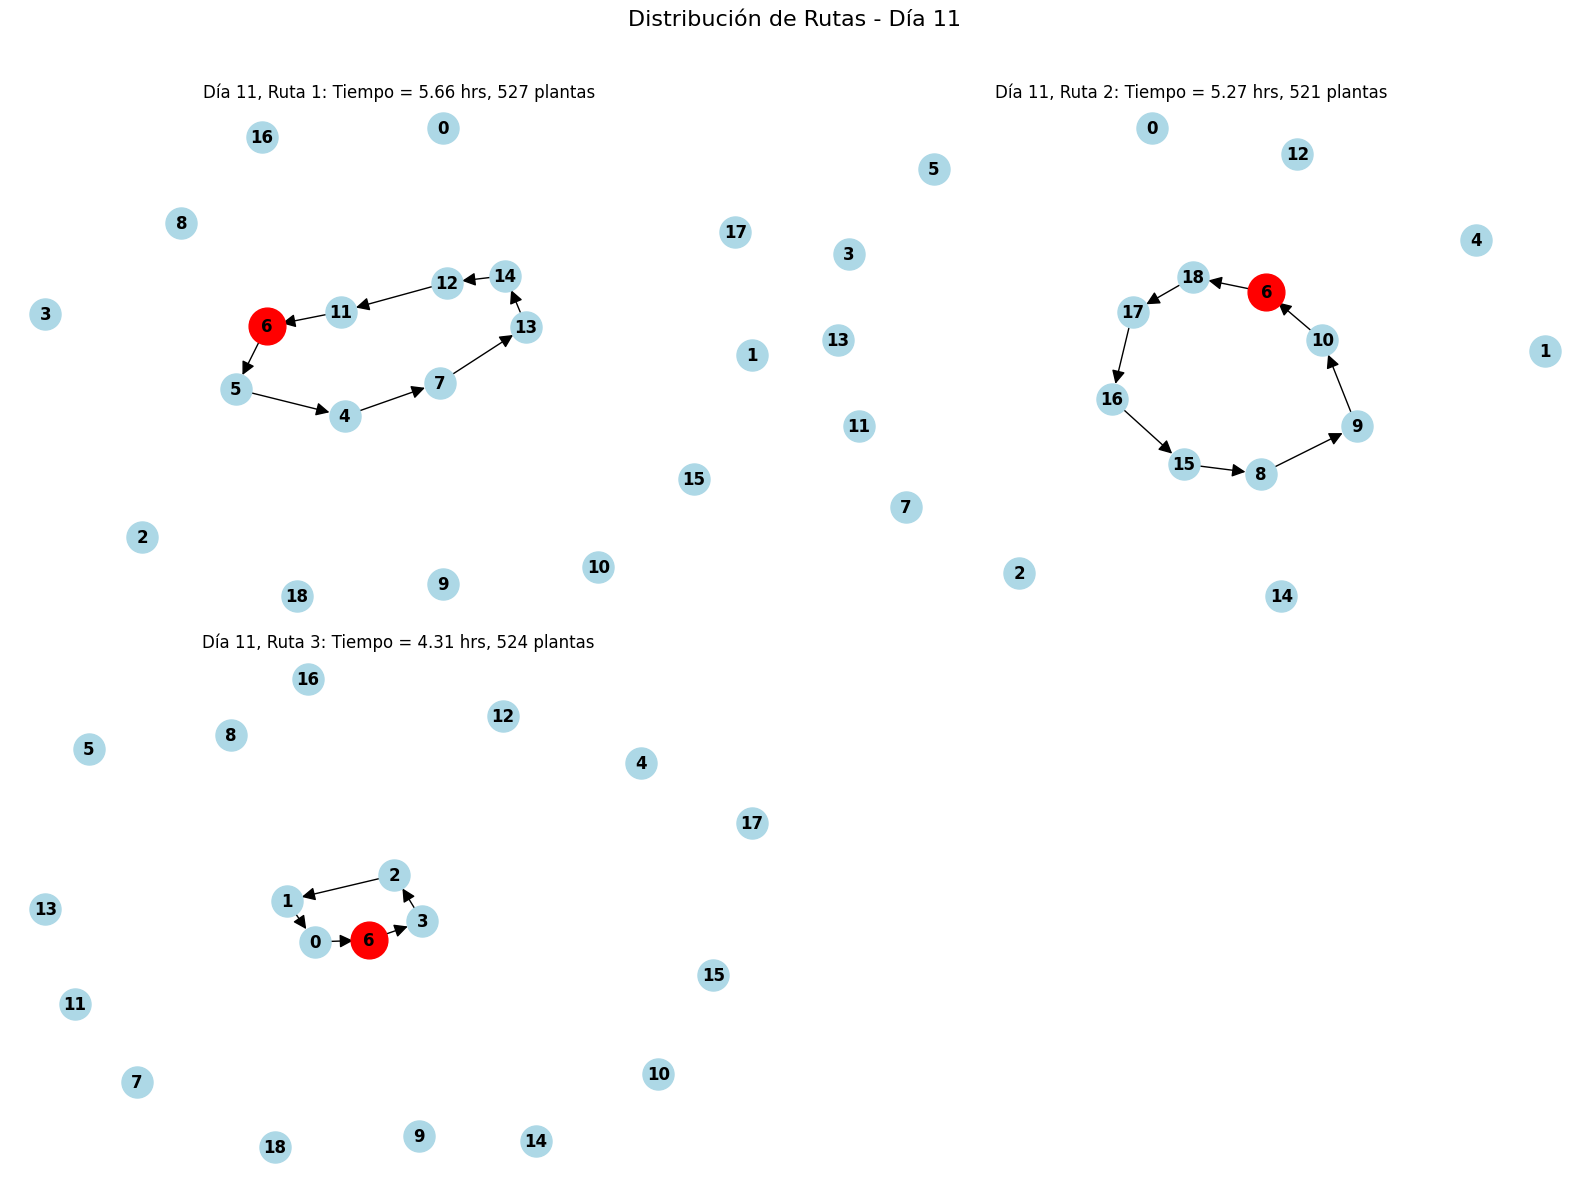


SIMULACIÓN DÍA 12

Calculating orders for delivery on Day 13
Current demand: [2979, 1811, 2979, 2979, 3523, 2722, 5232, 4617, 6221]
Demanda total: 33063, Capacidad máxima: 8000
⚠️ La demanda total (33063) excede la capacidad máxima (8000).
Se aplicará un ajuste proporcional a las cantidades solicitadas.
Capacidad utilizada: 8000.0 de 8000 (100.0%)

--- Análisis de Solución Greedy ---
Costo total: 193178.50
Costo de compra: 175178.50
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Distribución Detallada de Compras ---

especie 1:
  - Comprar 721 unidades a Laguna Seca (costo unitario: 26.00)

especie 2:
  - Comprar 438 unidades a Moctezuma (costo unitario: 26.00)

especie 3:
  - Comprar 721 unidades a Proveedor 4 (costo unitario: 25.00)

especie 4:
  - Comprar 721 unidades a Moctezuma (costo unitario: 17.00)

especie 5:
  - Comprar 852 unidades a Proveedor 4 (costo unitario: 18.00)

especie

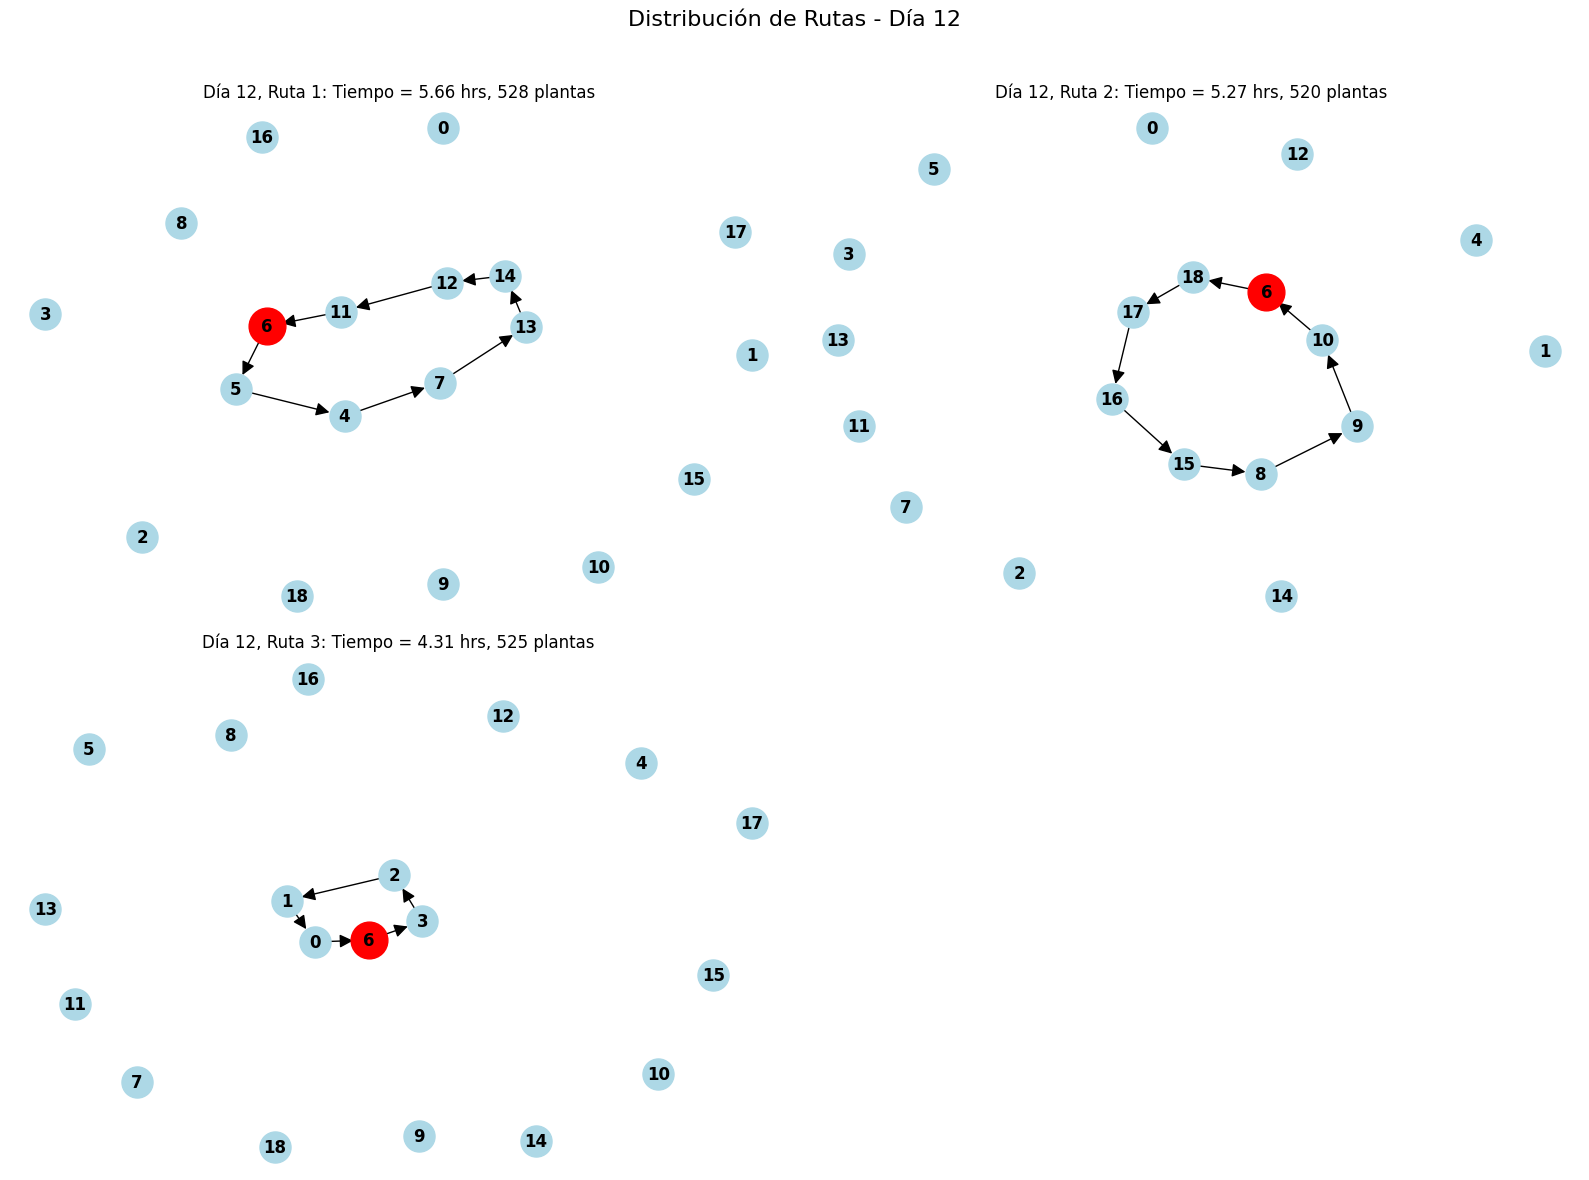


SIMULACIÓN DÍA 13

Calculating orders for delivery on Day 14
Current demand: [2838, 1725, 2838, 2838, 3356, 2594, 4983, 4400, 5923]
Demanda total: 31495, Capacidad máxima: 8000
⚠️ La demanda total (31495) excede la capacidad máxima (8000).
Se aplicará un ajuste proporcional a las cantidades solicitadas.
Capacidad utilizada: 8000.0 de 8000 (100.0%)

--- Análisis de Solución Greedy ---
Costo total: 193179.00
Costo de compra: 175179.00
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Distribución Detallada de Compras ---

especie 1:
  - Comprar 721 unidades a Laguna Seca (costo unitario: 26.00)

especie 2:
  - Comprar 438 unidades a Moctezuma (costo unitario: 26.00)

especie 3:
  - Comprar 721 unidades a Proveedor 4 (costo unitario: 25.00)

especie 4:
  - Comprar 721 unidades a Moctezuma (costo unitario: 17.00)

especie 5:
  - Comprar 852 unidades a Proveedor 4 (costo unitario: 18.00)

especie

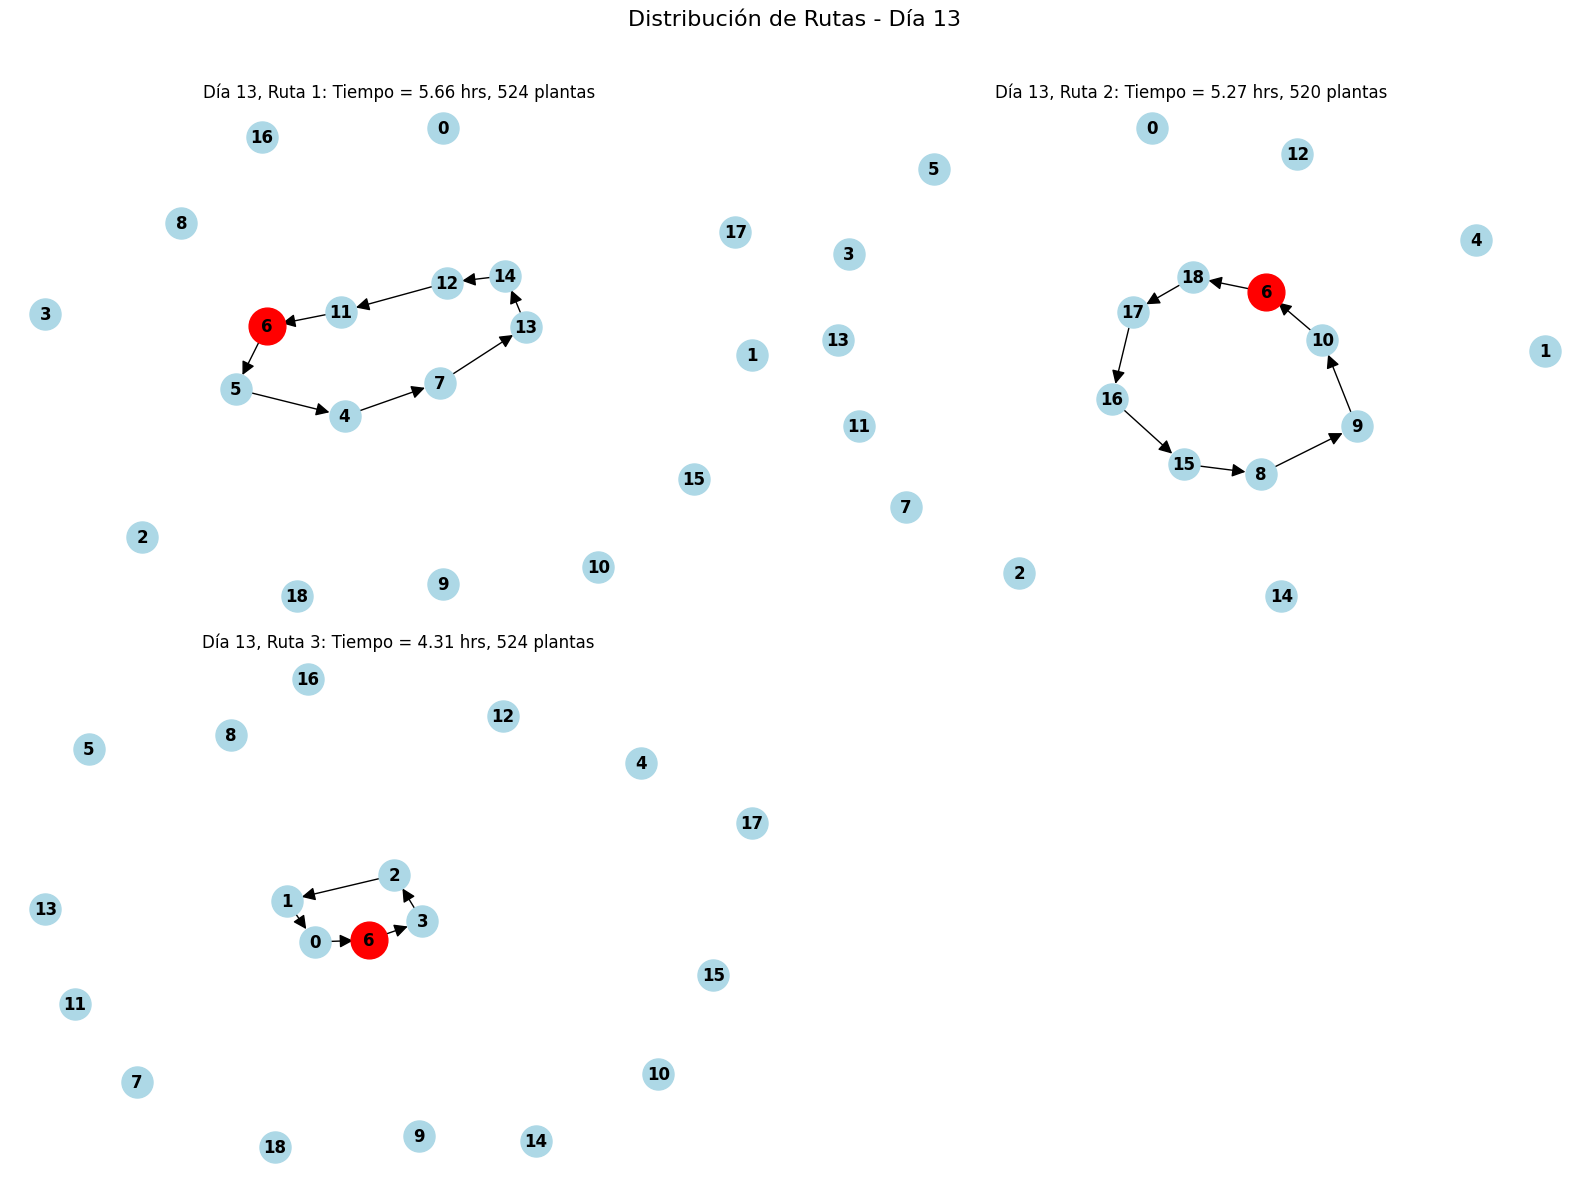


SIMULACIÓN DÍA 14

Calculating orders for delivery on Day 15
Current demand: [2695, 1637, 2695, 2695, 3190, 2466, 4734, 4179, 5626]
Demanda total: 29917, Capacidad máxima: 8000
⚠️ La demanda total (29917) excede la capacidad máxima (8000).
Se aplicará un ajuste proporcional a las cantidades solicitadas.
Capacidad utilizada: 8000.0 de 8000 (100.0%)

--- Análisis de Solución Greedy ---
Costo total: 193170.50
Costo de compra: 175170.50
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Distribución Detallada de Compras ---

especie 1:
  - Comprar 721 unidades a Laguna Seca (costo unitario: 26.00)

especie 2:
  - Comprar 438 unidades a Moctezuma (costo unitario: 26.00)

especie 3:
  - Comprar 721 unidades a Proveedor 4 (costo unitario: 25.00)

especie 4:
  - Comprar 721 unidades a Moctezuma (costo unitario: 17.00)

especie 5:
  - Comprar 853 unidades a Proveedor 4 (costo unitario: 18.00)

especie

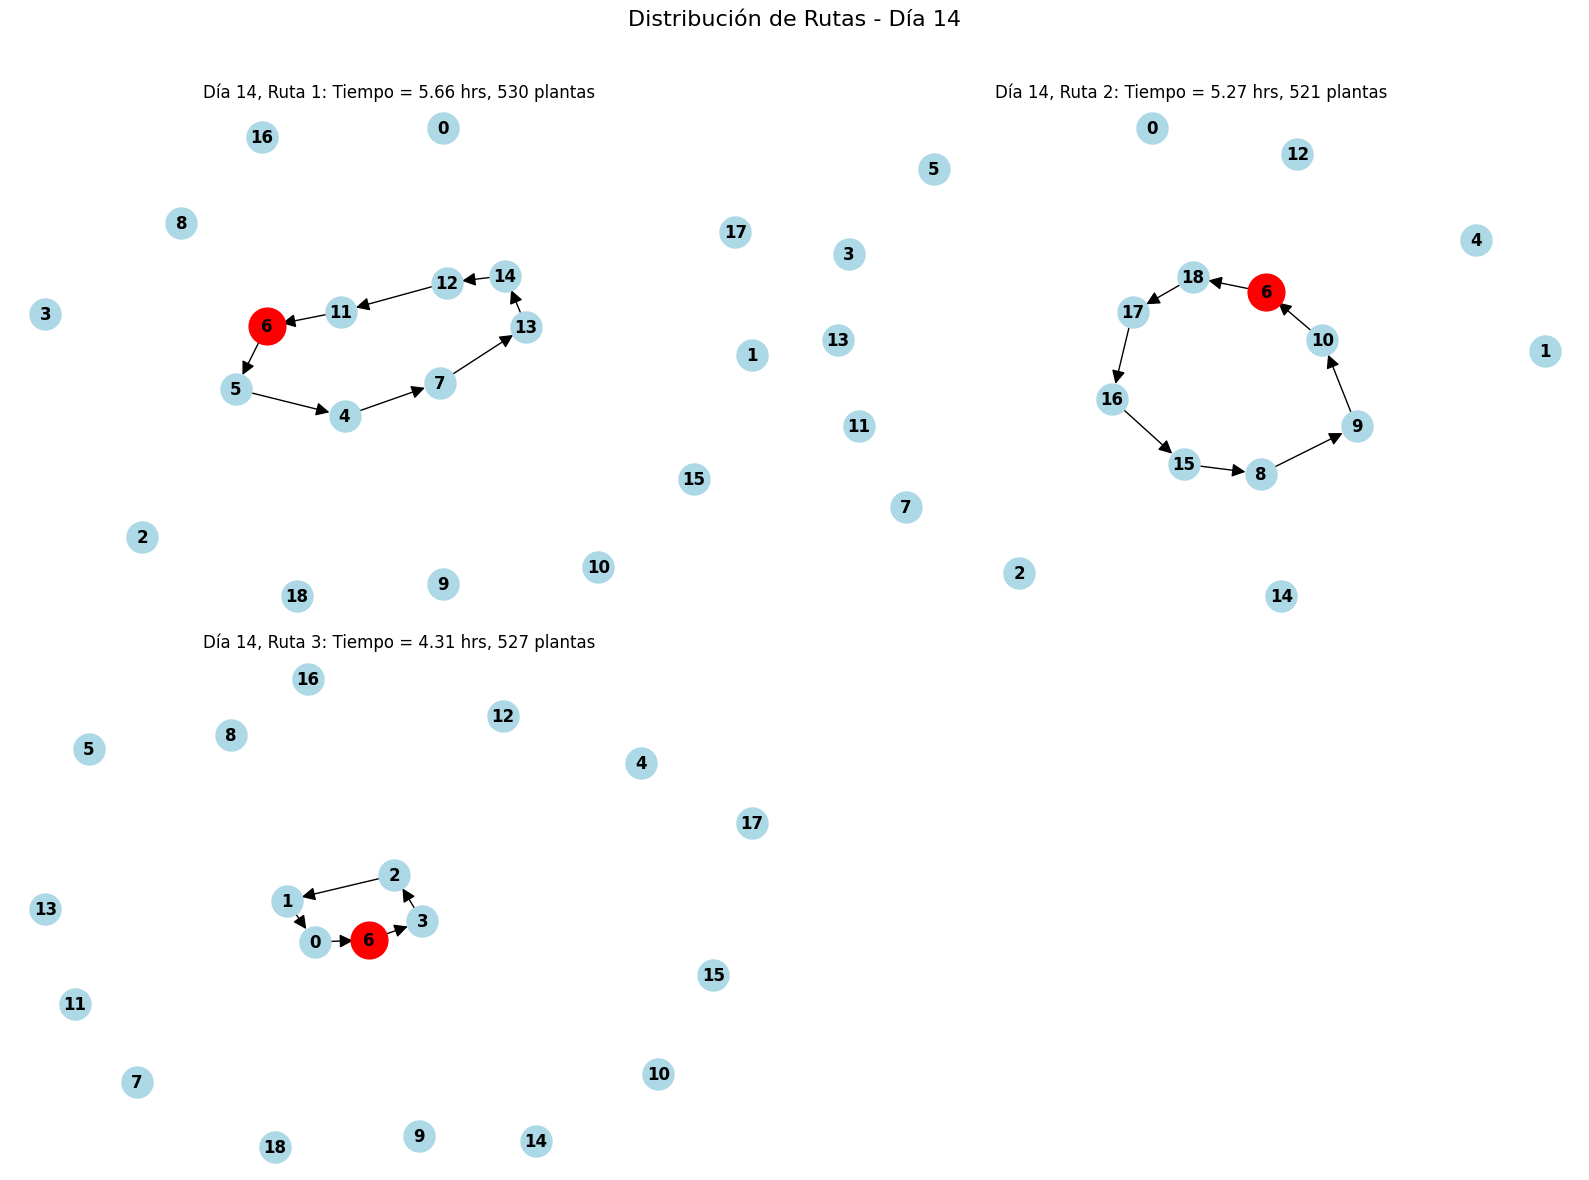


SIMULACIÓN DÍA 15

Calculating orders for delivery on Day 16
Current demand: [2554, 1551, 2554, 2554, 3022, 2338, 4484, 3962, 5330]
Demanda total: 28349, Capacidad máxima: 8000
⚠️ La demanda total (28349) excede la capacidad máxima (8000).
Se aplicará un ajuste proporcional a las cantidades solicitadas.
Capacidad utilizada: 8001.0 de 8000 (100.0%)

--- Análisis de Solución Greedy ---
Costo total: 193191.00
Costo de compra: 175191.00
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Distribución Detallada de Compras ---

especie 1:
  - Comprar 721 unidades a Laguna Seca (costo unitario: 26.00)

especie 2:
  - Comprar 438 unidades a Moctezuma (costo unitario: 26.00)

especie 3:
  - Comprar 721 unidades a Proveedor 4 (costo unitario: 25.00)

especie 4:
  - Comprar 721 unidades a Moctezuma (costo unitario: 17.00)

especie 5:
  - Comprar 853 unidades a Proveedor 4 (costo unitario: 18.00)

especie

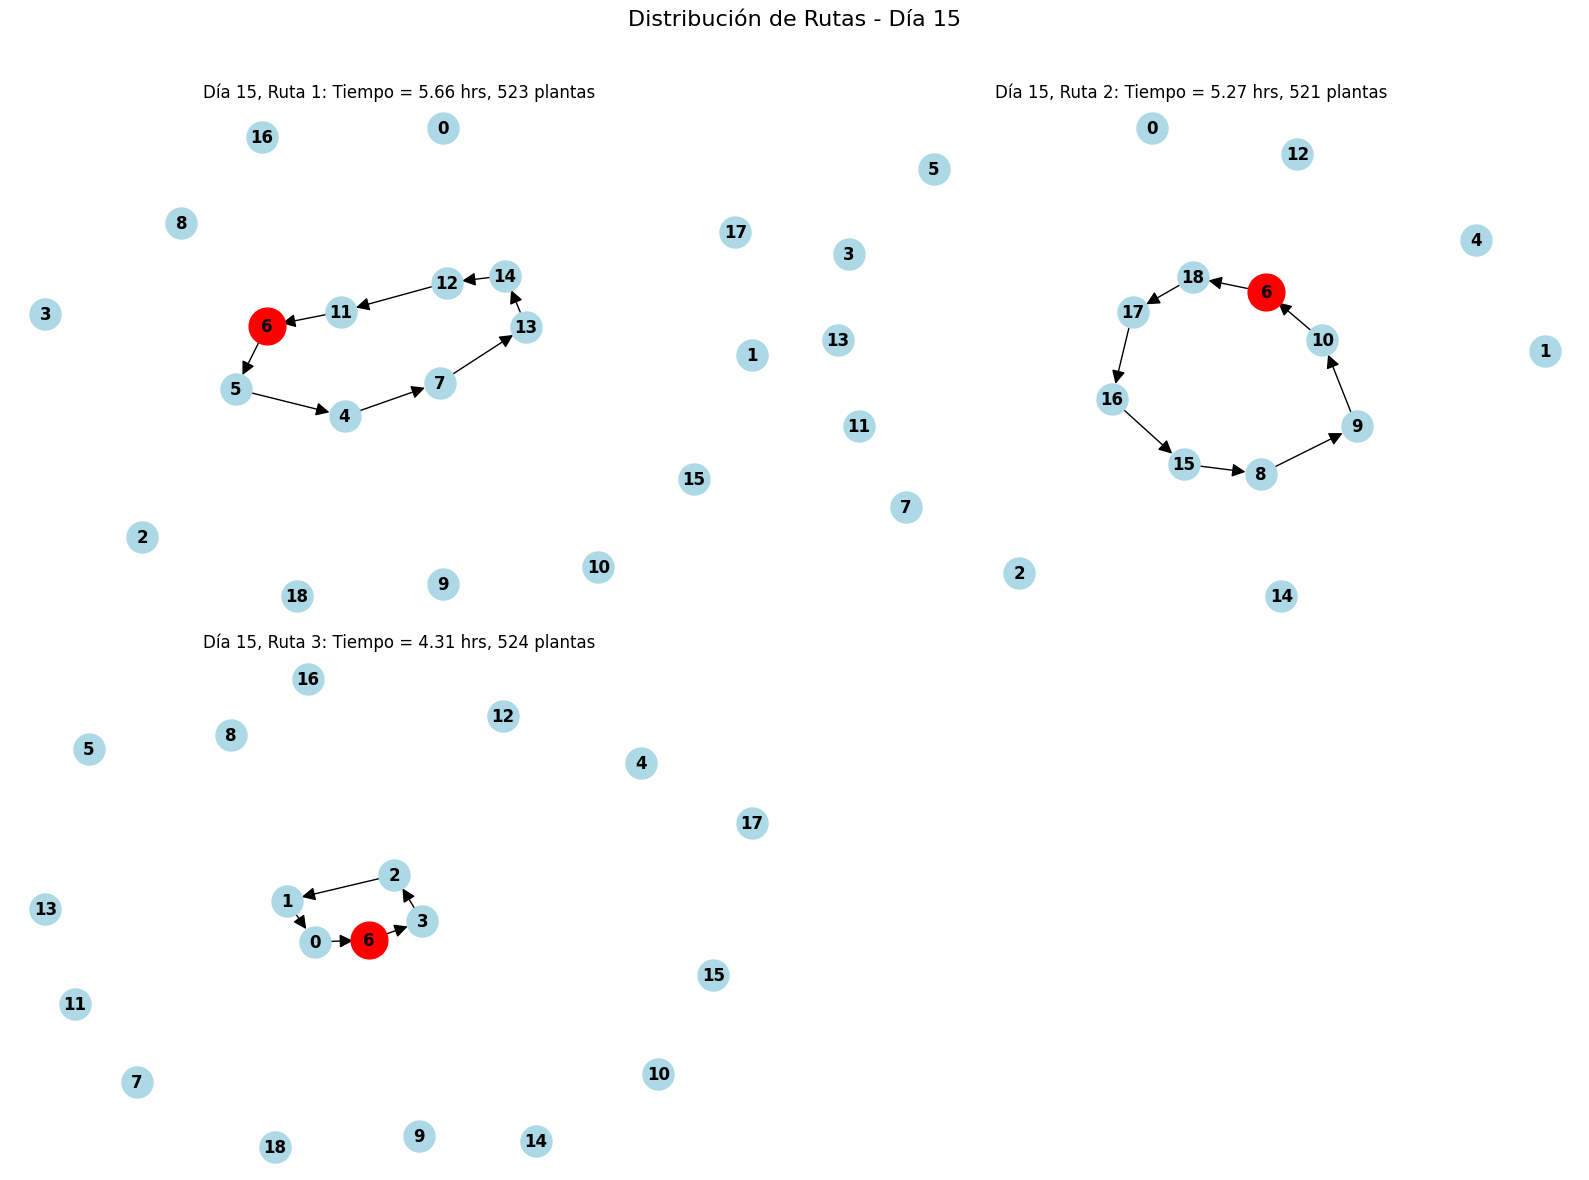


SIMULACIÓN DÍA 16

Calculating orders for delivery on Day 17
Current demand: [2410, 1462, 2410, 2410, 2853, 2209, 4235, 3741, 5033]
Demanda total: 26763, Capacidad máxima: 8000
⚠️ La demanda total (26763) excede la capacidad máxima (8000).
Se aplicará un ajuste proporcional a las cantidades solicitadas.
Capacidad utilizada: 7998.0 de 8000 (100.0%)

--- Análisis de Solución Greedy ---
Costo total: 193115.00
Costo de compra: 175115.00
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Distribución Detallada de Compras ---

especie 1:
  - Comprar 720 unidades a Laguna Seca (costo unitario: 26.00)

especie 2:
  - Comprar 437 unidades a Moctezuma (costo unitario: 26.00)

especie 3:
  - Comprar 720 unidades a Proveedor 4 (costo unitario: 25.00)

especie 4:
  - Comprar 720 unidades a Moctezuma (costo unitario: 17.00)

especie 5:
  - Comprar 853 unidades a Proveedor 4 (costo unitario: 18.00)

especie

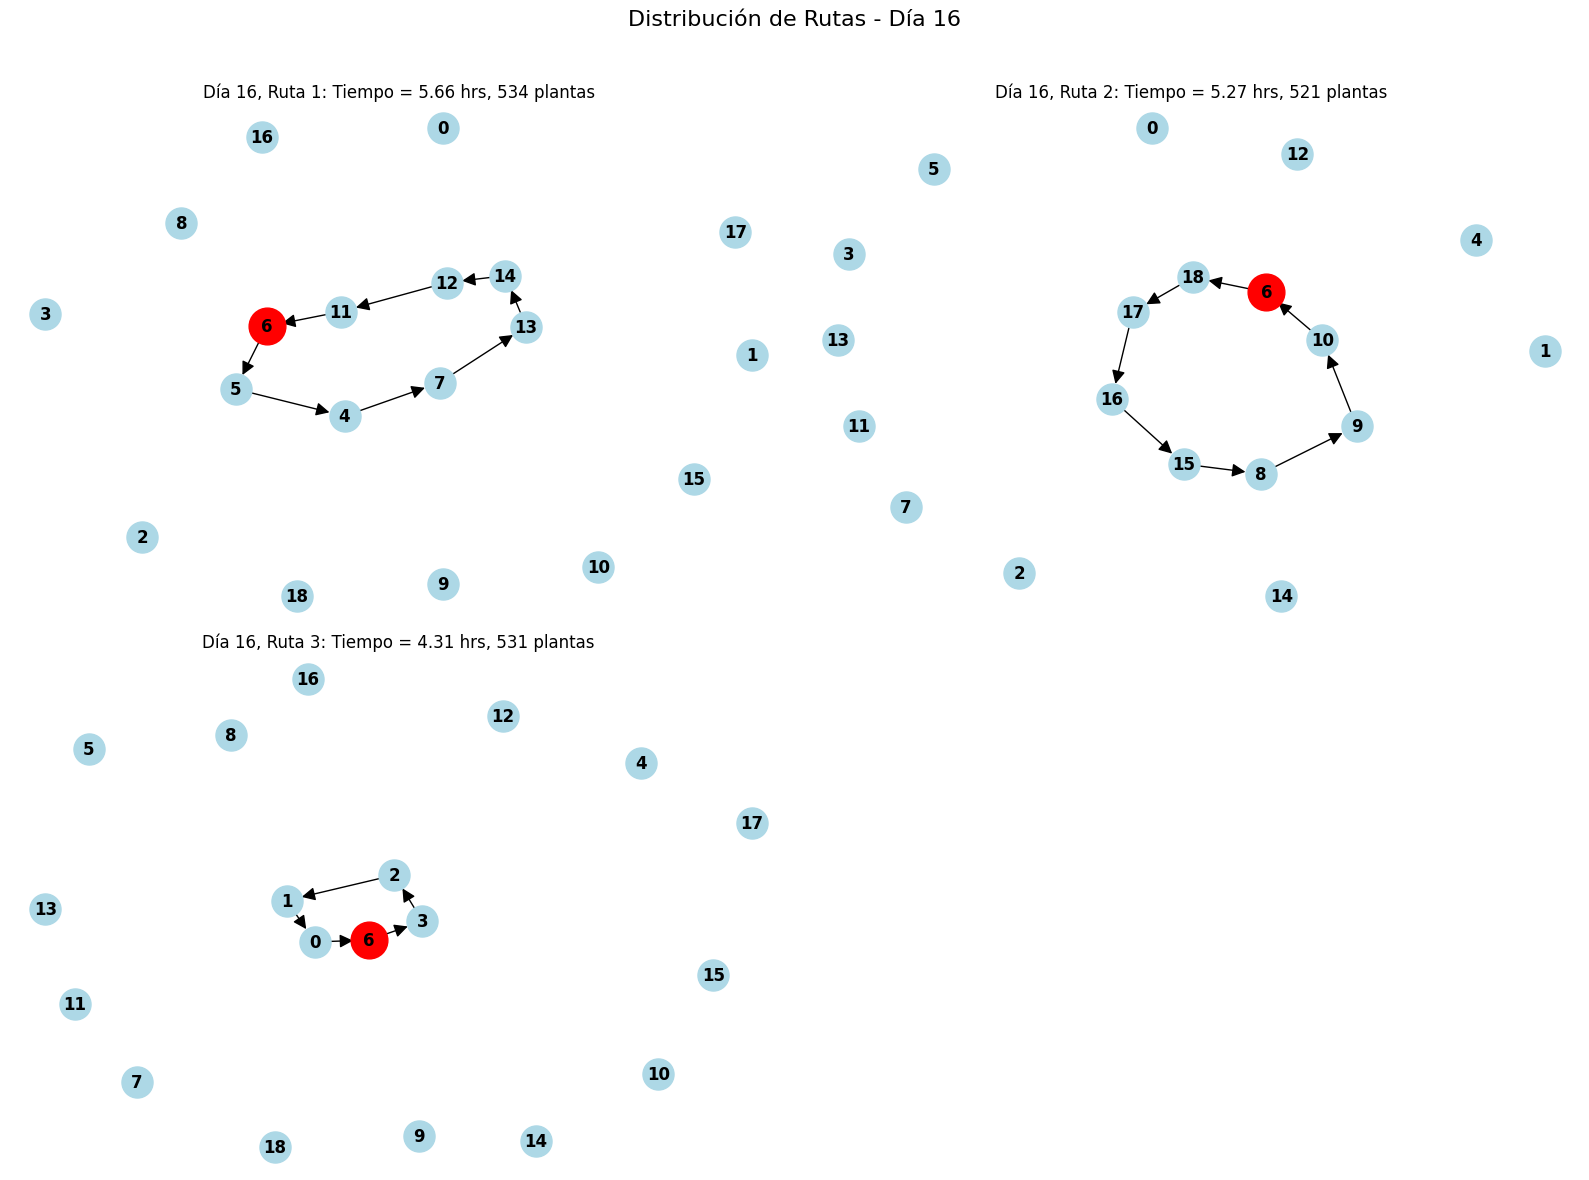


SIMULACIÓN DÍA 17

Calculating orders for delivery on Day 18
Current demand: [2268, 1375, 2268, 2268, 2686, 2081, 3985, 3520, 4734]
Demanda total: 25185, Capacidad máxima: 8000
⚠️ La demanda total (25185) excede la capacidad máxima (8000).
Se aplicará un ajuste proporcional a las cantidades solicitadas.
Capacidad utilizada: 7999.0 de 8000 (100.0%)

--- Análisis de Solución Greedy ---
Costo total: 193127.00
Costo de compra: 175127.00
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Distribución Detallada de Compras ---

especie 1:
  - Comprar 720 unidades a Laguna Seca (costo unitario: 26.00)

especie 2:
  - Comprar 437 unidades a Moctezuma (costo unitario: 26.00)

especie 3:
  - Comprar 720 unidades a Proveedor 4 (costo unitario: 25.00)

especie 4:
  - Comprar 720 unidades a Moctezuma (costo unitario: 17.00)

especie 5:
  - Comprar 853 unidades a Proveedor 4 (costo unitario: 18.00)

especie

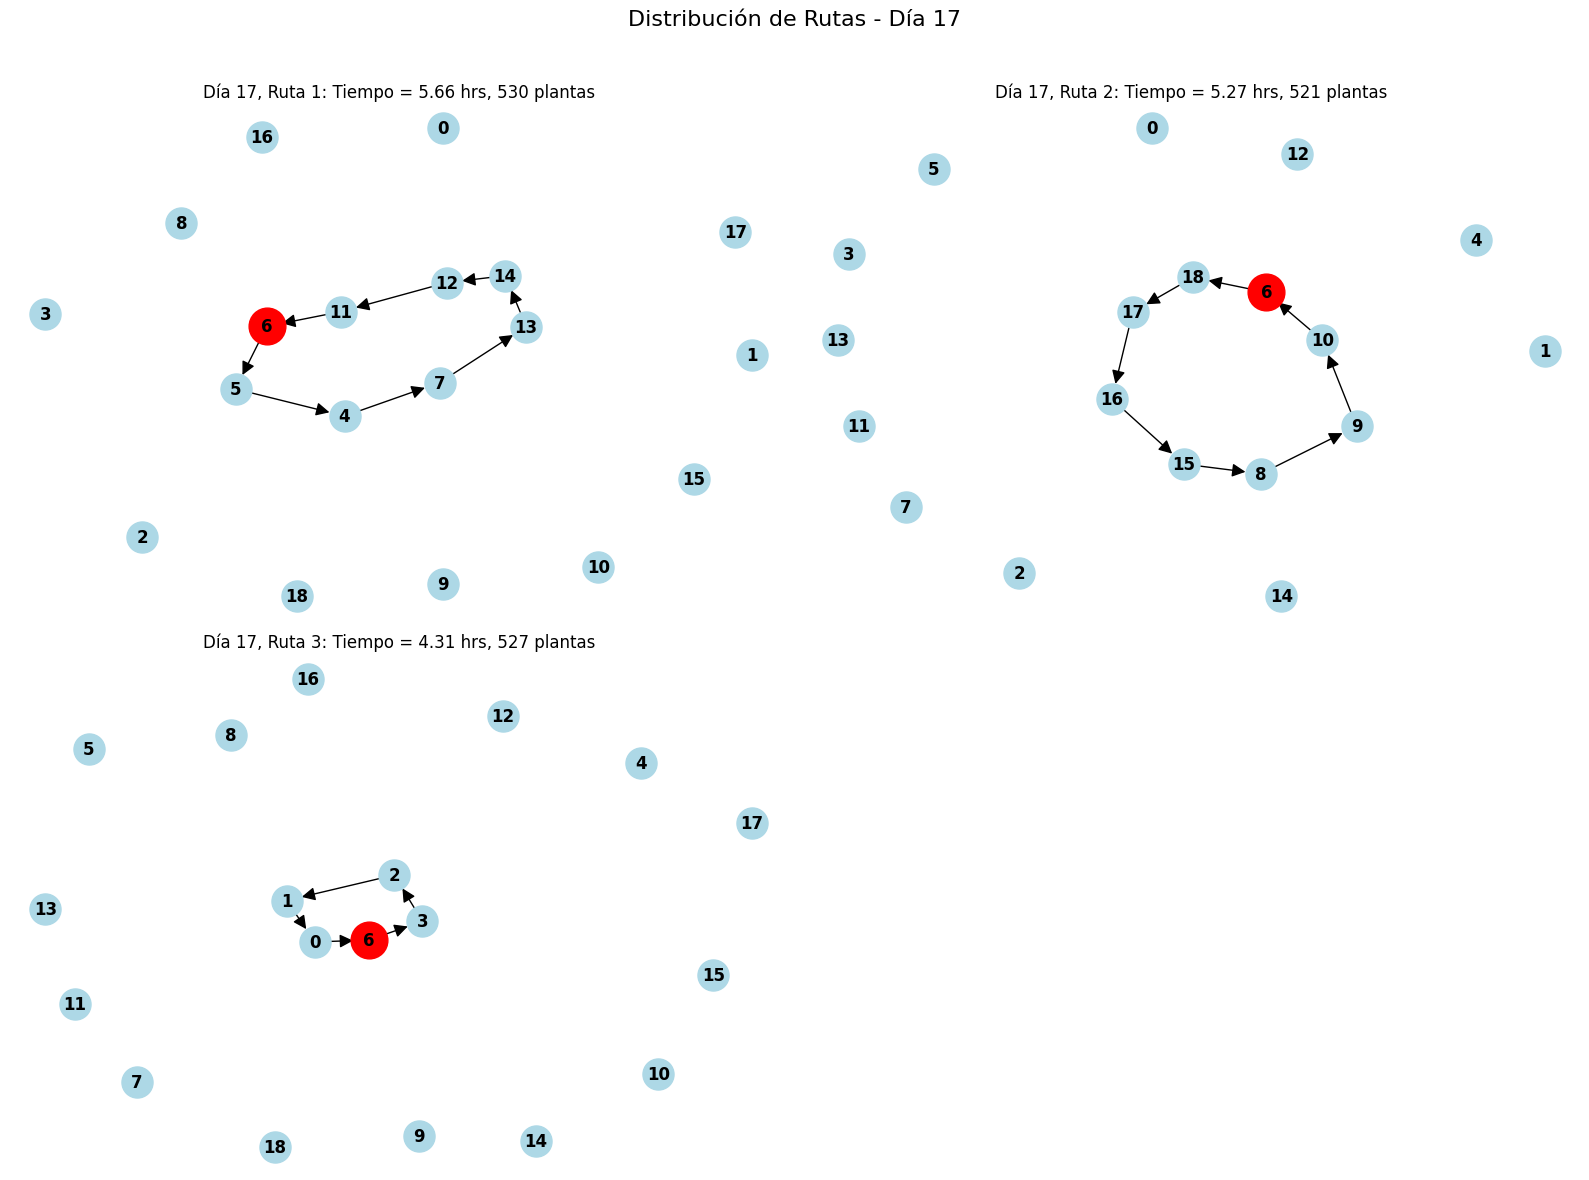


SIMULACIÓN DÍA 18

Calculating orders for delivery on Day 19
Current demand: [2128, 1290, 2128, 2128, 2518, 1952, 3734, 3302, 4439]
Demanda total: 23619, Capacidad máxima: 8000
⚠️ La demanda total (23619) excede la capacidad máxima (8000).
Se aplicará un ajuste proporcional a las cantidades solicitadas.
Capacidad utilizada: 8001.0 de 8000 (100.0%)

--- Análisis de Solución Greedy ---
Costo total: 193177.00
Costo de compra: 175177.00
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Distribución Detallada de Compras ---

especie 1:
  - Comprar 721 unidades a Laguna Seca (costo unitario: 26.00)

especie 2:
  - Comprar 437 unidades a Moctezuma (costo unitario: 26.00)

especie 3:
  - Comprar 721 unidades a Proveedor 4 (costo unitario: 25.00)

especie 4:
  - Comprar 721 unidades a Moctezuma (costo unitario: 17.00)

especie 5:
  - Comprar 853 unidades a Proveedor 4 (costo unitario: 18.00)

especie

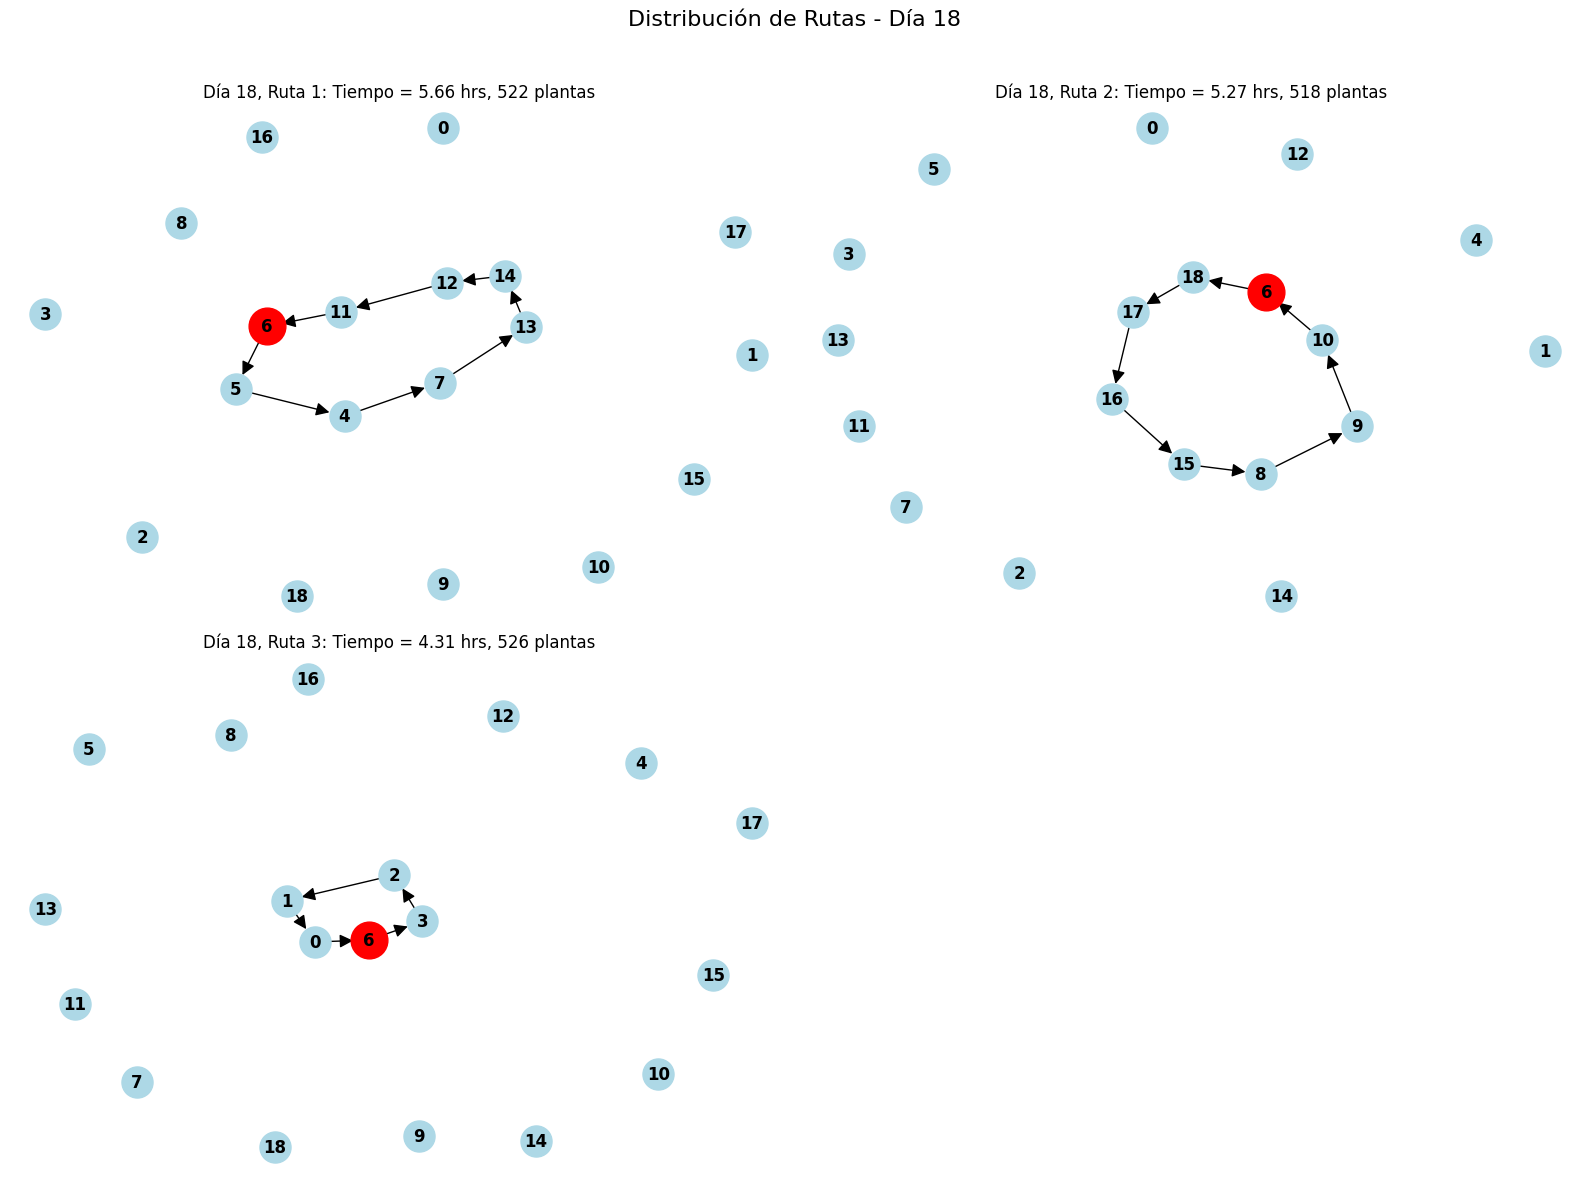


SIMULACIÓN DÍA 19

Calculating orders for delivery on Day 20
Current demand: [1986, 1204, 1986, 1986, 2350, 1824, 3486, 3080, 4141]
Demanda total: 22043, Capacidad máxima: 8000
⚠️ La demanda total (22043) excede la capacidad máxima (8000).
Se aplicará un ajuste proporcional a las cantidades solicitadas.
Capacidad utilizada: 8001.0 de 8000 (100.0%)

--- Análisis de Solución Greedy ---
Costo total: 193163.00
Costo de compra: 175163.00
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Distribución Detallada de Compras ---

especie 1:
  - Comprar 721 unidades a Laguna Seca (costo unitario: 26.00)

especie 2:
  - Comprar 437 unidades a Moctezuma (costo unitario: 26.00)

especie 3:
  - Comprar 721 unidades a Proveedor 4 (costo unitario: 25.00)

especie 4:
  - Comprar 721 unidades a Moctezuma (costo unitario: 17.00)

especie 5:
  - Comprar 853 unidades a Proveedor 4 (costo unitario: 18.00)

especie

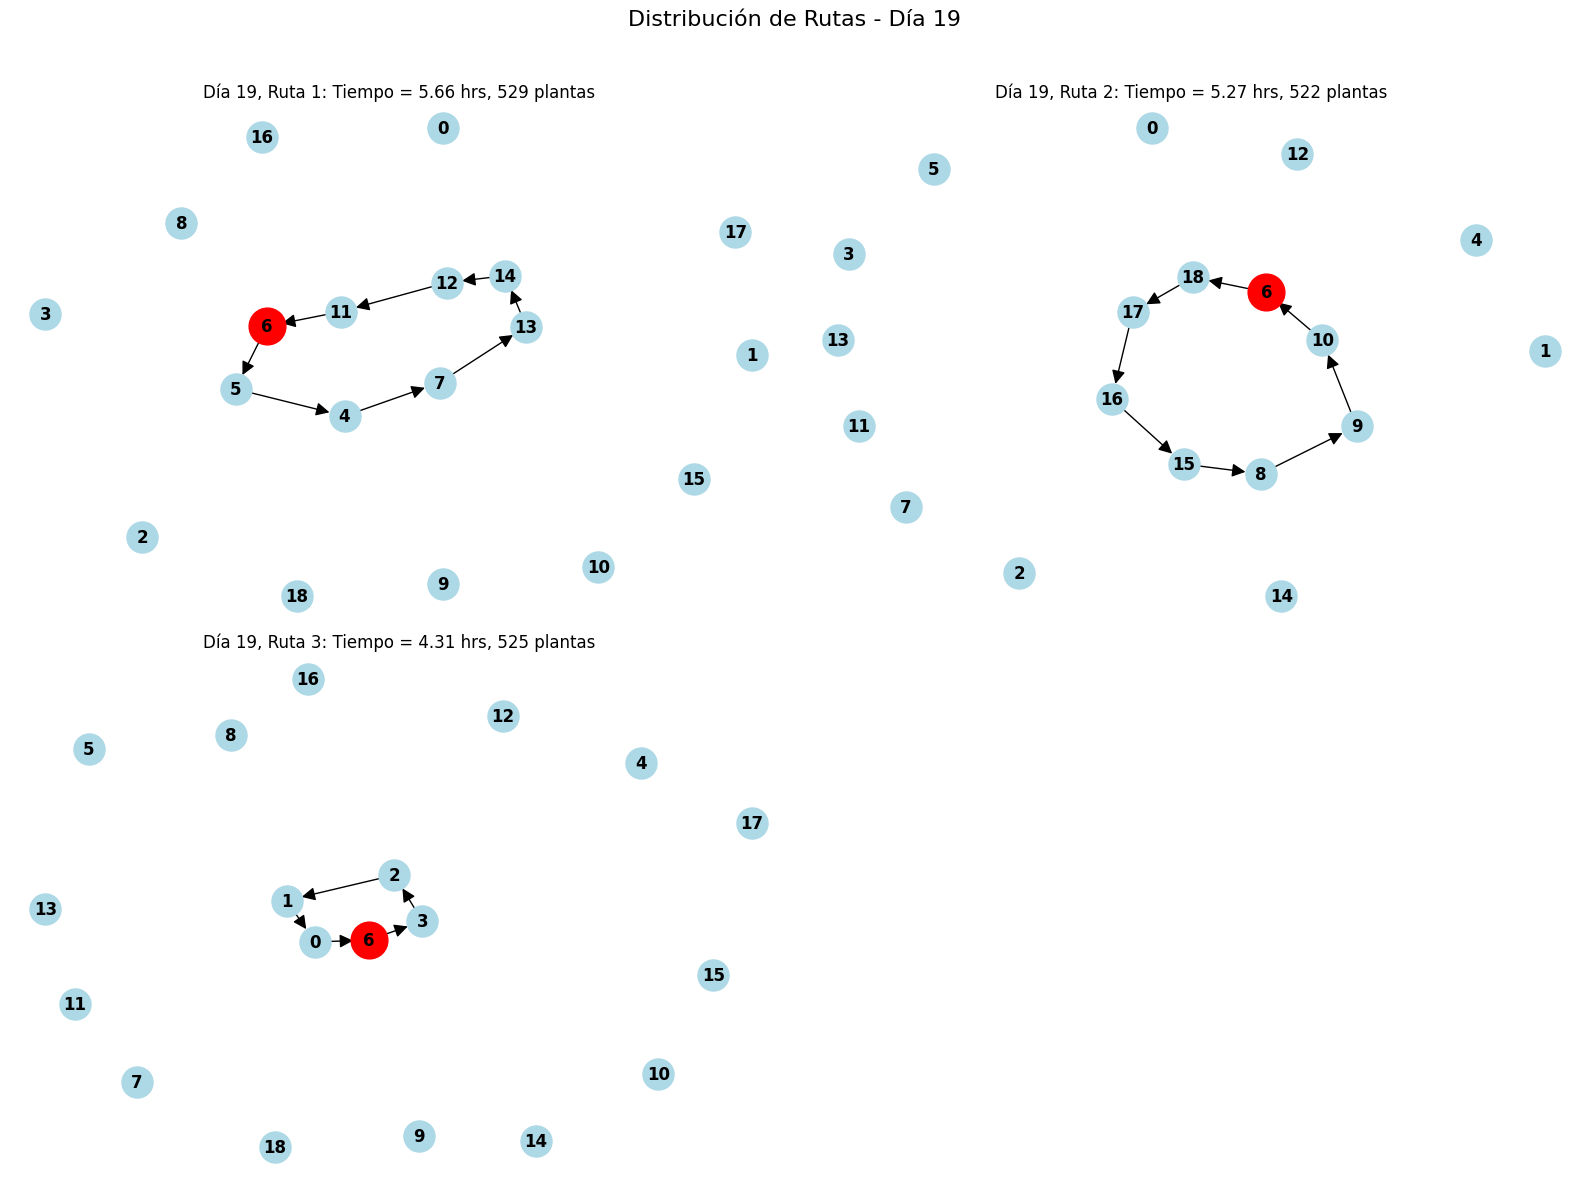


SIMULACIÓN DÍA 20

Calculating orders for delivery on Day 21
Current demand: [1863, 1129, 1863, 1863, 2204, 1711, 3267, 2888, 3880]
Demanda total: 20668, Capacidad máxima: 8000
⚠️ La demanda total (20668) excede la capacidad máxima (8000).
Se aplicará un ajuste proporcional a las cantidades solicitadas.
Capacidad utilizada: 8000.0 de 8000 (100.0%)

--- Análisis de Solución Greedy ---
Costo total: 193137.00
Costo de compra: 175137.00
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Distribución Detallada de Compras ---

especie 1:
  - Comprar 721 unidades a Laguna Seca (costo unitario: 26.00)

especie 2:
  - Comprar 437 unidades a Moctezuma (costo unitario: 26.00)

especie 3:
  - Comprar 721 unidades a Proveedor 4 (costo unitario: 25.00)

especie 4:
  - Comprar 721 unidades a Moctezuma (costo unitario: 17.00)

especie 5:
  - Comprar 853 unidades a Proveedor 4 (costo unitario: 18.00)

especie

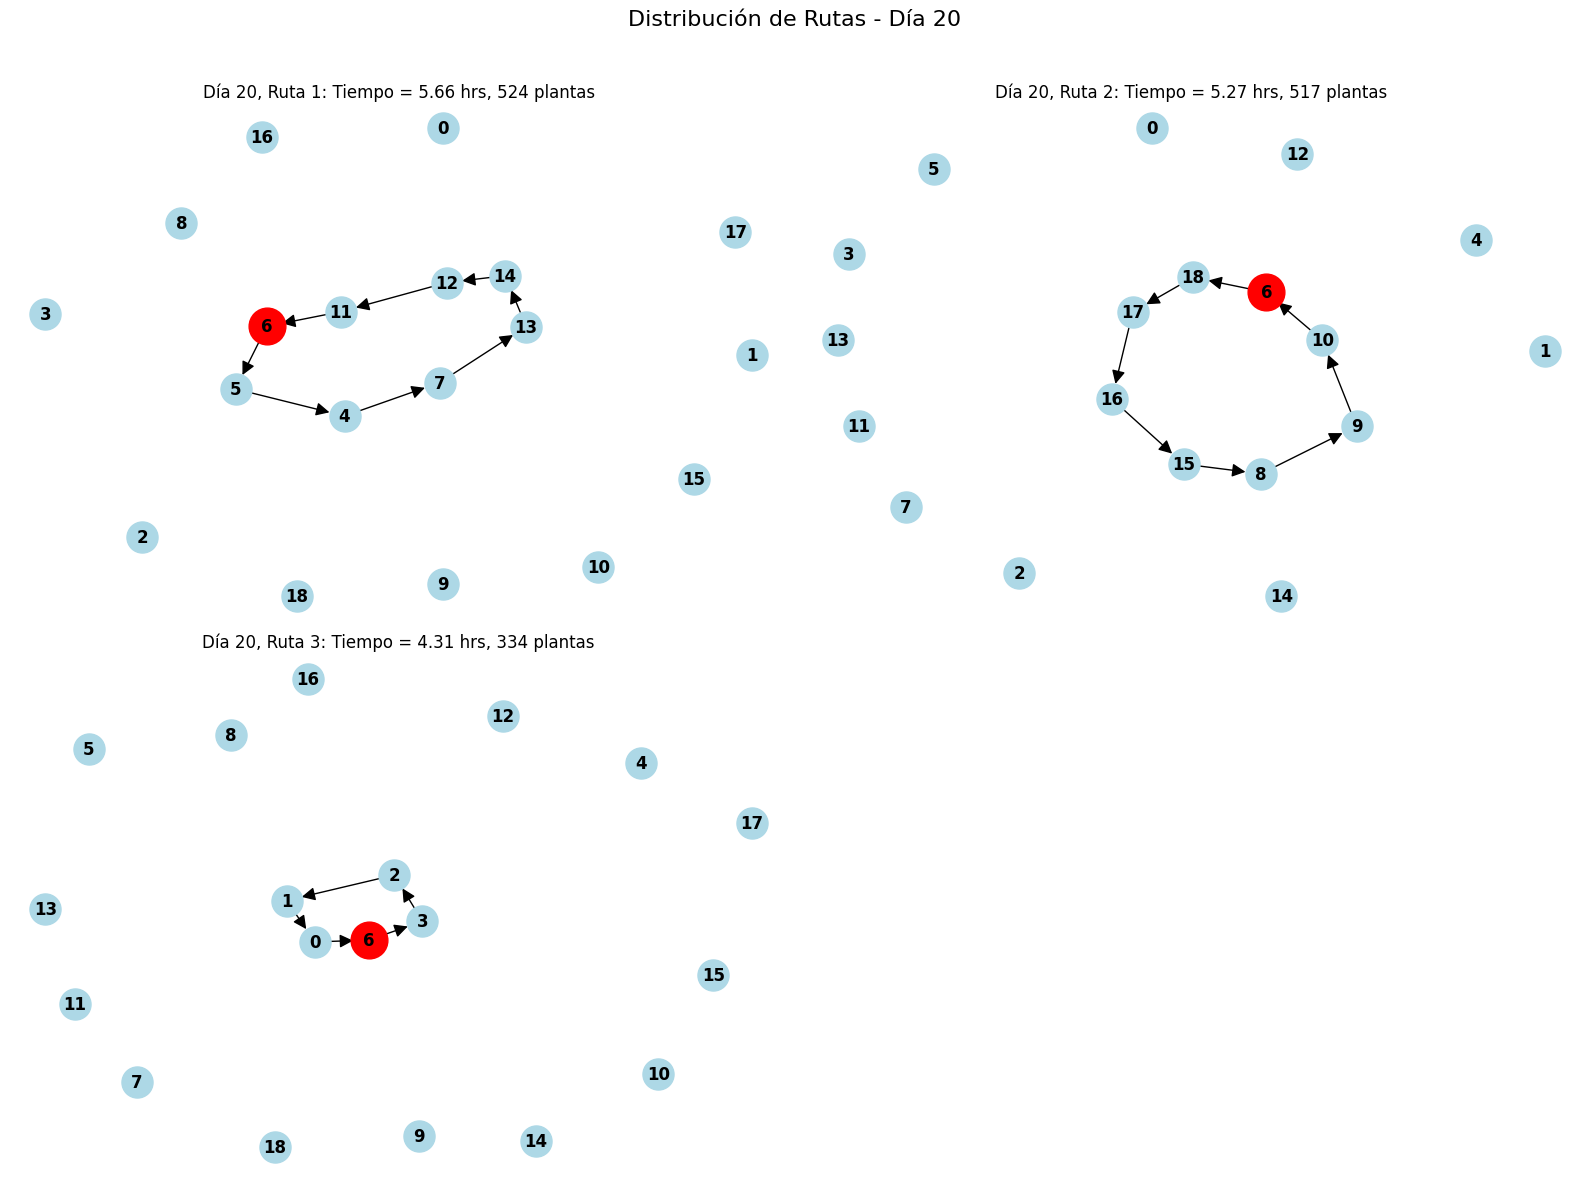


SIMULACIÓN DÍA 21

Calculating orders for delivery on Day 22
Current demand: [1767, 1073, 1767, 1767, 2092, 1627, 3100, 2741, 3684]
Demanda total: 19618, Capacidad máxima: 8000
⚠️ La demanda total (19618) excede la capacidad máxima (8000).
Se aplicará un ajuste proporcional a las cantidades solicitadas.
Capacidad utilizada: 8001.0 de 8000 (100.0%)

--- Análisis de Solución Greedy ---
Costo total: 193157.00
Costo de compra: 175157.00
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Distribución Detallada de Compras ---

especie 1:
  - Comprar 721 unidades a Laguna Seca (costo unitario: 26.00)

especie 2:
  - Comprar 438 unidades a Moctezuma (costo unitario: 26.00)

especie 3:
  - Comprar 721 unidades a Proveedor 4 (costo unitario: 25.00)

especie 4:
  - Comprar 721 unidades a Moctezuma (costo unitario: 17.00)

especie 5:
  - Comprar 853 unidades a Proveedor 4 (costo unitario: 18.00)

especie

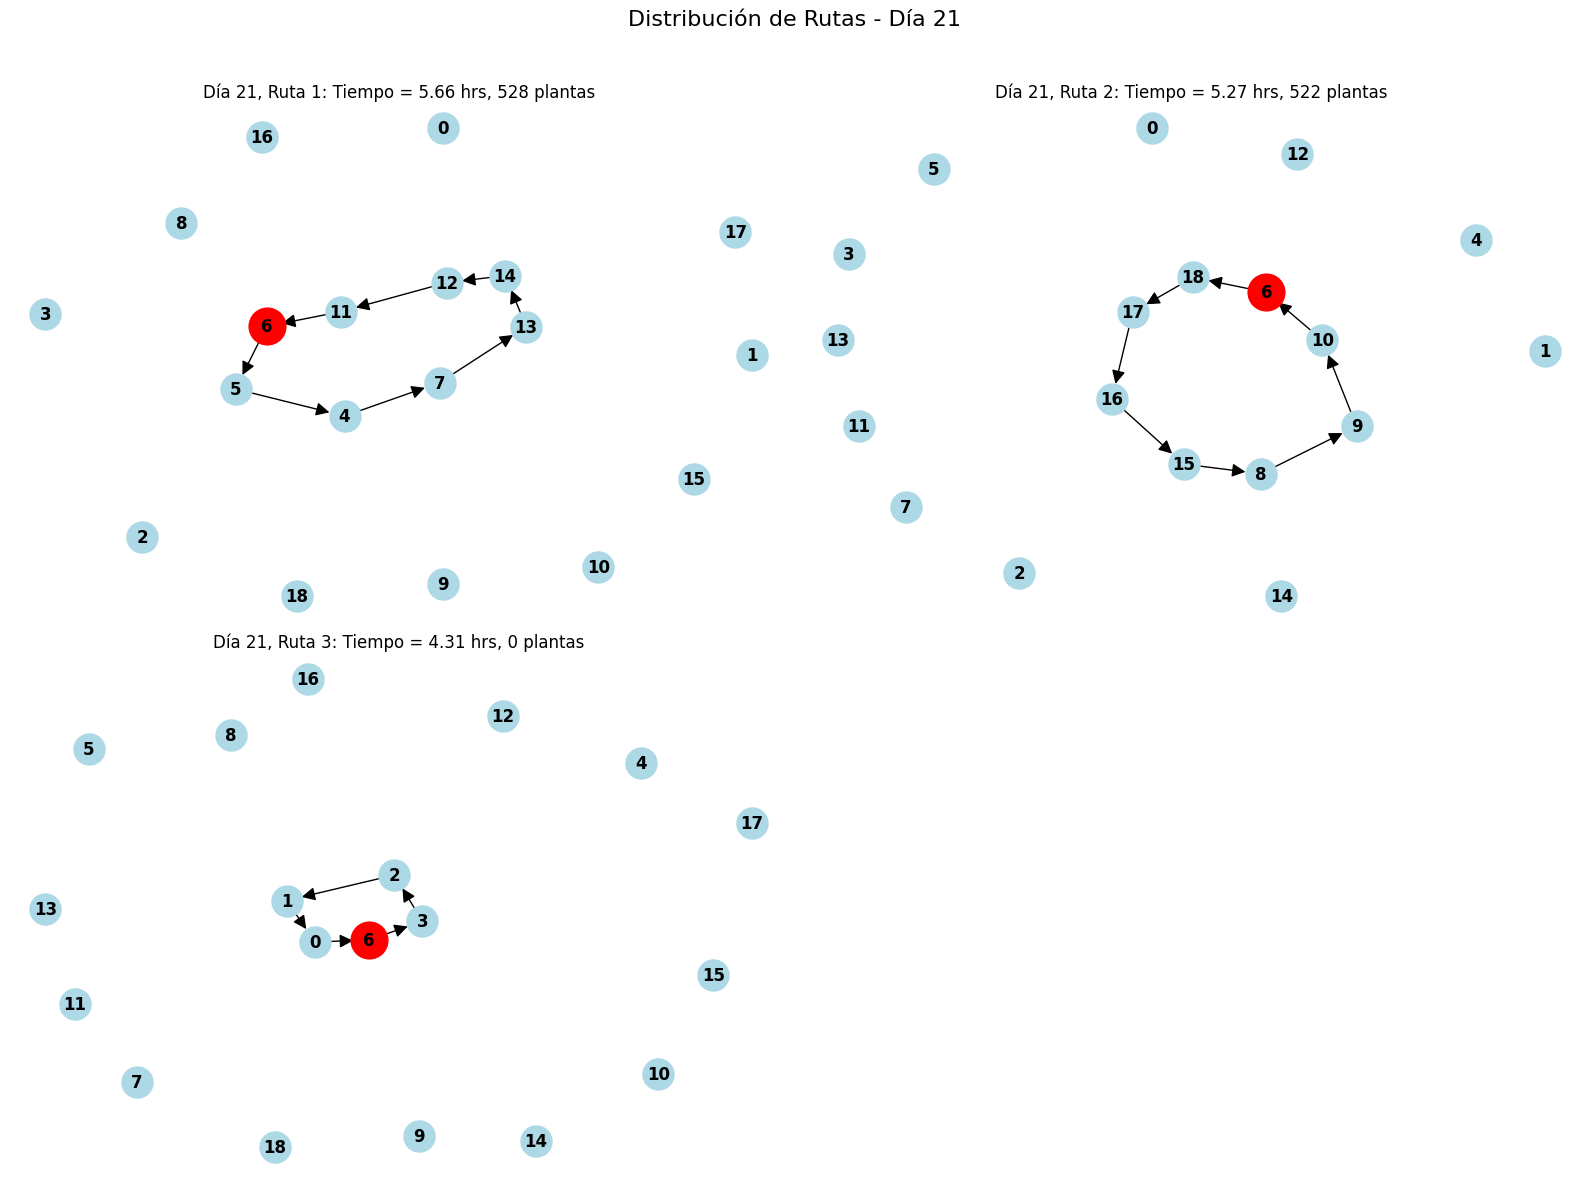


SIMULACIÓN DÍA 22

Calculating orders for delivery on Day 23
Current demand: [1674, 1015, 1674, 1674, 1980, 1541, 2934, 2596, 3485]
Demanda total: 18573, Capacidad máxima: 8000
⚠️ La demanda total (18573) excede la capacidad máxima (8000).
Se aplicará un ajuste proporcional a las cantidades solicitadas.
Capacidad utilizada: 8000.0 de 8000 (100.0%)

--- Análisis de Solución Greedy ---
Costo total: 193117.00
Costo de compra: 175117.00
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Distribución Detallada de Compras ---

especie 1:
  - Comprar 721 unidades a Laguna Seca (costo unitario: 26.00)

especie 2:
  - Comprar 437 unidades a Moctezuma (costo unitario: 26.00)

especie 3:
  - Comprar 721 unidades a Proveedor 4 (costo unitario: 25.00)

especie 4:
  - Comprar 721 unidades a Moctezuma (costo unitario: 17.00)

especie 5:
  - Comprar 853 unidades a Proveedor 4 (costo unitario: 18.00)

especie

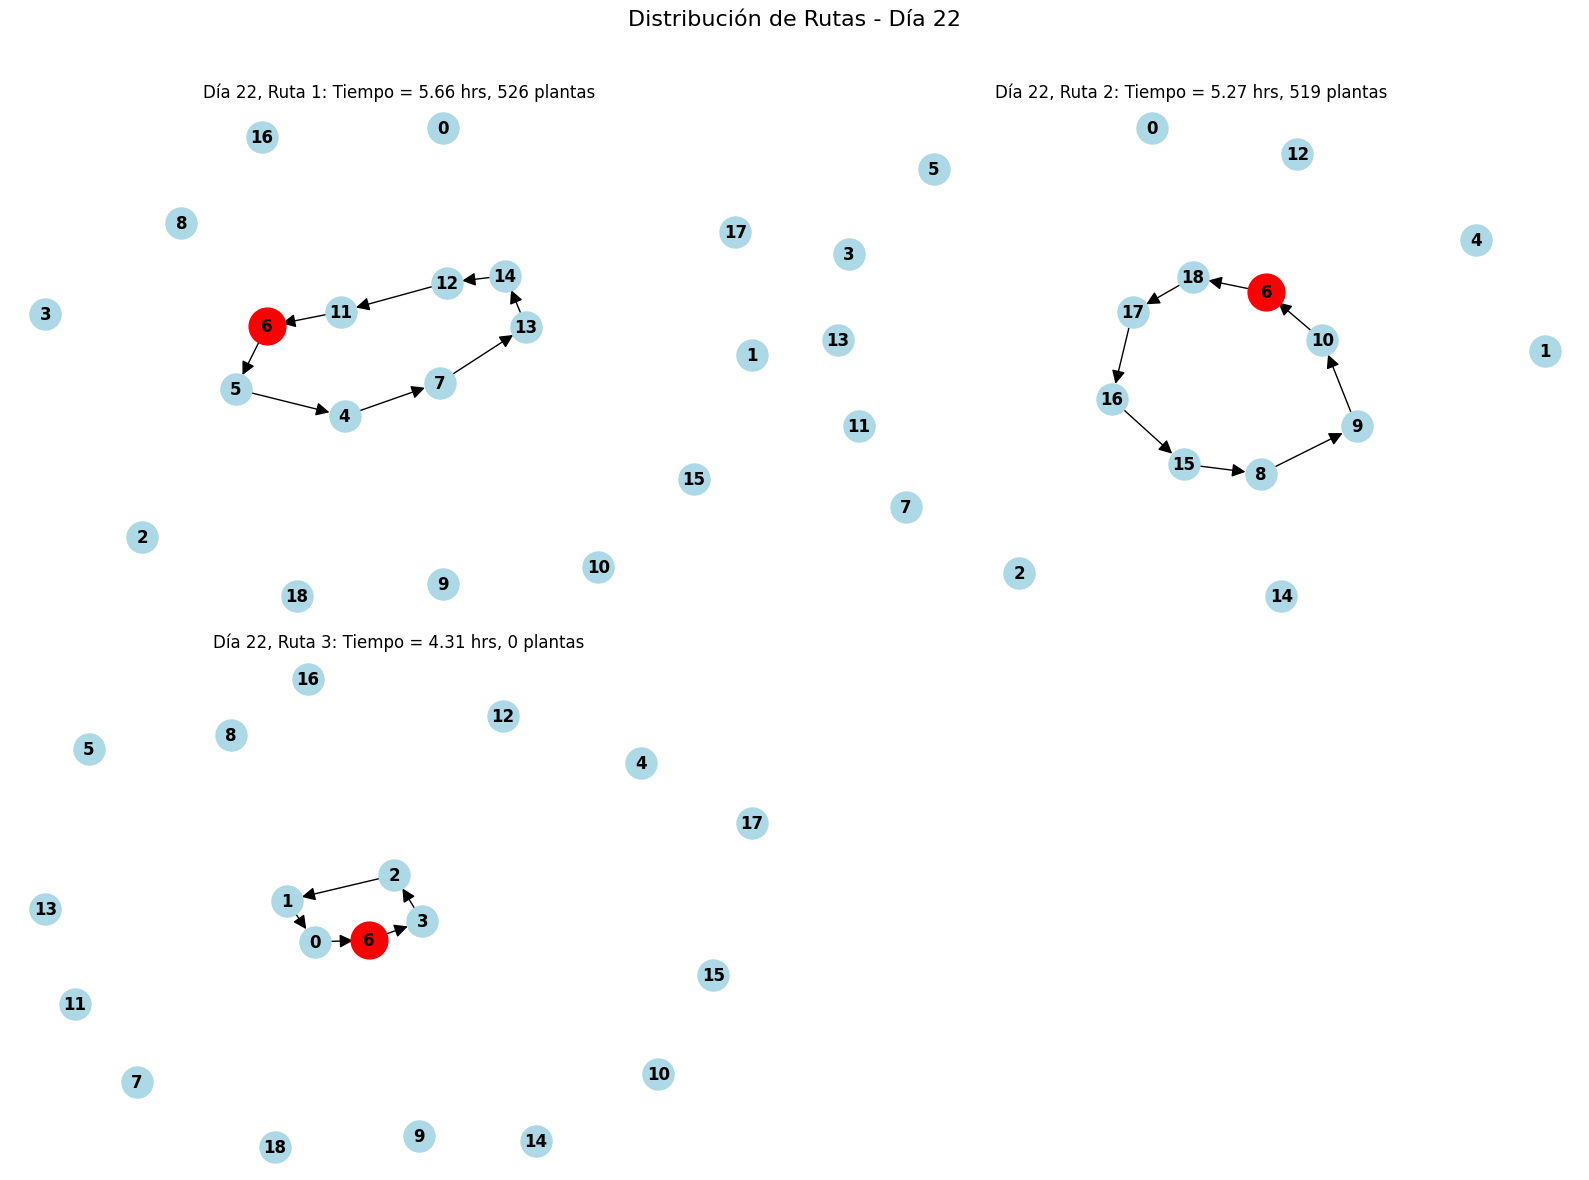


SIMULACIÓN DÍA 23

Calculating orders for delivery on Day 24
Current demand: [1579, 959, 1579, 1579, 1867, 1457, 2768, 2448, 3288]
Demanda total: 17524, Capacidad máxima: 8000
⚠️ La demanda total (17524) excede la capacidad máxima (8000).
Se aplicará un ajuste proporcional a las cantidades solicitadas.
Capacidad utilizada: 8001.0 de 8000 (100.0%)

--- Análisis de Solución Greedy ---
Costo total: 193137.00
Costo de compra: 175137.00
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Distribución Detallada de Compras ---

especie 1:
  - Comprar 721 unidades a Laguna Seca (costo unitario: 26.00)

especie 2:
  - Comprar 438 unidades a Moctezuma (costo unitario: 26.00)

especie 3:
  - Comprar 721 unidades a Proveedor 4 (costo unitario: 25.00)

especie 4:
  - Comprar 721 unidades a Moctezuma (costo unitario: 17.00)

especie 5:
  - Comprar 852 unidades a Proveedor 4 (costo unitario: 18.00)

especie 

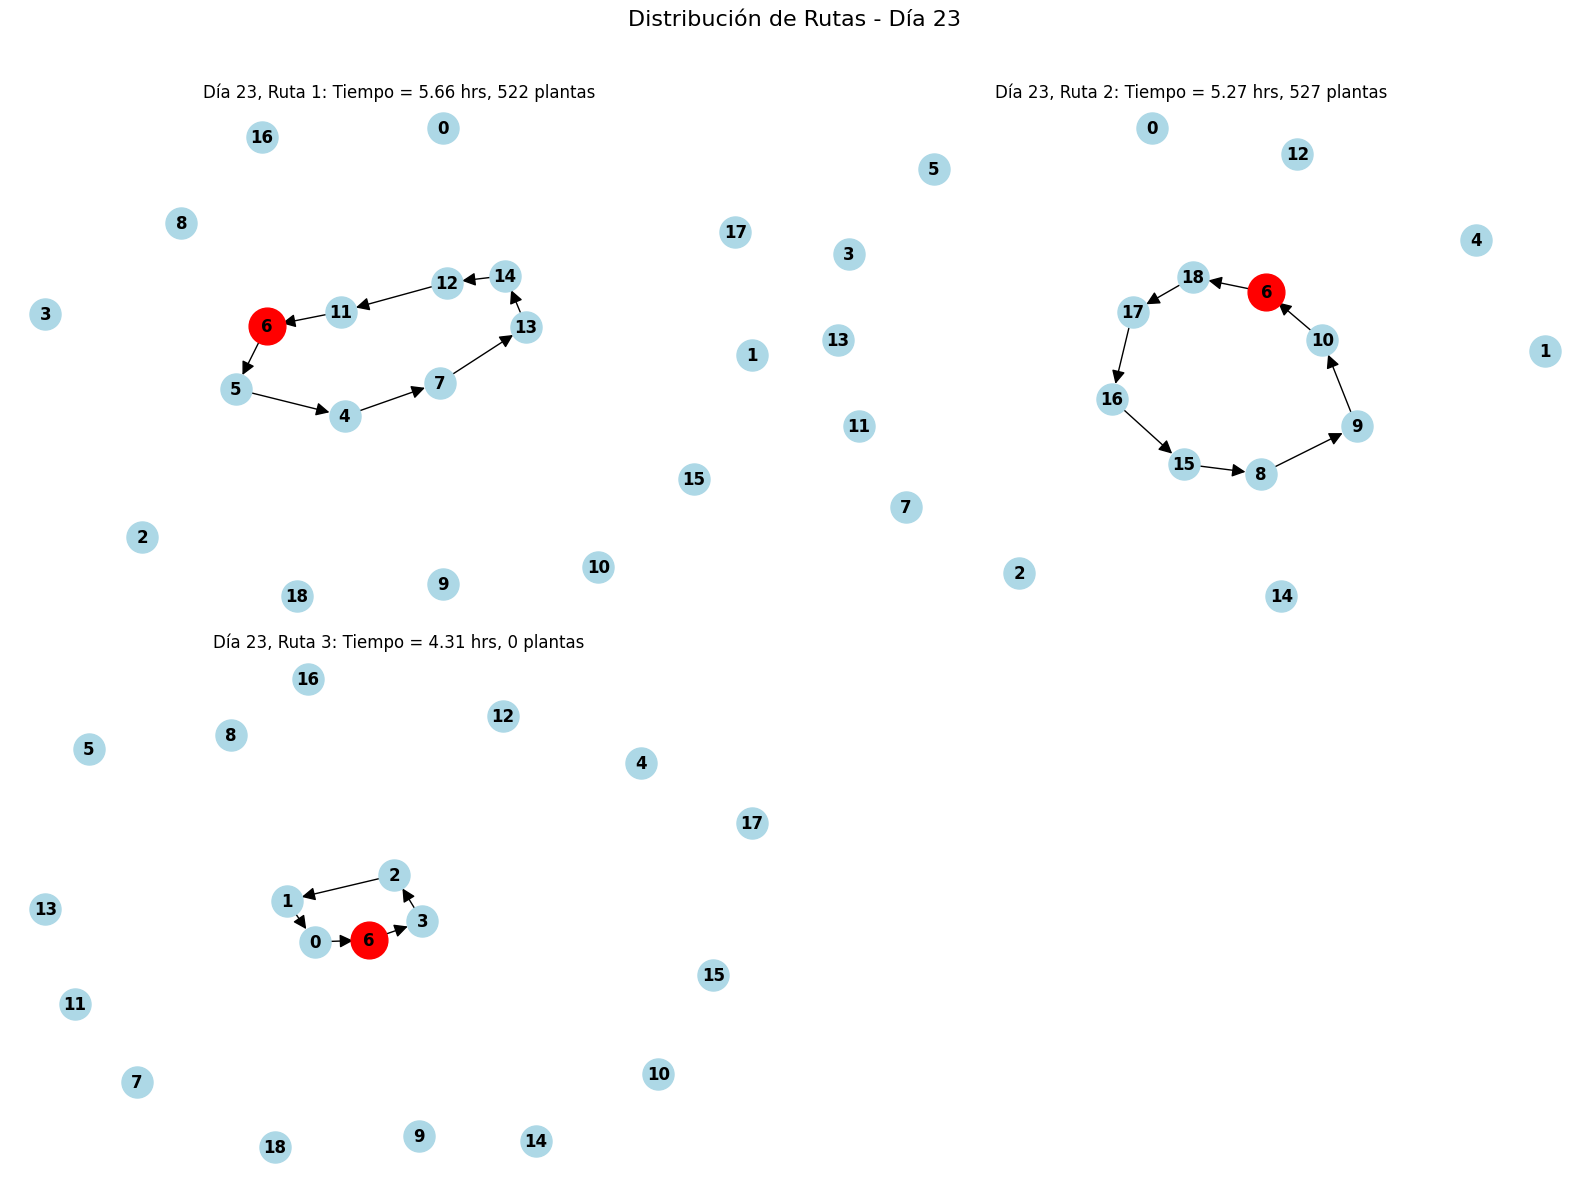


SIMULACIÓN DÍA 24

Calculating orders for delivery on Day 25
Current demand: [1486, 900, 1486, 1486, 1757, 1370, 2601, 2302, 3090]
Demanda total: 16478, Capacidad máxima: 8000
⚠️ La demanda total (16478) excede la capacidad máxima (8000).
Se aplicará un ajuste proporcional a las cantidades solicitadas.
Capacidad utilizada: 7999.0 de 8000 (100.0%)

--- Análisis de Solución Greedy ---
Costo total: 193085.00
Costo de compra: 175085.00
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Distribución Detallada de Compras ---

especie 1:
  - Comprar 721 unidades a Laguna Seca (costo unitario: 26.00)

especie 2:
  - Comprar 437 unidades a Moctezuma (costo unitario: 26.00)

especie 3:
  - Comprar 721 unidades a Proveedor 4 (costo unitario: 25.00)

especie 4:
  - Comprar 721 unidades a Moctezuma (costo unitario: 17.00)

especie 5:
  - Comprar 853 unidades a Proveedor 4 (costo unitario: 18.00)

especie 

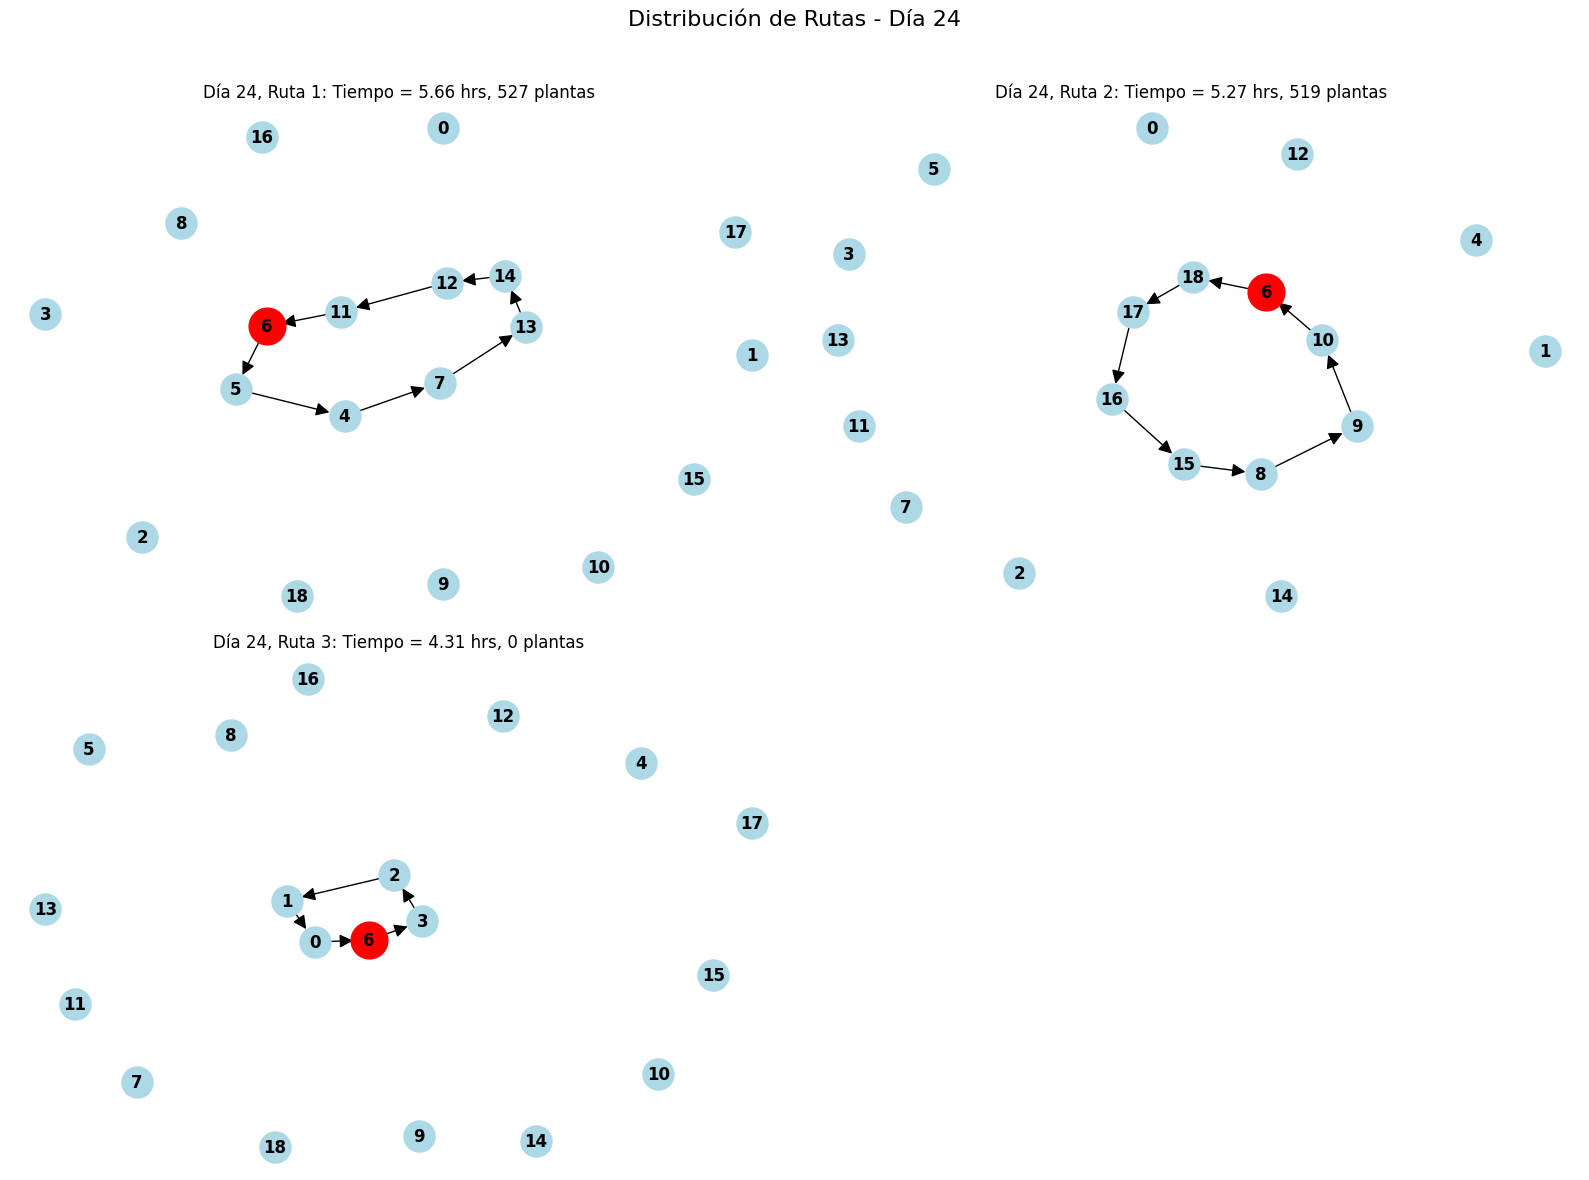


SIMULACIÓN DÍA 25

Calculating orders for delivery on Day 26
Current demand: [1392, 844, 1392, 1392, 1643, 1285, 2437, 2153, 2895]
Demanda total: 15433, Capacidad máxima: 8000
⚠️ La demanda total (15433) excede la capacidad máxima (8000).
Se aplicará un ajuste proporcional a las cantidades solicitadas.
Capacidad utilizada: 8002.0 de 8000 (100.0%)

--- Análisis de Solución Greedy ---
Costo total: 193146.00
Costo de compra: 175146.00
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Distribución Detallada de Compras ---

especie 1:
  - Comprar 722 unidades a Laguna Seca (costo unitario: 26.00)

especie 2:
  - Comprar 438 unidades a Moctezuma (costo unitario: 26.00)

especie 3:
  - Comprar 722 unidades a Proveedor 4 (costo unitario: 25.00)

especie 4:
  - Comprar 722 unidades a Moctezuma (costo unitario: 17.00)

especie 5:
  - Comprar 852 unidades a Proveedor 4 (costo unitario: 18.00)

especie 

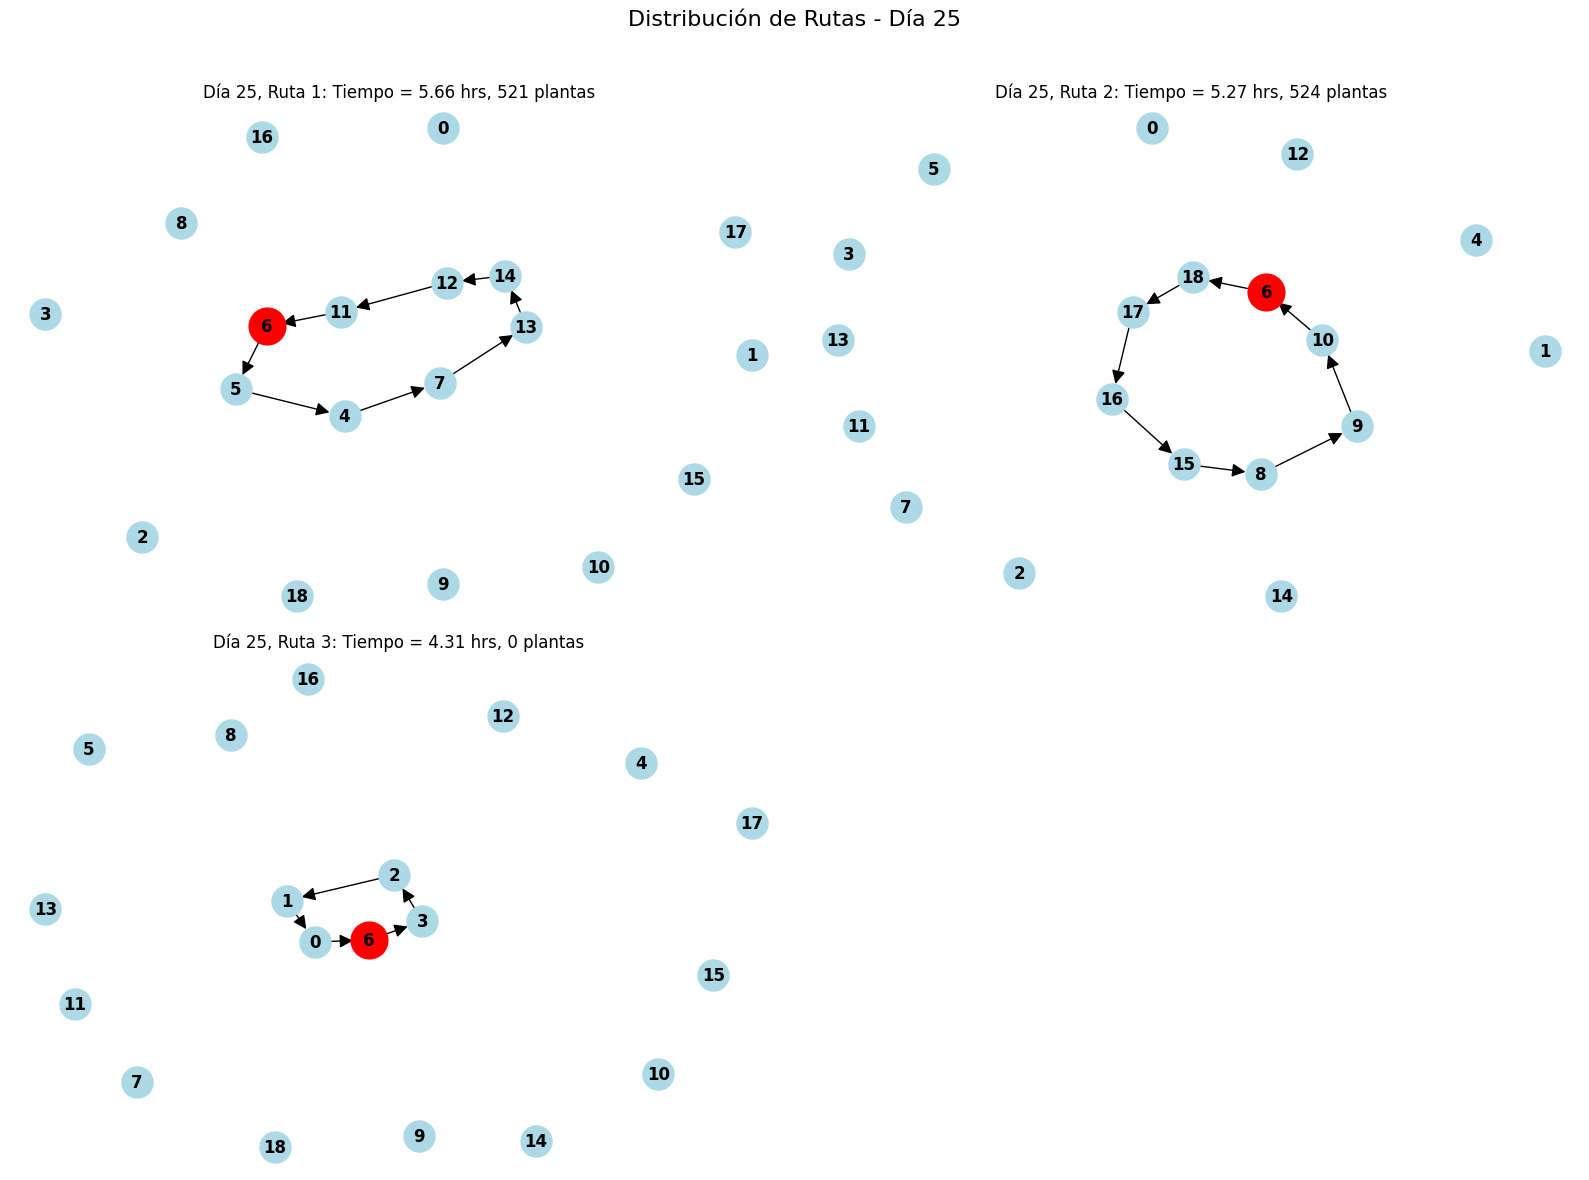


SIMULACIÓN DÍA 26

Calculating orders for delivery on Day 27
Current demand: [1298, 784, 1298, 1298, 1533, 1197, 2270, 2007, 2698]
Demanda total: 14383, Capacidad máxima: 8000
⚠️ La demanda total (14383) excede la capacidad máxima (8000).
Se aplicará un ajuste proporcional a las cantidades solicitadas.
Capacidad utilizada: 8001.0 de 8000 (100.0%)

--- Análisis de Solución Greedy ---
Costo total: 193112.00
Costo de compra: 175112.00
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Distribución Detallada de Compras ---

especie 1:
  - Comprar 722 unidades a Laguna Seca (costo unitario: 26.00)

especie 2:
  - Comprar 436 unidades a Moctezuma (costo unitario: 26.00)

especie 3:
  - Comprar 722 unidades a Proveedor 4 (costo unitario: 25.00)

especie 4:
  - Comprar 722 unidades a Moctezuma (costo unitario: 17.00)

especie 5:
  - Comprar 853 unidades a Proveedor 4 (costo unitario: 18.00)

especie 

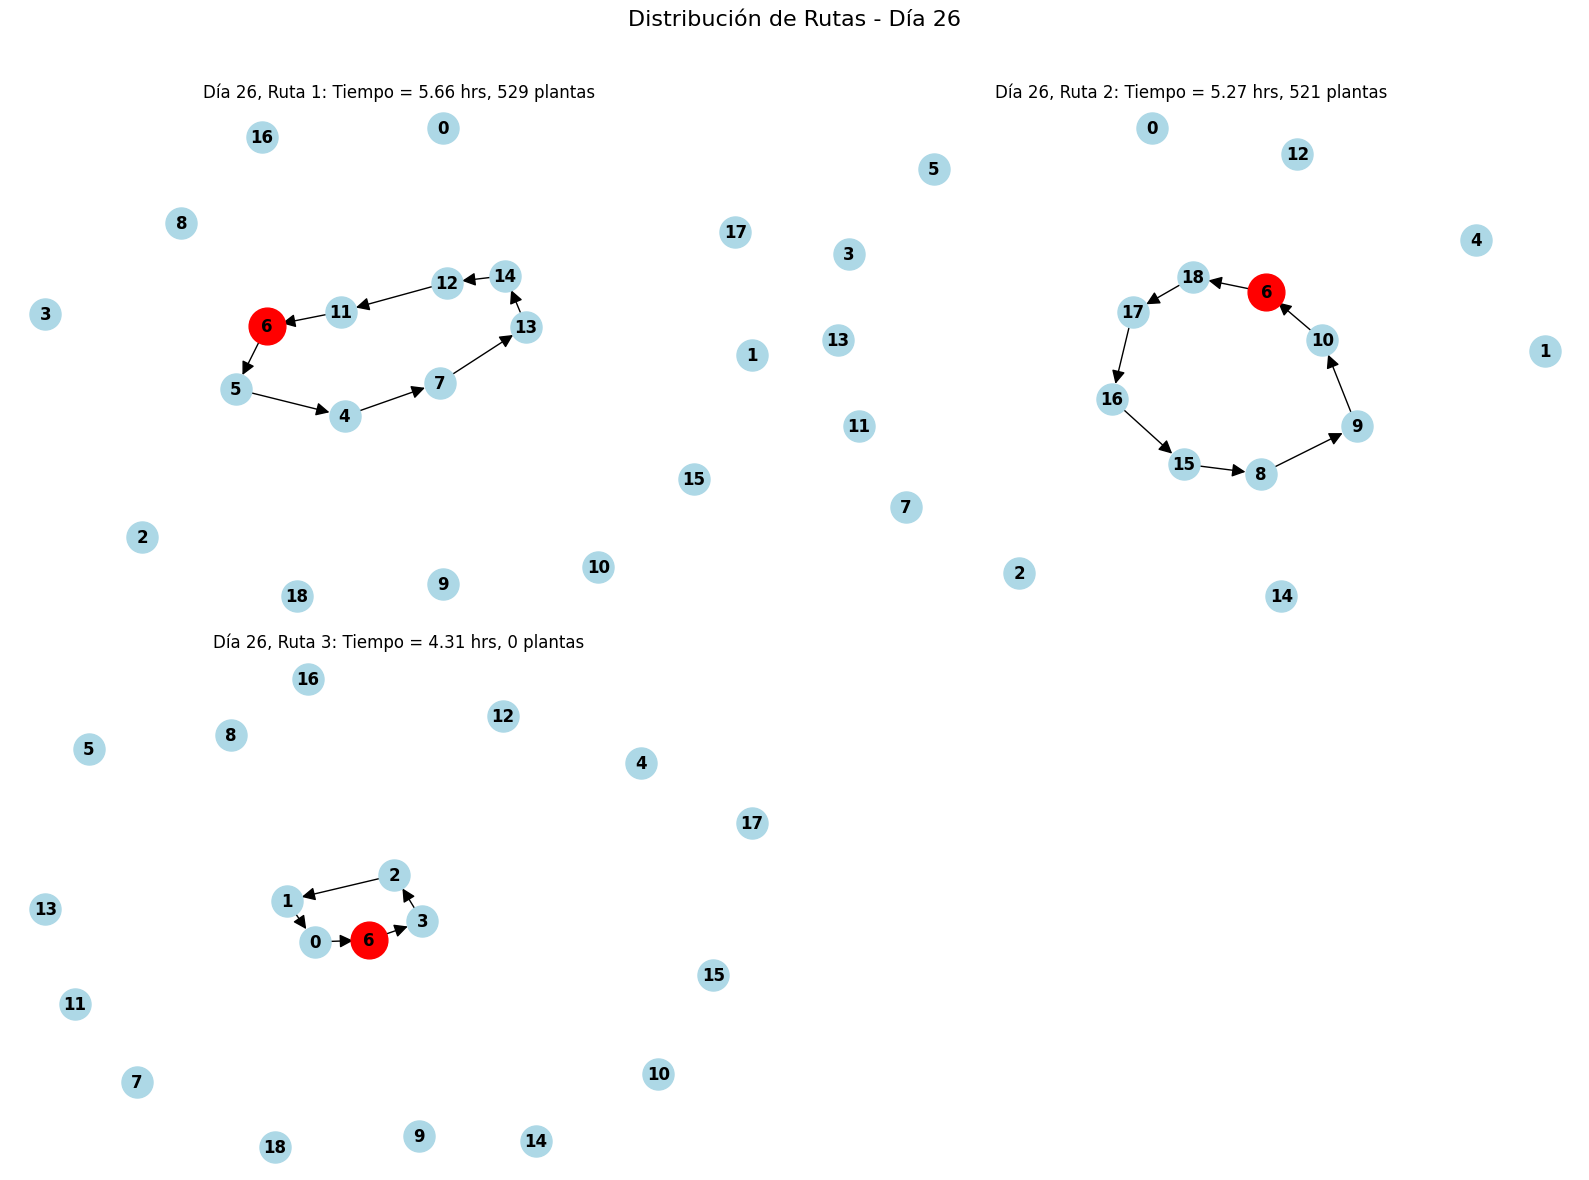


SIMULACIÓN DÍA 27

Calculating orders for delivery on Day 28
Current demand: [1204, 728, 1204, 1204, 1419, 1112, 2105, 1858, 2501]
Demanda total: 13335, Capacidad máxima: 8000
⚠️ La demanda total (13335) excede la capacidad máxima (8000).
Se aplicará un ajuste proporcional a las cantidades solicitadas.
Capacidad utilizada: 7999.0 de 8000 (100.0%)

--- Análisis de Solución Greedy ---
Costo total: 193061.50
Costo de compra: 175061.50
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Distribución Detallada de Compras ---

especie 1:
  - Comprar 722 unidades a Laguna Seca (costo unitario: 26.00)

especie 2:
  - Comprar 437 unidades a Moctezuma (costo unitario: 26.00)

especie 3:
  - Comprar 722 unidades a Proveedor 4 (costo unitario: 25.00)

especie 4:
  - Comprar 722 unidades a Moctezuma (costo unitario: 17.00)

especie 5:
  - Comprar 851 unidades a Proveedor 4 (costo unitario: 18.00)

especie 

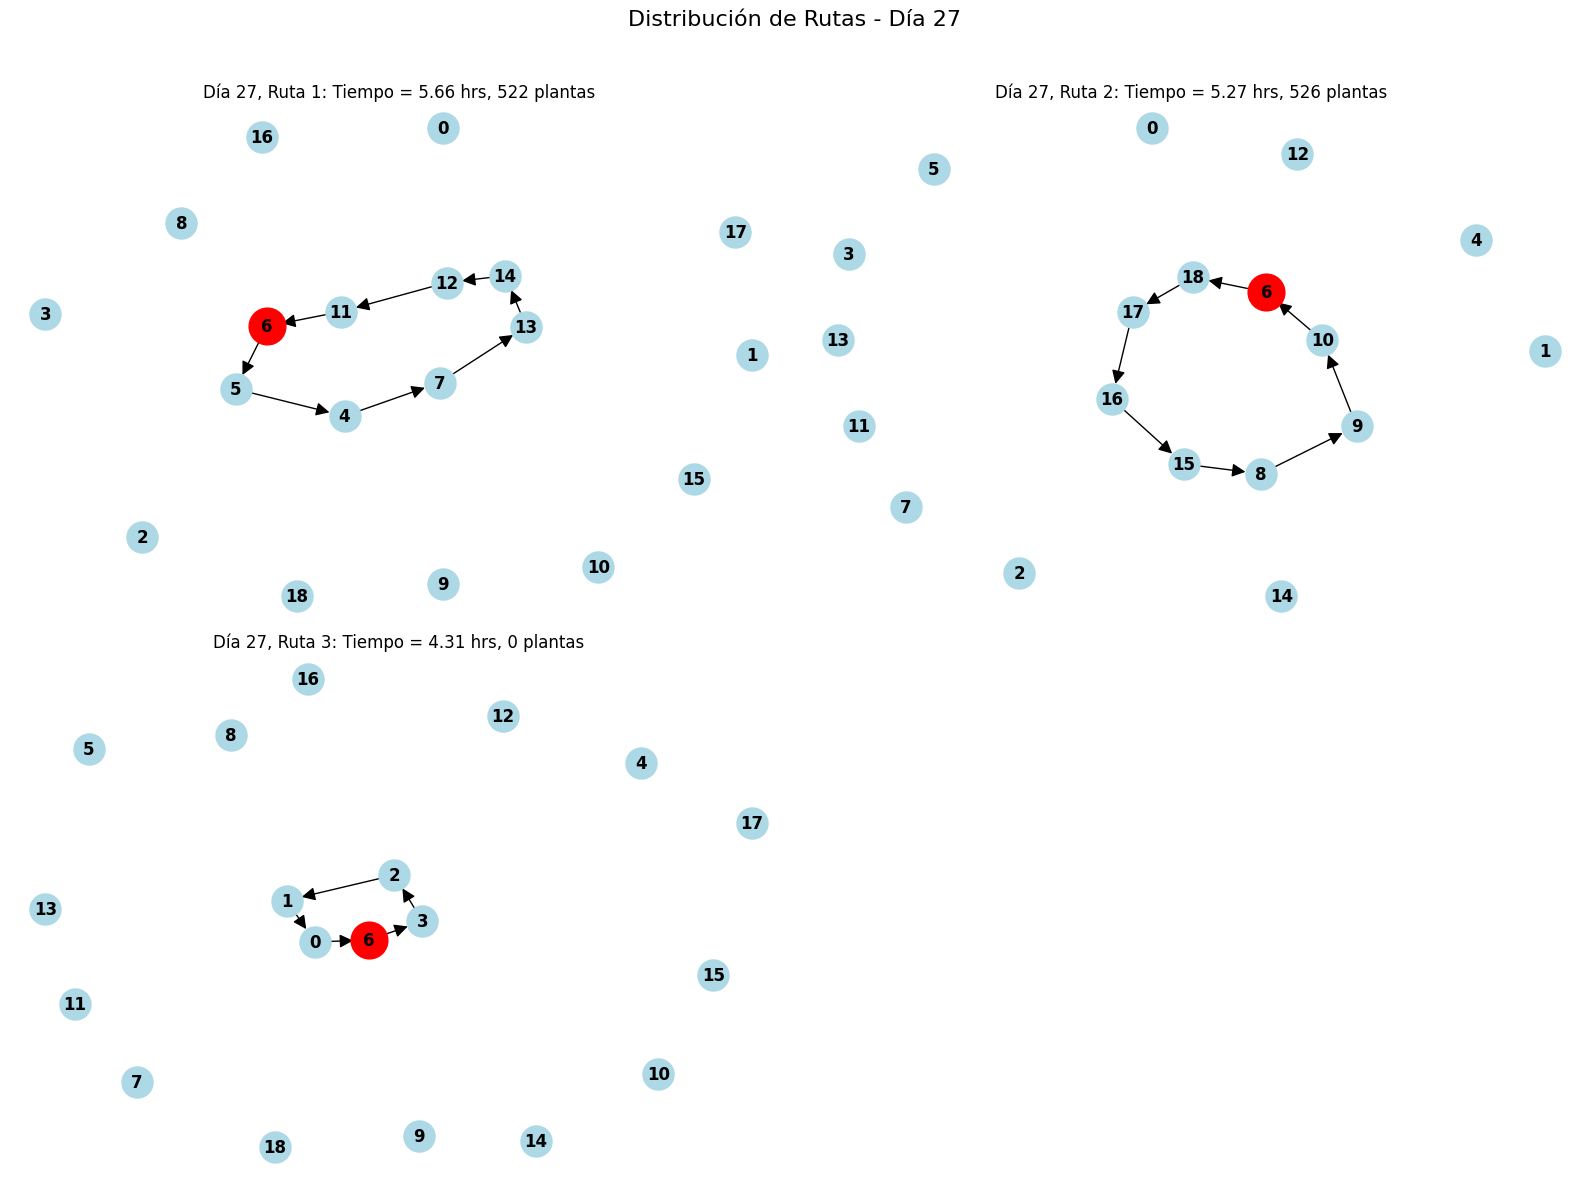


SIMULACIÓN DÍA 28

Calculating orders for delivery on Day 29
Current demand: [1109, 669, 1109, 1109, 1309, 1024, 1939, 1713, 2305]
Demanda total: 12286, Capacidad máxima: 8000
⚠️ La demanda total (12286) excede la capacidad máxima (8000).
Se aplicará un ajuste proporcional a las cantidades solicitadas.
Capacidad utilizada: 8000.0 de 8000 (100.0%)

--- Análisis de Solución Greedy ---
Costo total: 193079.50
Costo de compra: 175079.50
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Distribución Detallada de Compras ---

especie 1:
  - Comprar 722 unidades a Laguna Seca (costo unitario: 26.00)

especie 2:
  - Comprar 436 unidades a Moctezuma (costo unitario: 26.00)

especie 3:
  - Comprar 722 unidades a Proveedor 4 (costo unitario: 25.00)

especie 4:
  - Comprar 722 unidades a Moctezuma (costo unitario: 17.00)

especie 5:
  - Comprar 852 unidades a Proveedor 4 (costo unitario: 18.00)

especie 

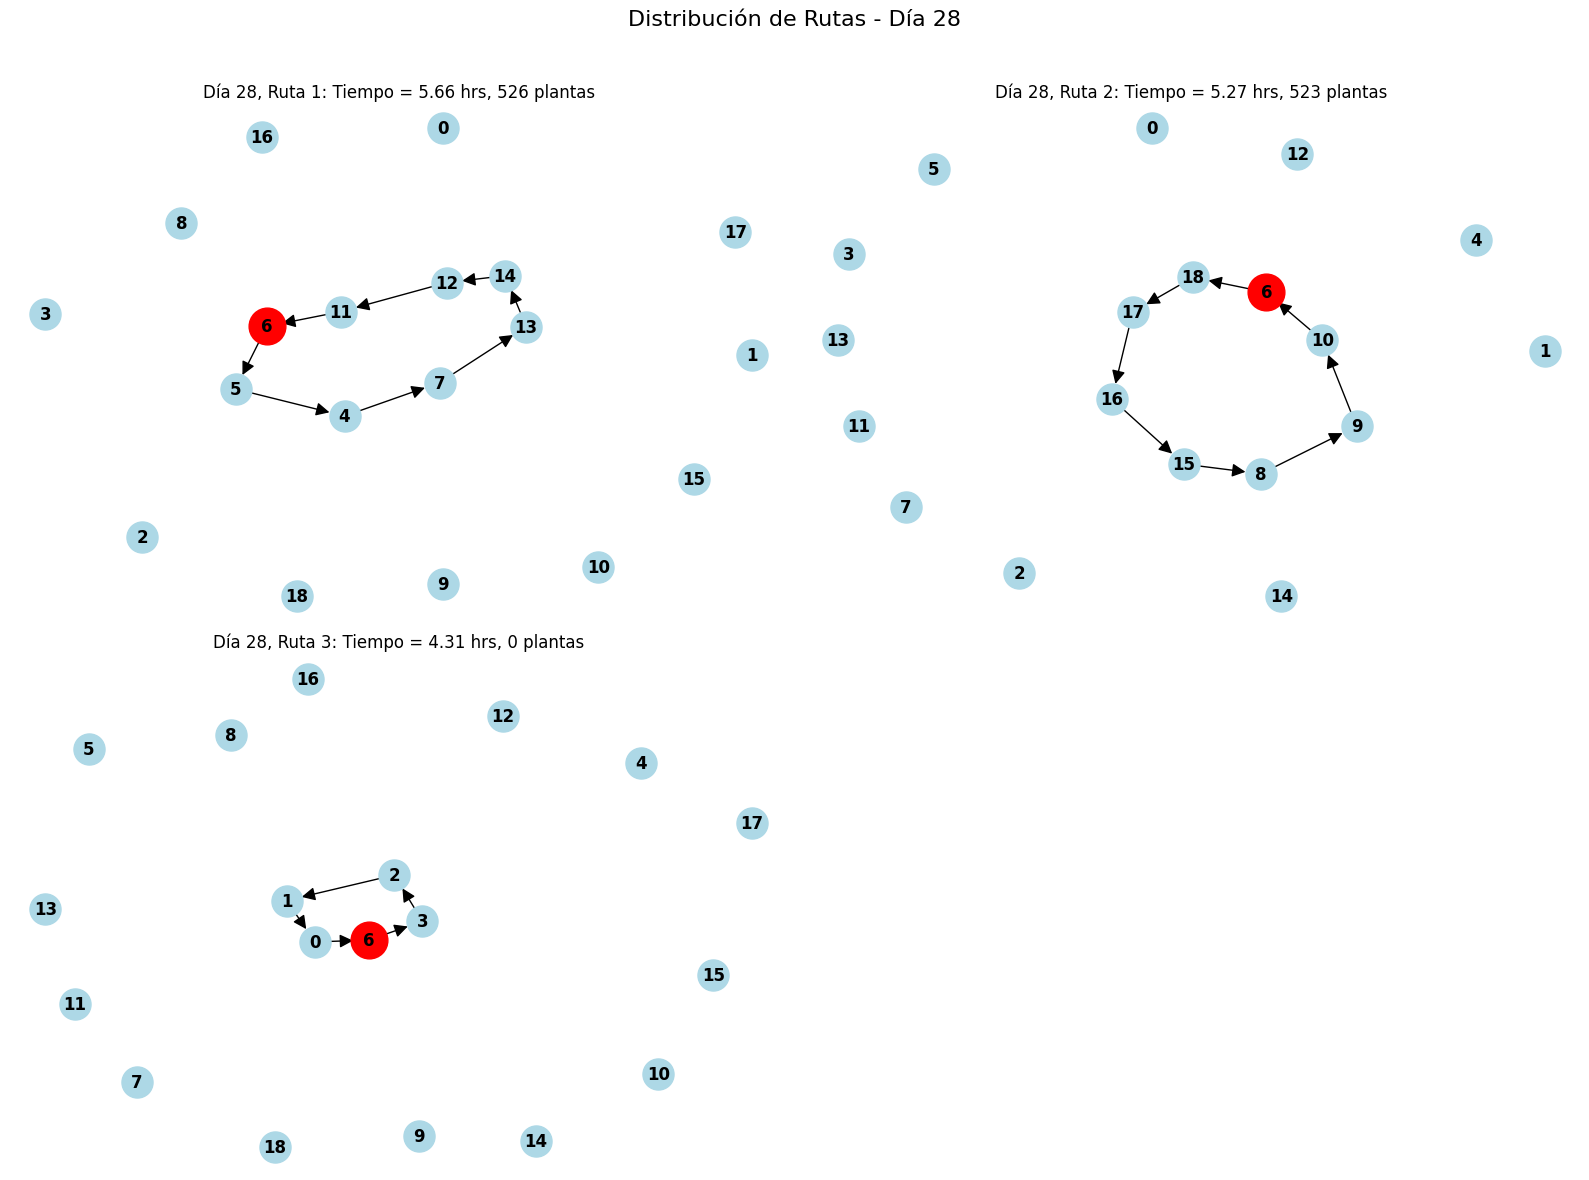


SIMULACIÓN DÍA 29

Calculating orders for delivery on Day 30
Current demand: [1015, 613, 1015, 1015, 1195, 937, 1774, 1564, 2108]
Demanda total: 11236, Capacidad máxima: 8000
⚠️ La demanda total (11236) excede la capacidad máxima (8000).
Se aplicará un ajuste proporcional a las cantidades solicitadas.
Capacidad utilizada: 8001.0 de 8000 (100.0%)

--- Análisis de Solución Greedy ---
Costo total: 193103.00
Costo de compra: 175103.00
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Distribución Detallada de Compras ---

especie 1:
  - Comprar 723 unidades a Laguna Seca (costo unitario: 26.00)

especie 2:
  - Comprar 436 unidades a Moctezuma (costo unitario: 26.00)

especie 3:
  - Comprar 723 unidades a Proveedor 4 (costo unitario: 25.00)

especie 4:
  - Comprar 723 unidades a Moctezuma (costo unitario: 17.00)

especie 5:
  - Comprar 851 unidades a Proveedor 4 (costo unitario: 18.00)

especie 6

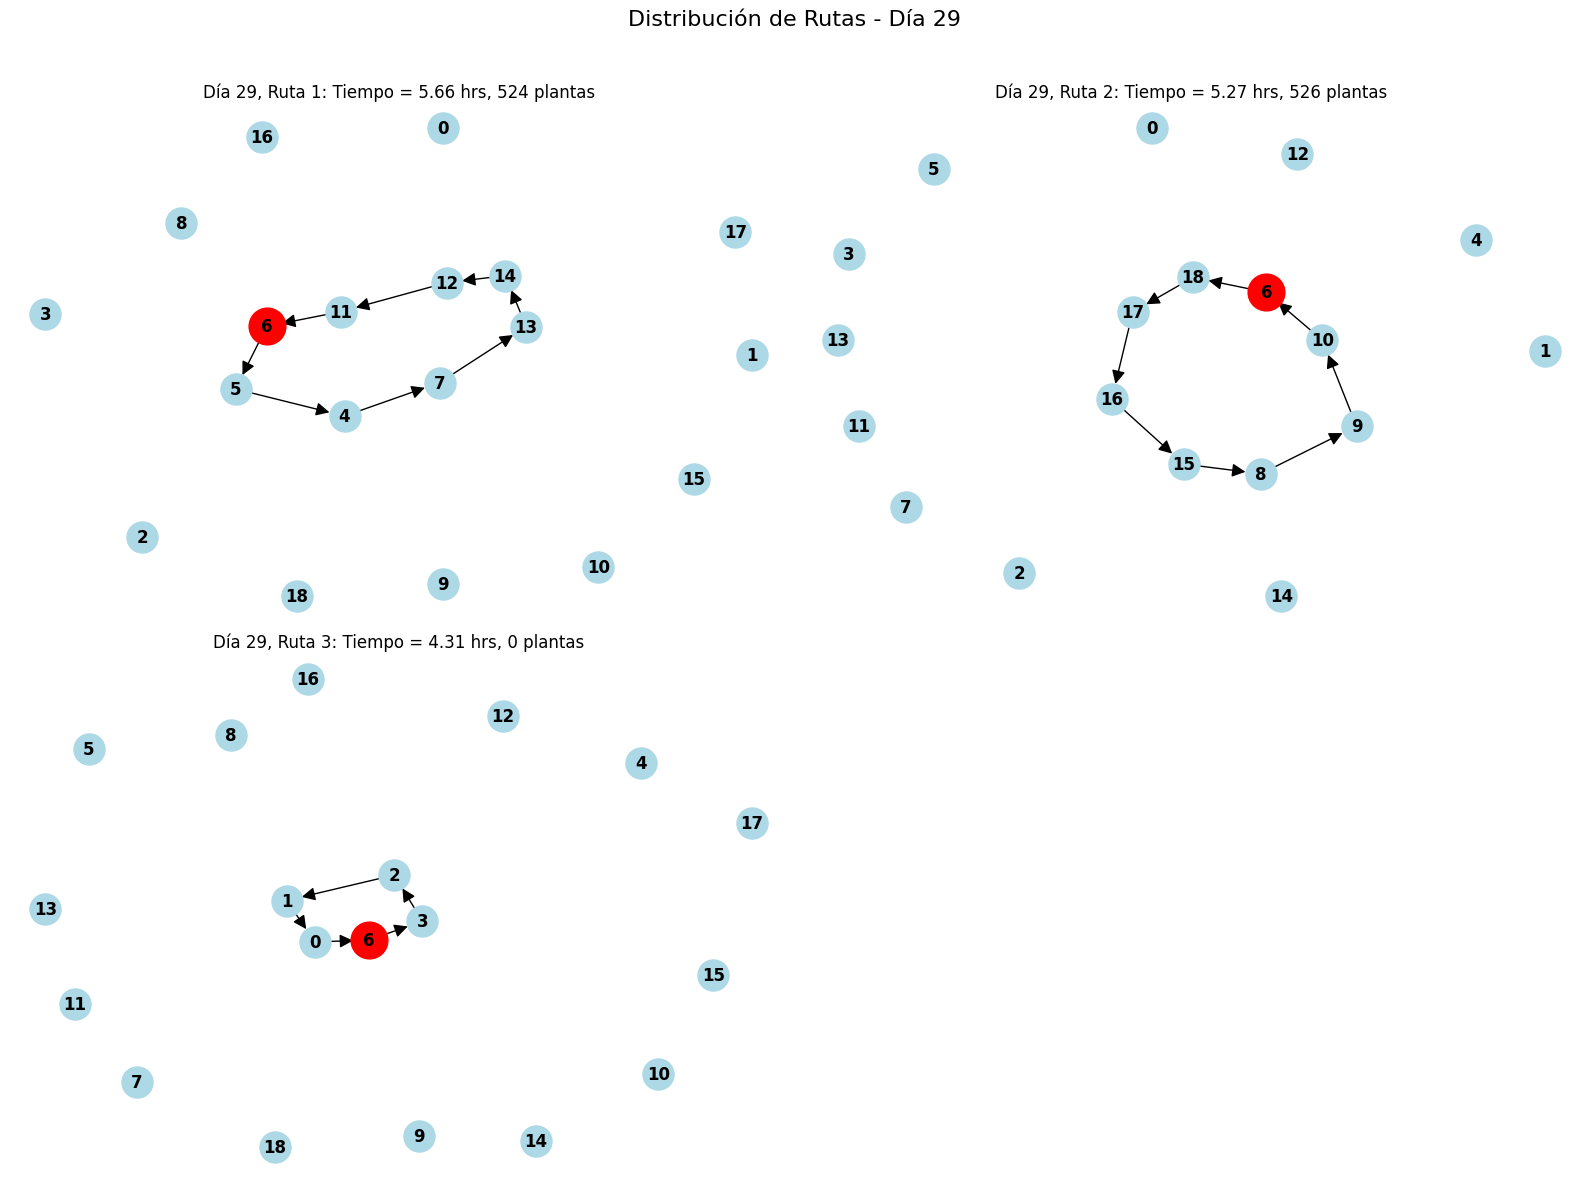


SIMULACIÓN DÍA 30

==================== INFORME DEL DÍA 30 ====================

No se realizaron pedidos hoy.

--- ESTADO DEL INVENTARIO ---
especie 1: Total=805, Disponible=376, Joven=284, Viejo=145
especie 2: Total=482, Disponible=226, Joven=171, Viejo=85
especie 3: Total=805, Disponible=376, Joven=284, Viejo=145
especie 4: Total=805, Disponible=376, Joven=284, Viejo=145
especie 5: Total=953, Disponible=447, Joven=335, Viejo=171
especie 6: Total=765, Disponible=347, Joven=261, Viejo=157
especie 7: Total=1406, Disponible=662, Joven=498, Viejo=246
especie 8: Total=1259, Disponible=586, Joven=439, Viejo=234
especie 9: Total=1668, Disponible=789, Joven=591, Viejo=288

--- RUTAS GENERADAS HOY: 3 ---

Ruta 1: [6, 5, 4, 7, 13, 14, 12, 11, 6], Tiempo: 5.66 hrs, Carga: 524.0 plantas
  Distribución:
  Polígono 5:
    - especie 1: 9 plantas
    - especie 2: 6 plantas
    - especie 3: 9 plantas
    - especie 4: 9 plantas
    - especie 5: 10 plantas
    - especie 6: 7 plantas
    - especie 7: 1

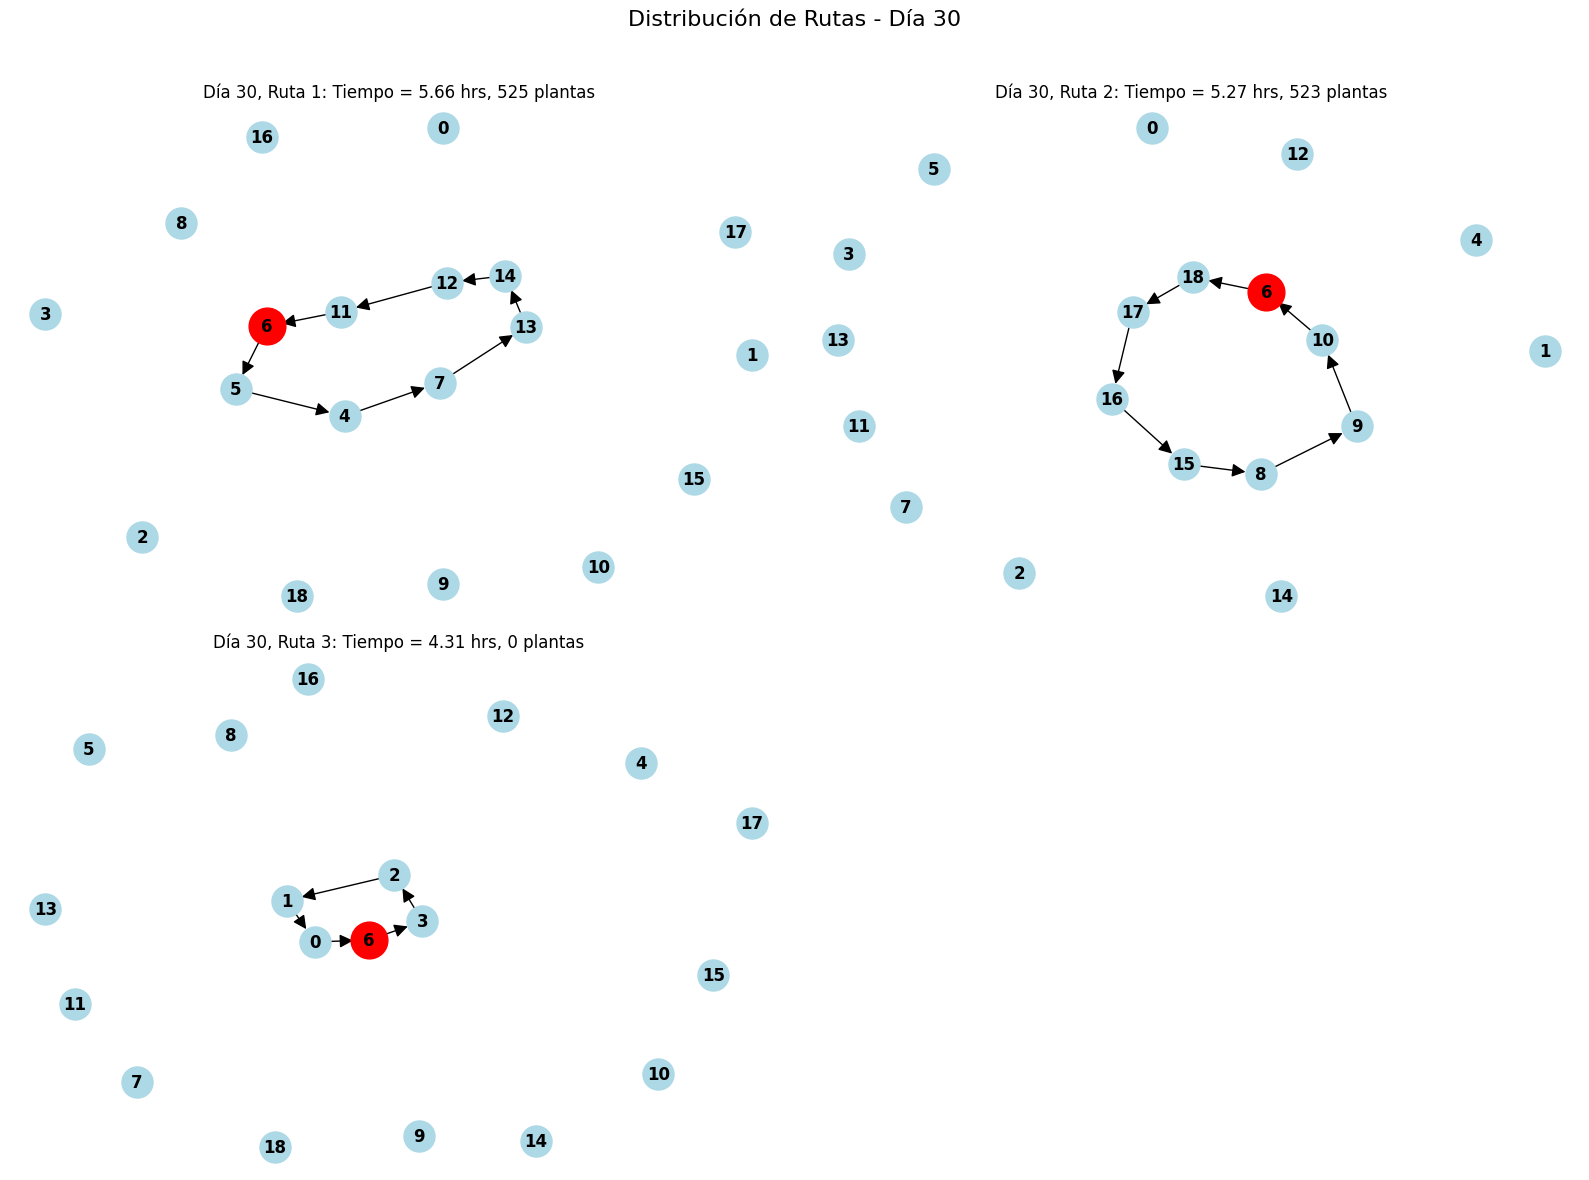


--- RESUMEN FINAL DE SIMULACIÓN ---
Días simulados: 30


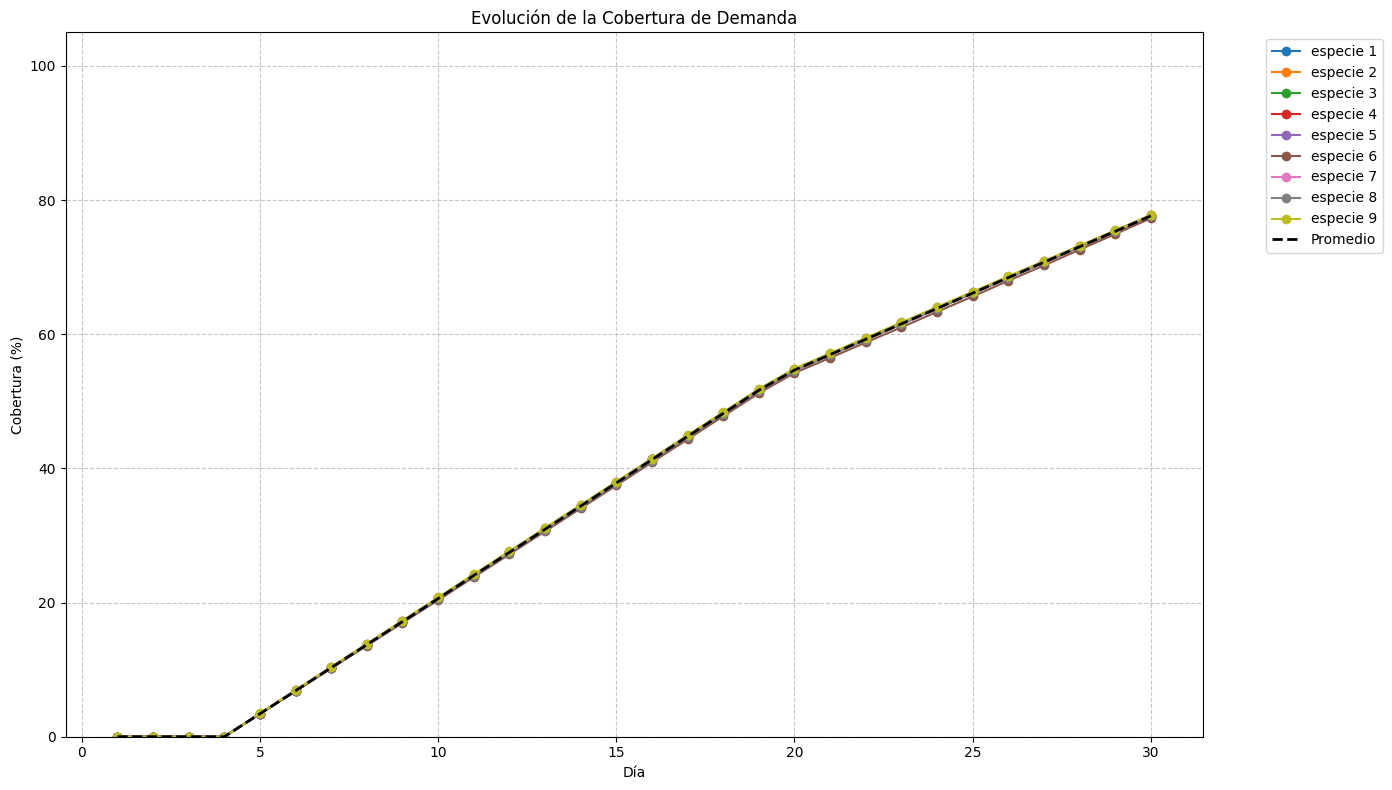

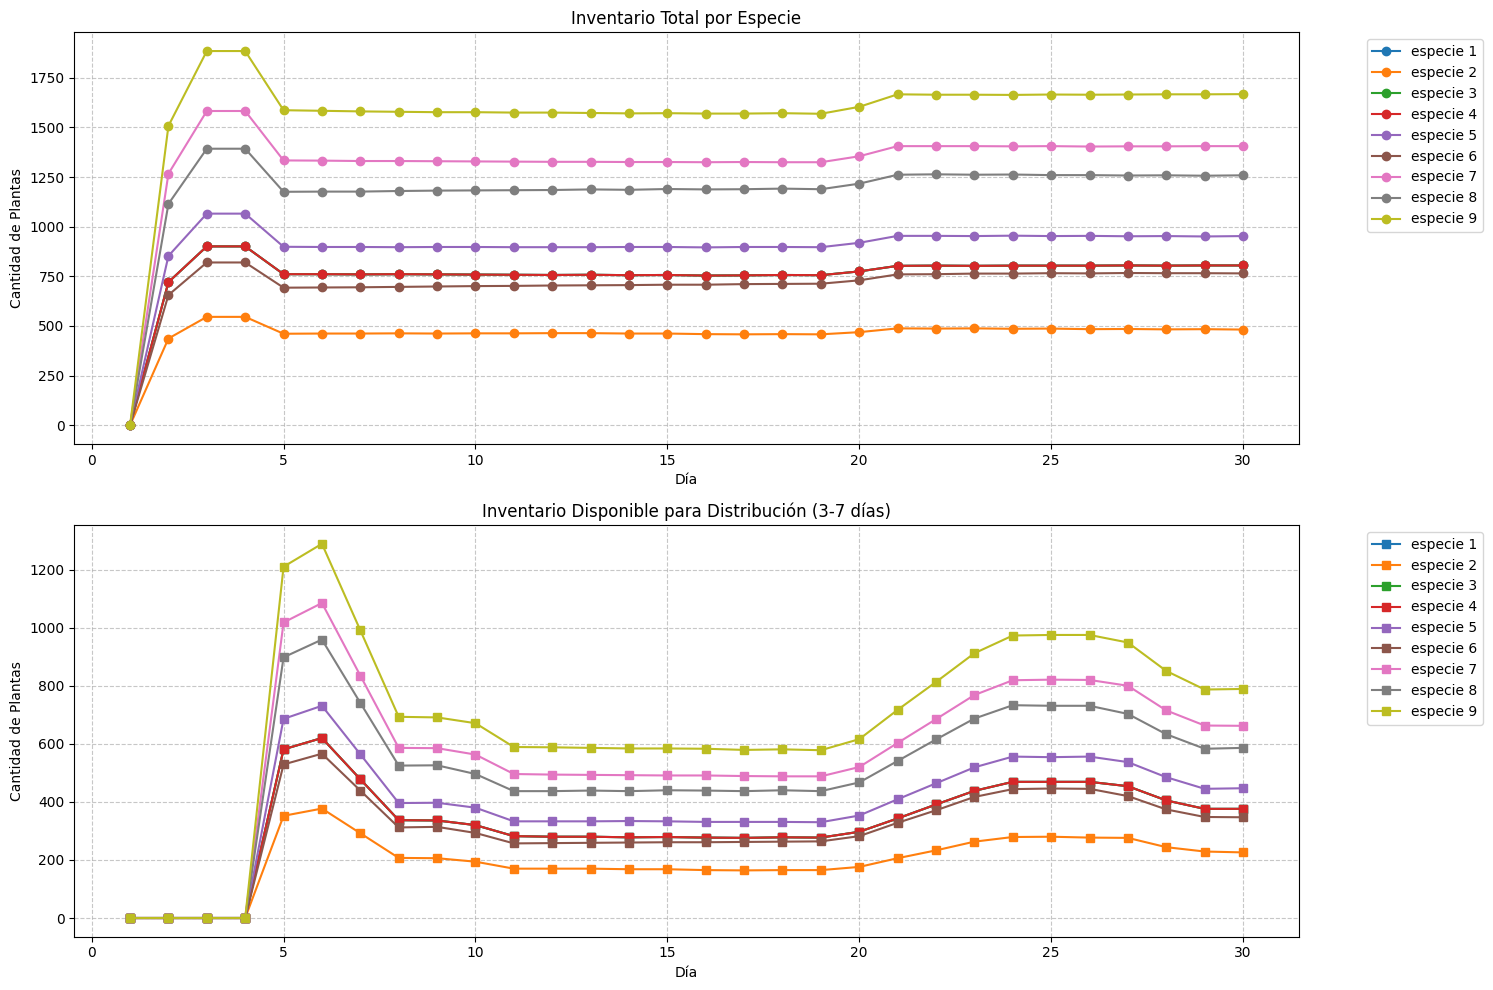


--- RESULTADO FINAL ---
Cobertura de demanda promedio: 77.64%
Total de plantas ordenadas: 231991
Simulación completada con éxito!


In [9]:
# Main execution
if __name__ == "__main__":
    # Print parameters
    print("\n--- PARÁMETROS DE SIMULACIÓN ---")
    print(f"Días de simulación: {dias_simulacion}")
    print(f"Capacidad máxima de transporte: {capacidad_máxima_transporte}")
    print(f"Días de anticipación para pedidos: {dias_anticipación}")
    print(f"Días mínimos de aclimatación: {min_dias_aclimatacion}")
    print(f"Días máximos de aclimatación: {max_dias_aclimatacion}")
    print(f"Capacidad de carga por ruta: {carga_máxima}")
    print(f"Tiempo máximo por ruta: {tiempo_maximo} horas")
    
    # Run simulation
    simulation_results = run_simulation()
    
    # Final summary messages
    final_coverage = simulation_results["daily_demand_coverage"][-1]
    avg_coverage = sum(final_coverage.values()) / len(final_coverage)
    
    print("\n--- RESULTADO FINAL ---")
    print(f"Cobertura de demanda promedio: {avg_coverage:.2%}")
    
    total_orders = sum(
        sum(providers.values()) for day_info in simulation_results["daily_orders"].values()
        for _, orders in [day_info] for species, providers in orders.items()
    )
    
    print(f"Total de plantas ordenadas: {total_orders}")
    print("Simulación completada con éxito!")